# One Genre To Rule Them All... Globally

We're going to analyze the worldwide box office returns of movies based on their genre.

This is the second step in our analysis. The first step was only considering the domestic market and can be found in the `Domestic.ipynb` notebook. 

To recap our findings there:
  - Horror is the safest genre to invest in. It's production budget is much lower than spectacle genres, and it has a higher chance of profitability on a per movie basis.
  - Action and Adventure are the riskiest genres. They're more expensive, and more often than not, they do not breakeven.
  
It's time now to see what the addition of the worldwide market does to our study!

# The Worldwide Market

It's difficult to pin down exact totals for the domestic versus worldwide box office, but it's clear with each passing year, more and more of a movie's gross comes from abroad.

[Statista](https://www.statista.com/) has 2018 totals being \\$11.9 billion for the [domestic market](https://www.statista.com/statistics/243180/leading-box-office-markets-workdwide-by-revenue/) and \\$29.2 billion for the [international market](https://www.statista.com/statistics/271856/global-box-office-revenue/).

That puts the total box office ratio at 29% domestic and 71% international.

We will use the same approach as our domestic analysis:
- Decide which genres to consider in our analysis.
 
- Decide on a profitability measure.

- Whittle our dataset down to movies released by the Big Five. This is to control for factors like lack of budget or marketing affecting a movie's success. Sure, independent movies can succeed, but our bosses want to see how the genres performed with all the help of a studio behind them.

- Analyze the historical performance of the genres by decade. There might be some trends over time that would be useful to know.

- Analyze the historical performance of the genres by release week. Maybe certain genres perform better at certain times of year.

- Incorporate our findings into a strategy for our bosses!

# Deciding on Genres

According to [The Numbers](https://www.the-numbers.com/market/), the top six genres in terms of box office gross are:
- Adventure
- Action
- Drama
- Comedy
- Thriller/Suspense
- Horror

Our bosses like making money.

Sold.

# Is This Movie Profitable? 

The box office share a studio makes from international sales varies incredibly from country to country.

An article on [Gizmodo](https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305) claims that a good rule of thumb is that a movie breaks even when it earns twice its production budget worldwide. 

## Profitability equation

We will include marketing costs when calculating the breakeven point. These numbers vary greatly from movie to movie, so we will again assume a 50% spend, pegged to each movie's production budget.   

**Worldwide box office = 2 * 1.5 * Production budget**

So if a movie earns at least three times its original production budget worldwide, it is a winner!

# Curate our dataset

## Import libraries and settings

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# For creating colormaps
import matplotlib.cm as cm

plt.style.use('fivethirtyeight')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import data

In [2]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'], usecols=['title', 'distributor_mojo', 'worldwide_adj', 'budget_adj', 'genres_mojo', 'release_year', 'release_week', 'release_date'])

# Only look at movies that made money
data = data[data['worldwide_adj'].notna() & data['worldwide_adj'] > 0]

# Only look at movies with budget information
data = data[data['budget_adj'].notna()]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['worldwide_breakeven'] = data['worldwide_adj'] >= 3 * data['budget_adj']

# For profit analysis
data['profit'] = data['worldwide_adj'] - 3 * data['budget_adj']

# Create columns for genres
# A movie can have multiple genres. If so, we will count them for all the genres its classified with.
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)

# Remove rows that don't contain one of our genres
data = data[data['action'] | data['adventure'] | data['comedy'] | data['drama'] | data['horror'] | data['thriller_suspense']]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 20 to 19775
Data columns (total 17 columns):
title                  3749 non-null object
release_year           3749 non-null int64
distributor_mojo       3749 non-null object
genres_mojo            3749 non-null object
release_date           3749 non-null datetime64[ns]
worldwide_adj          3749 non-null float64
budget_adj             3749 non-null float64
release_week           3749 non-null int64
release_decade         3749 non-null int64
worldwide_breakeven    3749 non-null bool
profit                 3749 non-null float64
action                 3749 non-null bool
adventure              3749 non-null bool
comedy                 3749 non-null bool
drama                  3749 non-null bool
horror                 3749 non-null bool
thriller_suspense      3749 non-null bool
dtypes: bool(7), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 347.8+ KB


## Organize By Distributors

The [Big Five](https://en.wikipedia.org/wiki/Major_film_studio#Past) studios we will use in our analysis are:
- Universal
- Paramount
- Warner Bros.
- Disney
- Sony

Studios have come and gone a lot historically. They get bought out by competitors, or go out of business. A lot of messy stuff.

To simplify, we will categorize a movie by its current studio owner. So for example, Disney [recently purchased](https://theweek.com/speedreads/780191/disney-buys-21st-century-fox-713-billion) 20th Century Fox. So we will categorize a 20th Century Fox movie as Disney.

In [4]:
data[data['distributor_mojo'].notna()]['distributor_mojo'].value_counts()

Universal                           355
Warner Bros.                        346
Fox                                 301
Sony / Columbia                     266
Paramount                           264
Buena Vista                         217
New Line                            122
Miramax                             114
Fox Searchlight                     106
Lionsgate                           104
MGM                                  89
Sony Classics                        81
Sony / Screen Gems                   69
Focus Features                       64
Weinstein Company                    49
Warner Bros. (New Line)              49
IFC                                  46
DreamWorks                           42
Lions Gate                           41
United Artists                       41
Magnolia                             41
Columbia                             41
Roadside Attractions                 35
TriStar                              34
Sony (Revolution)                    30


In [5]:
# Create a regex string to combine movies into their respective distributor
# https://en.wikipedia.org/wiki/Major_film_studio#Past
nbcuniversal = 'Universal|Focus Features|Focus World|Gramercy|Working Title|Big Idea|DreamWorks$|Illumination|Carnival|Mac Guff|United International'

print(data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Universal         355
Focus Features     64
DreamWorks         42
Gramercy           13
Focus World         3
Name: distributor_mojo, dtype: int64
Sum: 477


In [6]:
viacom = 'Paramount|BET|Comedy Central|MTV|Nickelodeon|Bardel Entertainment|MTV Animation|Nickelodeon Animation Studio|Awesomeness|CMT|Melange|United International Pictures|VH1|Viacom 18 Motion Pictures'

print(data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Paramount                 264
Paramount (DreamWorks)     18
Paramount Vantage          14
Paramount Classics         10
Paramount Insurge           2
Name: distributor_mojo, dtype: int64
Sum: 308


In [7]:
warnermedia = 'Warner Bros.|CNN Films|HBO|DC Films|New Line|Cartoon Network Studios|Wang Film Productions|Adult Swim Films|Castle Rock Entertainment|Cinemax|Flagship|Fullscreen|Hello Sunshine|Spyglass'

print(data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Warner Bros.               346
New Line                   122
Warner Bros. (New Line)     49
Name: distributor_mojo, dtype: int64
Sum: 517


In [8]:
disney = 'Walt Disney|^Fox$|Fox Atomic|A&E|Disneynature|ESPN|Fox Searchlight|Hulu|National Geographic|VICE|Fox Family|Lucasfilm|Marvel|The Muppets Studio|UTV Motion Pictures|20th Century Fox Animation|Blue Sky Studios|Lucasfilm Animation|Marvel Animation|Pixar Animation Studios|Buena Vista|Disney|Dragonfly Film Productions|Fox Star Studios|Fox Studios Australia|Kudos Film|New Regency|Patagonik Film Group|Shine Group|Tiger Aspect Productions|Zero Day Fox'

print(data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Fox                301
Buena Vista        217
Fox Searchlight    106
Fox Atomic           3
Disney               1
Name: distributor_mojo, dtype: int64
Sum: 628


In [9]:
sony = 'Sony|Columbia|Affirm|Screen Gems|Stage 6|Ghost Corps|Funimation|Madhouse|Manga Entertainment UK|TriStar|Destination Films|Left Bank Pictures|Triumph Films'

print(data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Sony / Columbia        266
Sony Classics           81
Sony / Screen Gems      69
Columbia                41
TriStar                 34
Sony (Revolution)       30
Sony / AFFIRM Films      2
Name: distributor_mojo, dtype: int64
Sum: 523


In [10]:
data['universal'] = data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)
data['paramount'] = data['distributor_mojo'].str.contains(viacom, na=False, regex=True)
data['warner'] = data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)
data['disney'] = data['distributor_mojo'].str.contains(disney, na=False, regex=True)
data['sony'] = data['distributor_mojo'].str.contains(sony, na=False, regex=True)
data['distributor'] = np.nan

In [11]:
data.loc[data['universal'], 'distributor'] = 'Universal'
data.loc[data['paramount'], 'distributor'] = 'Paramount'
data.loc[data['warner'], 'distributor'] = 'Warner'
data.loc[data['disney'], 'distributor'] = 'Disney'
data.loc[data['sony'], 'distributor'] = 'Sony'

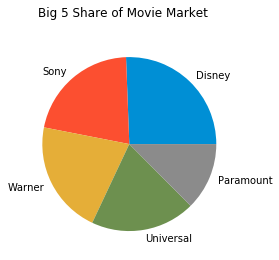

In [12]:
# We only want to keep rows that have one of the Big Five
data = data[data['distributor'].notna()]

figure, axis = plt.subplots()
figure.suptitle('Big 5 Share of Movie Market')

data['distributor'].value_counts().plot(kind='pie')
axis.set_ylabel('');

## Check Movies By Decade

We have very few movies from before the 1970s. We will remove these entries to simplify our analysis.

In [13]:
data['release_decade'].value_counts()

2000    1047
2010     740
1990     501
1980     114
1970      31
1960       9
1950       8
1930       2
1940       1
Name: release_decade, dtype: int64

In [14]:
data = data[data['release_decade'] >= 1970]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 20 to 19775
Data columns (total 23 columns):
title                  2433 non-null object
release_year           2433 non-null int64
distributor_mojo       2433 non-null object
genres_mojo            2433 non-null object
release_date           2433 non-null datetime64[ns]
worldwide_adj          2433 non-null float64
budget_adj             2433 non-null float64
release_week           2433 non-null int64
release_decade         2433 non-null int64
worldwide_breakeven    2433 non-null bool
profit                 2433 non-null float64
action                 2433 non-null bool
adventure              2433 non-null bool
comedy                 2433 non-null bool
drama                  2433 non-null bool
horror                 2433 non-null bool
thriller_suspense      2433 non-null bool
universal              2433 non-null bool
paramount              2433 non-null bool
warner                 2433 non-null bool
disney                 

## Summary

Our filtered dataset now has 2,433 entries. 

The movie studios all have a fair chunk of the dataset. This will hopefully prevent bias stemming from lack of equitable market share.

We have no missing values, so we can do all monetary calculations safely. 

# Create Graphing Helper Function and Summary DataFrame

In [15]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html

# Function to add counts/percentages to bar plots
def autolabel(axis, num_decimals=0, counts=None):
    """
    Attach a text label above each bar displaying its height.
    If sent a list of counts, display those instead.
    """
    for i, val in enumerate(axis.patches):
        if counts is not None:
            height = counts[i]
        else:
            height = round(val.get_height(), num_decimals) if num_decimals > 0 else int(val.get_height())
        
        # We don't want to display zeros on our bar plots
        if (height == 0) or pd.isnull(height):
            continue
            
        # Put the count below a negative value bar
        if height < 0:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*0.95, '{}'.format(height), ha='center', va='bottom', fontsize=20)
        else:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '{}'.format(height), ha='center', va='bottom', fontsize=20)

In [16]:
# Create custom function to generate the color list when graphing
def generate_color_list(colors_needed=1, order_list=['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']):
    colors_available = ['color1', 'color2', 'color3']
    c_list = []
    
    # Matplotlib needs a list of colors if the graph doesn't have multiple columns per index
    if colors_needed == 1:
        c_list = [genres_dict[genre][colors_available[0]] for genre in order_list]
        return c_list
    
    # Matplotlib needs a list of tuples if the graph has multiple columns per index
    for i in range(colors_needed):
        temp_tuple = tuple([genres_dict[genre][colors_available[i]] for genre in order_list])
        c_list.append(temp_tuple)
        
    return c_list

In [17]:
# Create lists of useful information for graphing
genres = ['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']
colors = ['#008FD5', '#FC4F30', '#E5AE38', '#6D904F', '#8B8B8B', '#810F7C']
colors2 = ['#87C7E5', '#F4BAB0', '#F4DBA8', '#C7E2AE', '#D6D1D1', '#CE8EDB']
colors3 = ['#C5E7F7', '#F4D7D2', '#F9ECD1', '#E3F2D5', '#EAE8E8', '#ECC8F4']

# Create a dictionary holding the colors for each genre
genres_dict = {
    'action': {'color1': '#008FD5', 'color2': '#87C7E5', 'color3': '#C5E7F7', 'colormap': 'Blues'},
    'adventure': {'color1': '#FC4F30', 'color2': '#F4BAB0', 'color3': '#F4D7D2', 'colormap': 'Oranges'},
    'comedy': {'color1': '#E5AE38', 'color2': '#F4DBA8', 'color3': '#F9ECD1', 'colormap': 'Reds'},
    'drama': {'color1': '#6D904F', 'color2': '#C7E2AE', 'color3': '#E3F2D5', 'colormap': 'Greens'},
    'horror': {'color1': '#8B8B8B', 'color2': '#D6D1D1', 'color3': '#EAE8E8', 'colormap': 'Greys'},
    'thriller_suspense': {'color1': '#810F7C', 'color2':  '#CE8EDB', 'color3': '#ECC8F4', 'colormap': 'Purples'}
    }

# Create a summary statistics dataframe separated by genre to make graphing easier
# The columns are:
# Number of movies
# Average gross
# All-time gross
# Average budget
# All-time budget
# Dollar earned for dollar spent (including marketing -- adjusted budget is 1.5 times original budget)
# Median dollars earned for dollars spent
# Mean dollars earned for dollars spent
# Median profit
# Mean profit
# All-time profit
# Breakeven percentage
# Current decade (2010s) median profit
# Current decade (2010s) mean profit
# Current decade (2010s) all profit
# Current decade (2010s) breakeven percentage

aggregation_stats_per_genre = {
    'num_movies': [data[genre].sum() for genre in genres],
    'avg_gross': [round(data[data[genre]]['worldwide_adj'].mean() / 1000000, 1) for genre in genres],
    'median_gross': [round(data[data[genre]]['worldwide_adj'].median() / 1000000, 1) for genre in genres], 
    'all_time_gross': [round(data[data[genre]]['worldwide_adj'].sum() / 1000000000, 1) for genre in genres],
    'avg_budget': [round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres],
    'median_budget': [round(data[data[genre]]['budget_adj'].median() / 1000000, 1) for genre in genres],
    'all_time_budget': [round(data[data[genre]]['budget_adj'].sum() / 1000000000, 1) for genre in genres],
    'dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].sum() / 1000000) / (3 * data[data[genre]]['budget_adj'].sum() / 1000000), 1) for genre in genres],
    'median_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].median() / 1000000) / (3 * data[data[genre]]['budget_adj'].median() / 1000000), 1) for genre in genres],
    'mean_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].mean() / 1000000) / (3 * data[data[genre]]['budget_adj'].mean() / 1000000), 1) for genre in genres],
    'median_profit': [round((data[data[genre]]['profit'].median() / 1000000), 1) for genre in genres],
    'mean_profit': [round((data[data[genre]]['profit'].mean() / 1000000), 1) for genre in genres],
    'all_time_profit': [round(data[data[genre]]['profit'].sum() / 1000000000, 1) for genre in genres],
    'breakeven_percentage': [round(data[data[genre]]['worldwide_breakeven'].sum() / data[data[genre]]['worldwide_breakeven'].count() * 100, 1) for genre in genres],
    'current_decade_median_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].median() / 1000000), 1) for genre in genres],
    'current_decade_mean_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].mean() / 1000000), 1) for genre in genres],
    'current_decade_profit': [round(data[(data[genre]) & (data['release_year'] >=2010)]['profit'].sum() / 1000000000, 1) for genre in genres],
    'current_decade_breakeven_percentage': [round(data[(data[genre]) & (data['release_year'] >=2010)]['worldwide_breakeven'].mean() * 100, 1) for genre in genres]
}

# Bird's Eye View Of The Data

In [18]:
# Create a summary dataframe for simple graphs
summary = pd.DataFrame(aggregation_stats_per_genre, index=genres)
summary

num_movies  avg_gross  median_gross  all_time_gross  \
action                    479      315.6         208.5           151.2   
adventure                 250      392.9         258.3            98.2   
comedy                    955      131.1          77.6           125.2   
drama                     654      104.8          57.2            68.5   
horror                    252      174.3          95.9            43.9   
thriller_suspense         347      147.9          93.2            51.3   

                   avg_budget  median_budget  all_time_budget  \
action                  102.5           90.3             49.1   
adventure               124.1          120.4             31.0   
comedy                   45.6           35.8             43.6   
drama                    40.8           30.7             26.7   
horror                   44.4           31.5             11.2   
thriller_suspense        57.0           53.0             19.8   

                   dollars_earned_for_dollars_spent  \
action                                          1.0   
adventure                                       1.1   
comedy                                          1.0   
drama                                           0.9   
horror                                          1.3   
thriller_suspense                               0.9   

                   median_dollars_earned_for_dollars_spent  \
action                                                 0.8   
adventure                                              0.7   
comedy                                                 0.7   
drama                                                  0.6   
horror                                                 1.0   
thriller_suspense                                      0.6   

                   mean_dollars_earned_for_dollars_spent  median_profit  \
action                                               1.0          -25.8   
adventure                                            1.1          -45.6   
comedy                                               1.0          -20.0   
drama                                                0.9          -24.7   
horror                                               1.3           -4.9   
thriller_suspense                                    0.9          -36.3   

                   mean_profit  all_time_profit  breakeven_percentage  \
action                     8.1              3.9                  40.3   
adventure                 20.6              5.2                  39.2   
comedy                    -5.8             -5.6                  35.7   
drama                    -17.6            -11.5                  33.9   
horror                    41.1             10.4                  47.6   
thriller_suspense        -23.0             -8.0                  32.6   

                   current_decade_median_profit  current_decade_mean_profit  \
action                                      5.7                        70.3   
adventure                                  10.4                        72.5   
comedy                                    -12.7                        -4.6   
drama                                     -12.7                        -0.4   
horror                                     23.3                        53.1   
thriller_suspense                         -15.3                         5.4   

                   current_decade_profit  current_decade_breakeven_percentage  
action                              12.4                                 51.7  
adventure                            6.5                                 50.6  
comedy                              -1.2                                 39.1  
drama                               -0.1                                 38.8  
horror                               3.9                                 62.2  
thriller_suspense                    0.5                                 41.3

## Number of movies

In [128]:
# Create custom function to make bar graphs with our summary dataframe
def plot_summary_dataframe(summary, sort_column, plot_columns, title, colors_needed=1, legend_needed=False, legend_text=[], y_label='Millions', num_decimals=0):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle(title, fontsize=20, y=1.02)

    summary.sort_values(sort_column, ascending=False, inplace=True)

    color_list = generate_color_list(colors_needed=colors_needed, order_list=summary.index)

    summary.plot(y=plot_columns, kind='bar', ax=axis, color=color_list, legend=legend_needed)
    axis.set_ylabel(y_label, fontsize=20)
    axis.set_xlabel('')
    axis.tick_params(labelsize=20)
    
    if legend_needed:
        axis.legend(legend_text, fontsize=20)
        
    autolabel(axis, num_decimals=num_decimals)

    plt.tight_layout()

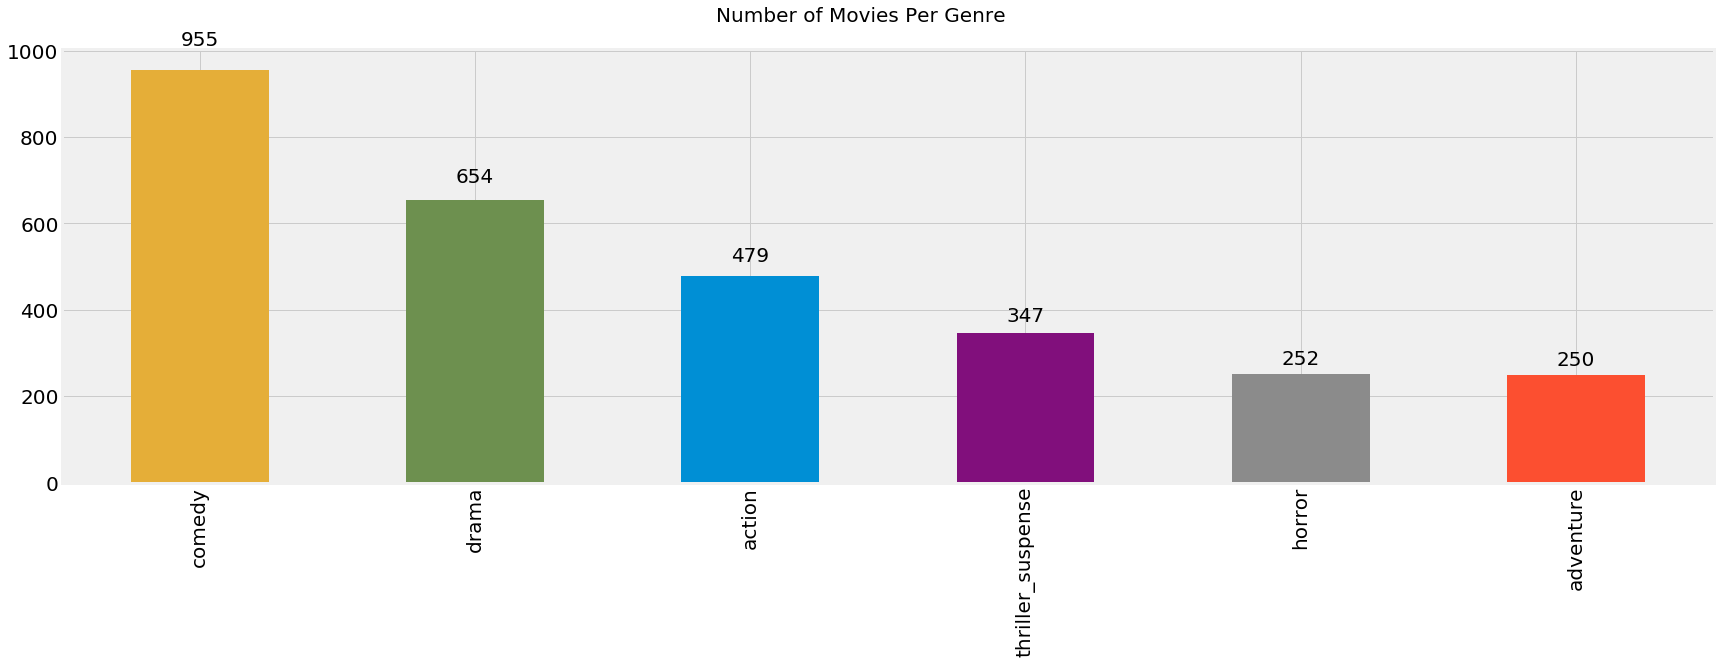

In [373]:
plot_summary_dataframe(summary=summary, sort_column='num_movies', plot_columns='num_movies', 
                       title='Number of Movies Per Genre', colors_needed=1, legend_needed=False, legend_text=[], y_label='', num_decimals=0)

## Grosses

In [110]:
# Create custom function to plot different aggregate statistics as histograms
def plot_aggregate_histogram(data, stat, title, bins=10, color=genres_dict['action']['color2']):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
    figure.suptitle(title, fontsize=20)

    (data[stat] / 1000000).plot.hist(bins=bins, ax=axis, fontsize=20, color=color)
    axis.set_xlabel('Millions', fontsize=20)
    axis.set_ylabel('Frequency', fontsize=20)
    axis.axvline(data[stat].median() / 1000000, color='k')
    axis.axvline(data[stat].mean() / 1000000, color='r')
    axis.legend(['Median: {:.1f} million'.format(data[stat].median() / 1000000), 'Mean: {:.1f} million'.format(data[stat].mean() / 1000000)], fontsize=20)

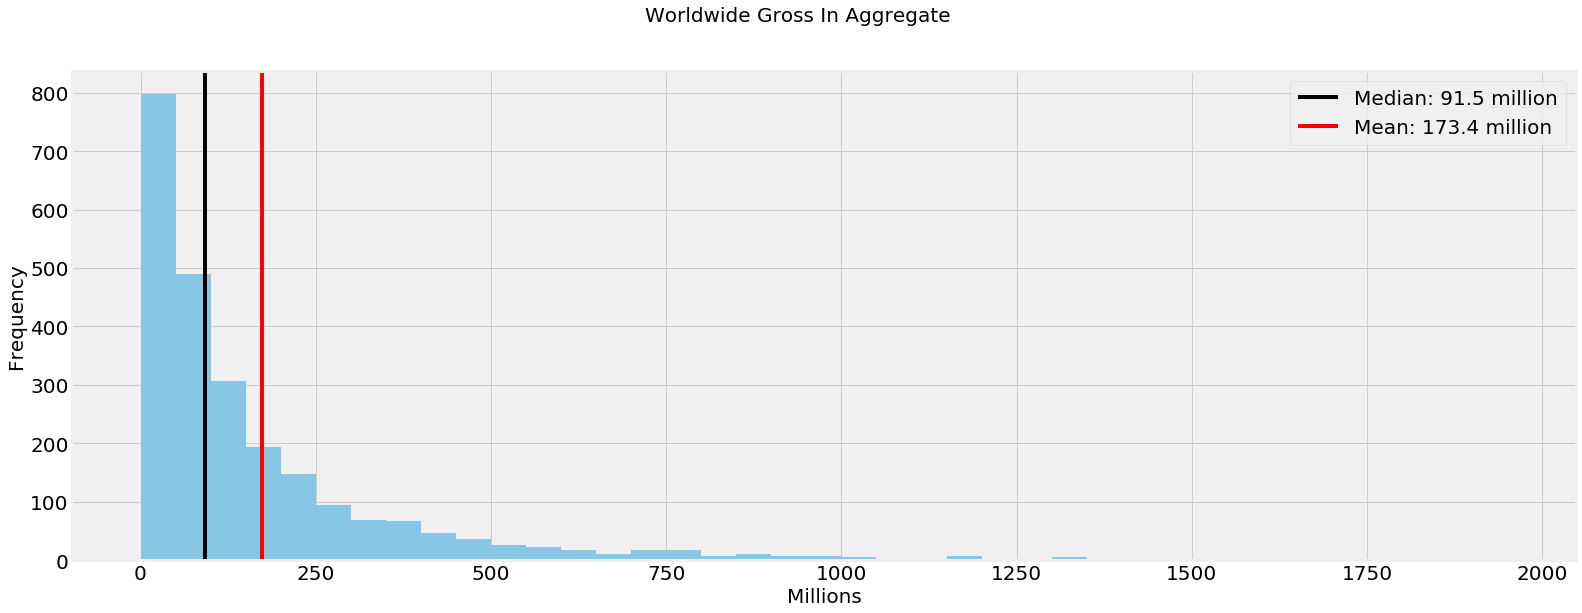

In [374]:
plot_aggregate_histogram(data=data, stat='worldwide_adj', title='Worldwide Gross In Aggregate', 
                         bins=range(0, 2000, 50), color=genres_dict['action']['color2'])

## Budgets

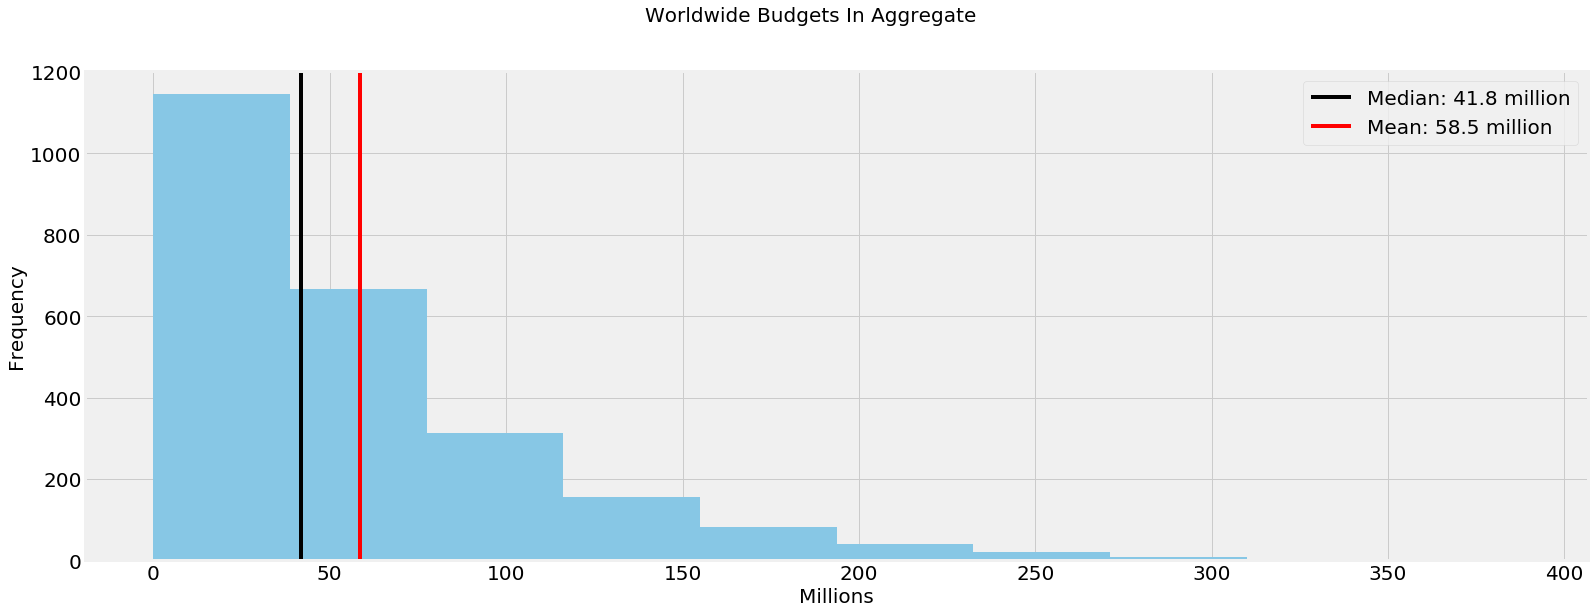

In [375]:
plot_aggregate_histogram(data=data, stat='budget_adj', title='Worldwide Budgets In Aggregate', 
                         bins=10, color=genres_dict['action']['color2'])

## Profits

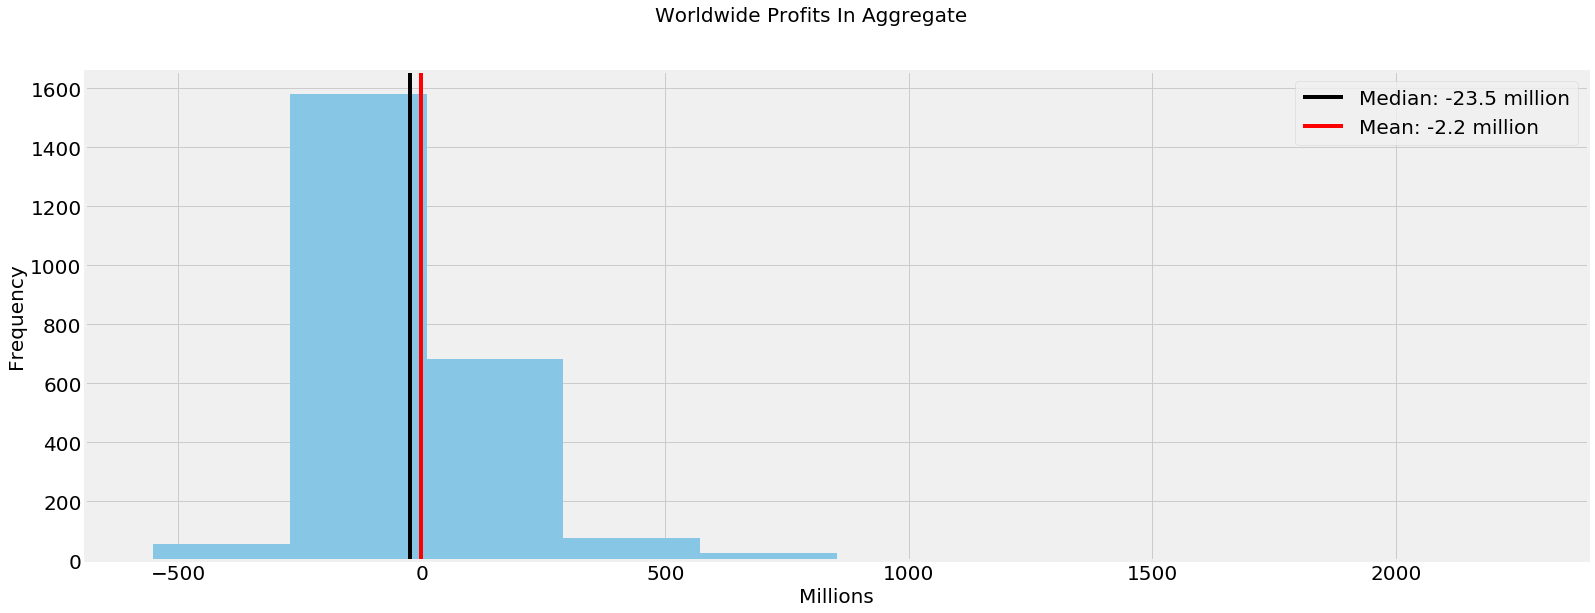

In [376]:
plot_aggregate_histogram(data=data, stat='profit', title='Worldwide Profits In Aggregate', bins=10, color=genres_dict['action']['color2'])

## Quick Takeaways

**Number of movies**
  - Comedy and Drama are historically the most produced genres by big movie studios by a healthy margin

**Skewed grosses**
  - Worldwide gross is heavily right-skewed. 
  - It has a much higher median than mean (almost double!)
  - This fits with our understanding of the movie business -- there are a few megahits that earn outsized returns while the majority of movies earn a little or even lose money
  
**Skewed budgets**
  - Budgets are also heavily right-skewed, but with a much shorter right-tail than worldwide gross
  - This also fits our understanding of the movie business -- most movies are made for relatively small budgets, and there are only a few blockbusters made that have very large budgets
  
**Skewed profits**
  - Profits are also skewed to the right.
  - It's interesting that both mean and median profits are negative. Movies are indeed not a slam-dunk investment.
  
**Use median**
  - We will err on the side of using the median for our summary statistic. Our bosses are looking for insight into what they can expect as an average return from a movie they produce. We'd all like to have the mega blockbusters, but to keep their expectations in check, we will report a more fair assessment of our prospects.

# Genres Overview

## Aggregate Gross

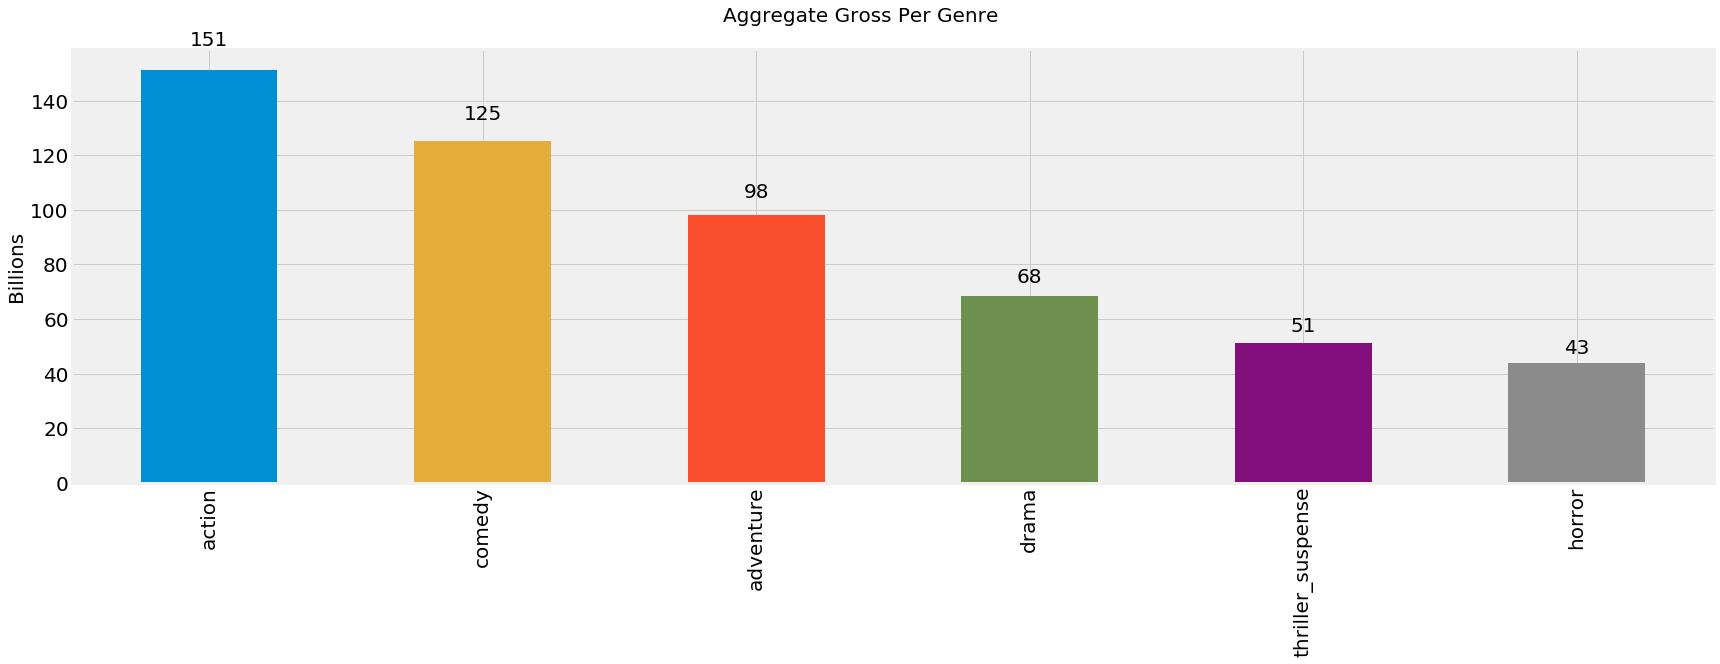

In [377]:
plot_summary_dataframe(summary=summary, sort_column='all_time_gross', plot_columns='all_time_gross', 
                       title='Aggregate Gross Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Billions', num_decimals=0)

## Aggregate Budget

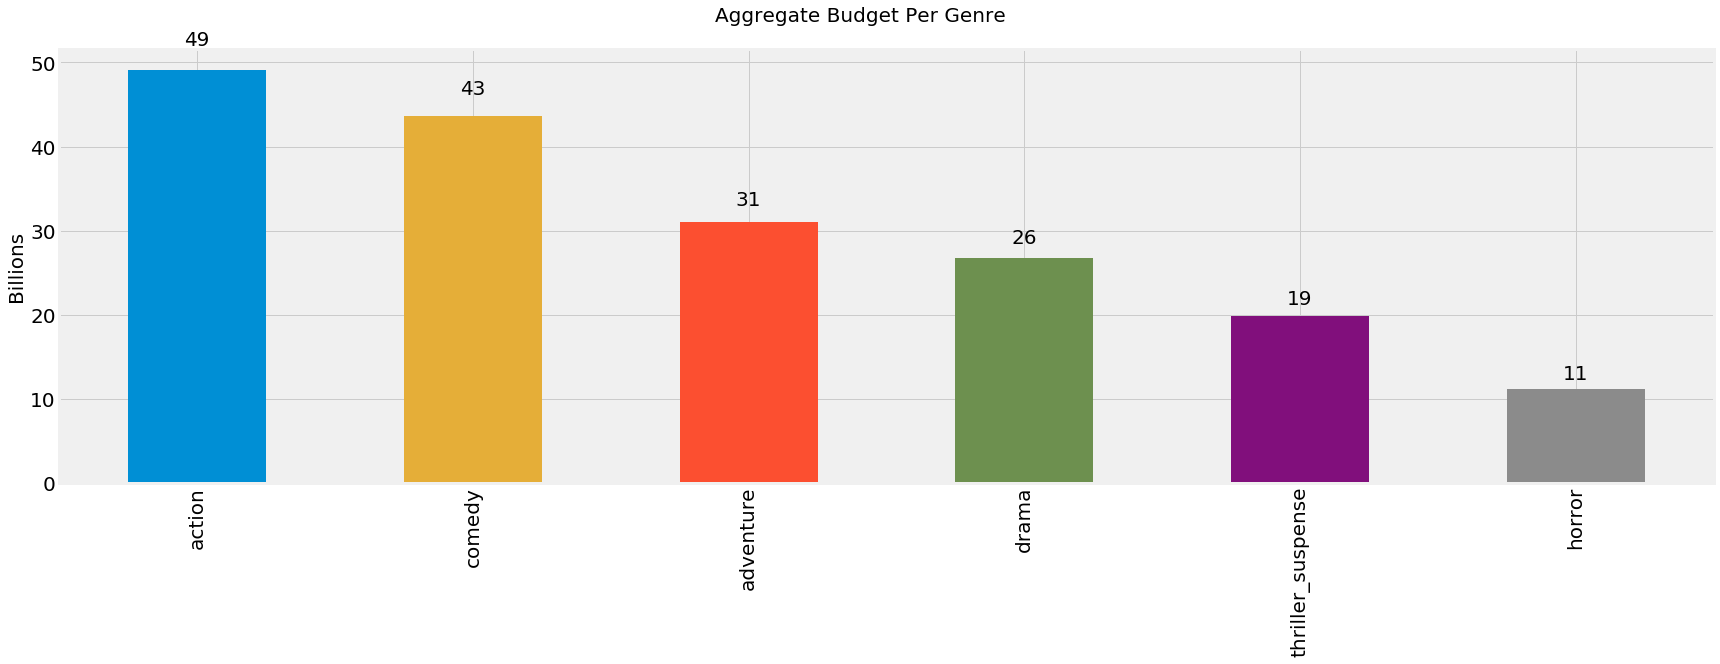

In [378]:
plot_summary_dataframe(summary=summary, sort_column='all_time_budget', plot_columns='all_time_budget', 
                       title='Aggregate Budget Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Billions', num_decimals=0)

## Aggregate Profit

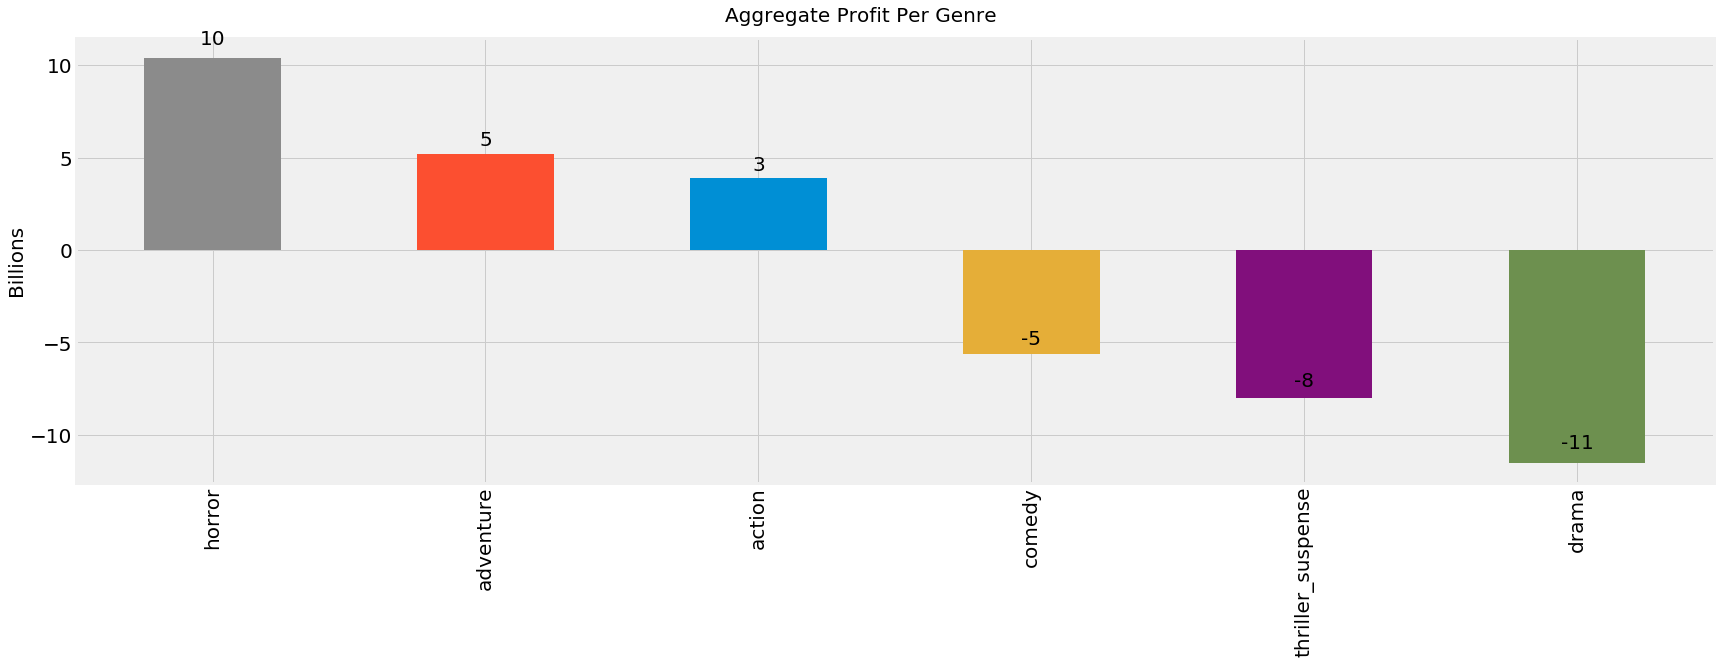

In [379]:
plot_summary_dataframe(summary=summary, sort_column='all_time_profit', plot_columns='all_time_profit', 
                       title='Aggregate Profit Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Billions', num_decimals=0)

## Median Profit

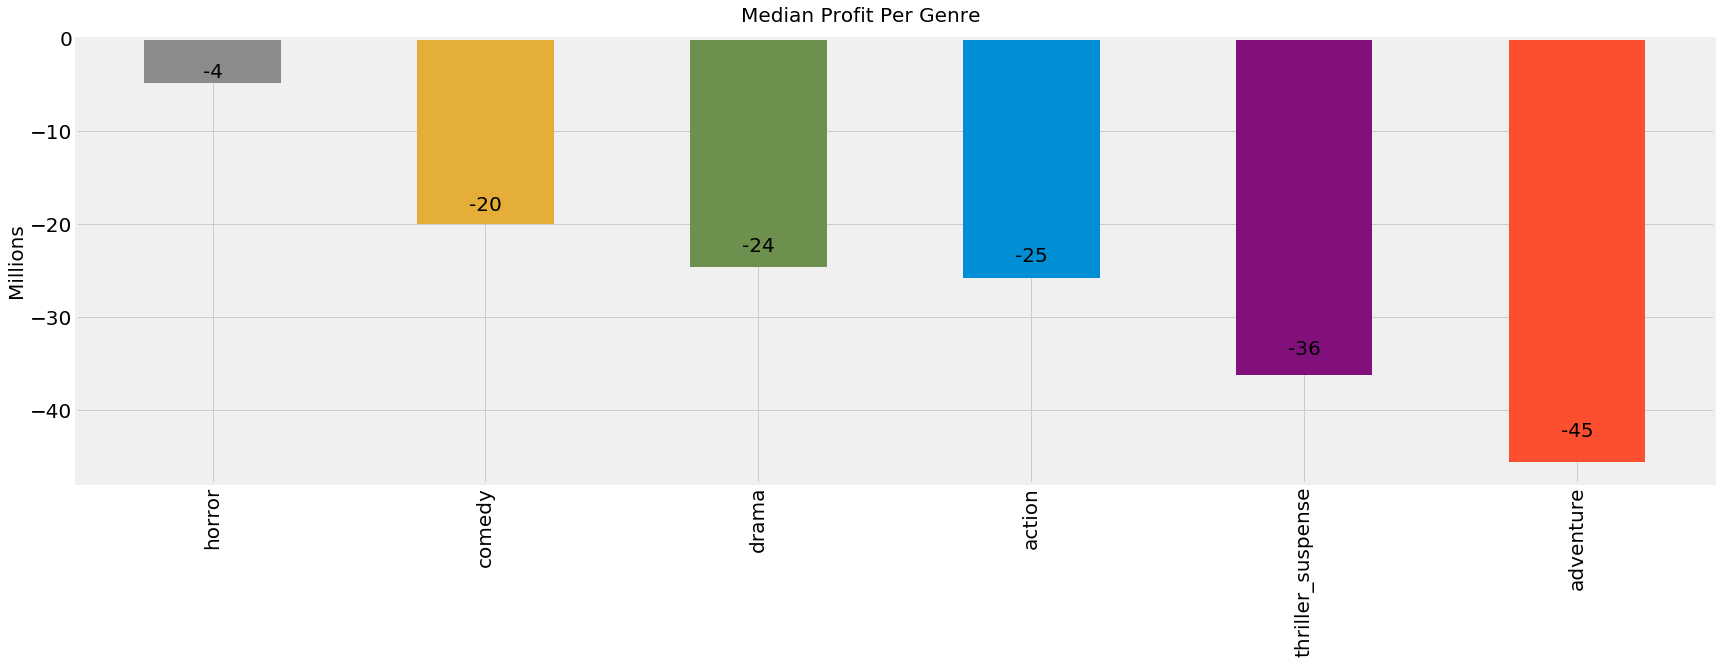

In [380]:
plot_summary_dataframe(summary=summary, sort_column='median_profit', plot_columns='median_profit', 
                       title='Median Profit Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Millions', num_decimals=0)

## Mean Profit

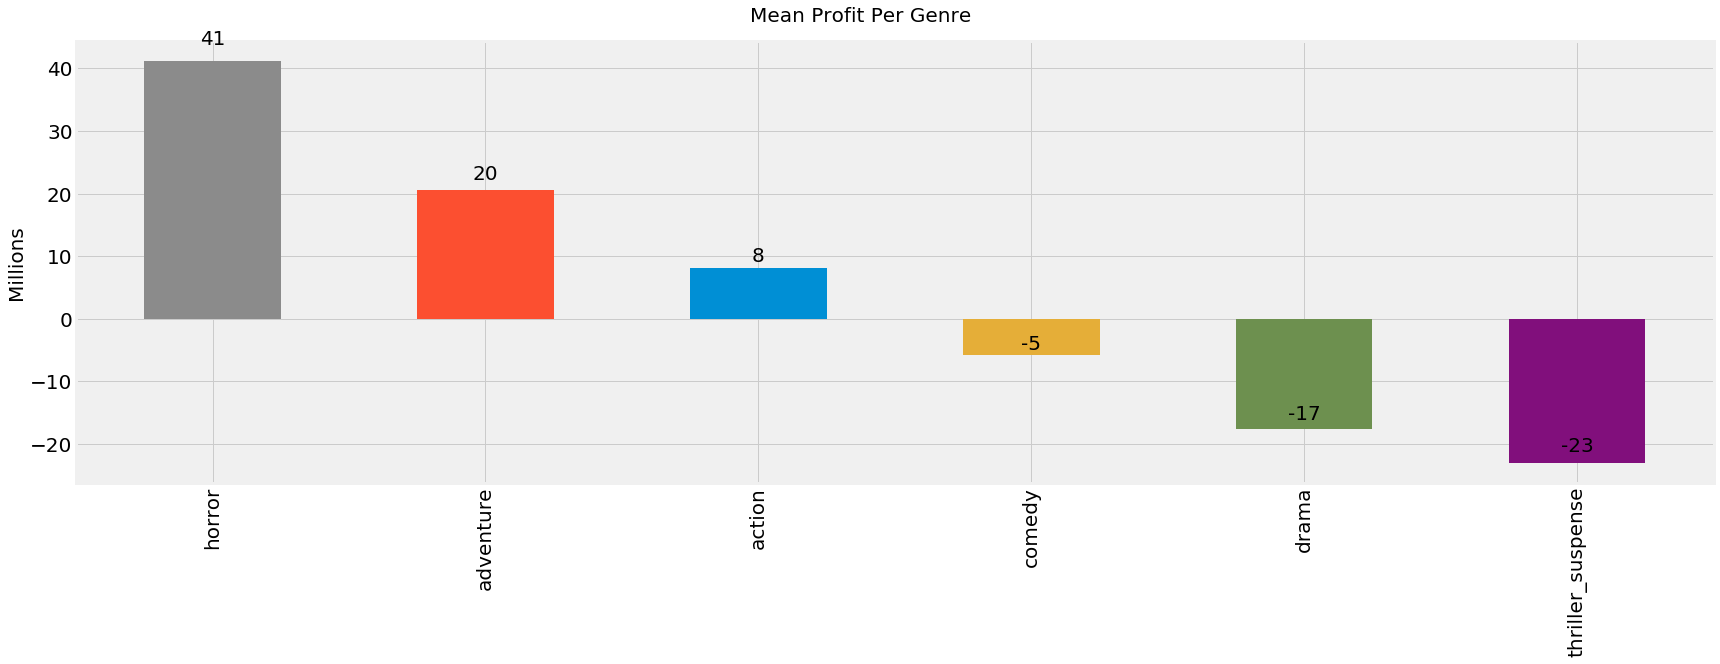

In [381]:
plot_summary_dataframe(summary=summary, sort_column='mean_profit', plot_columns='mean_profit', 
                       title='Mean Profit Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Millions', num_decimals=0)

## Summary

**Highest gross**
  - Action, Comedy, and Adventure have grossed the most money. 
  
**Profitability**
  - Horror, Adventure, and Action are the only genres that are net winners.
  
**Median profit**
  - No genre is a net winner in terms of median profit
  
**Mean profit**
  - Horror has the biggest boost from the right skew in terms of mean profitability.
  - Adventure and Action also go from net losers to net winners when looking at mean profits.
  
**Thoughts**
  - We are going to dig way deeper, but it's nice to get a sense of the overall big picture by genre.

# Deeper Dive On Worldwide Grosses

## Create custom function to help graphing by genre

In [29]:
# We want individual columns that hold a specific worldwide stat for each genre
# Since a movie can have multiple genres, right now we must isolate each genre with a groupby while looping over each genre
# If we create individual columns that contain information about a genre and a worldwide stat, it's easier to graph later
def worldwide_stat_by_genre(row, genre, stat):
    # Returns either 0 or the stat value due to boolean multiplication
    test = row[genre] * row[stat]
        
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test

# We want individual columns that store breakeven information for each genre
# Since we will be adding the entries in these columns (and using pd.DataFrame.mean()), we need to convert them to 1's and 0's
# Thus, we need to create a separate function from the 'worldwide_stat_by_genre' function
def test_for_breakeven_by_genre(row, genre, breakeven_column):
    if row[genre]:
        if row[breakeven_column]:
            return 1
        else:
            return 0
    else:
        return np.nan
    
# List of new columns to hold worldwide stats by genre
budget_columns = ['worldwide_budget_{}'.format(genre) for genre in genres]
gross_columns = ['worldwide_gross_{}'.format(genre) for genre in genres]
profit_columns = ['worldwide_profit_{}'.format(genre) for genre in genres]
breakeven_columns = ['worldwide_breakeven_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, budget_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'budget_adj'), axis=1)
    
for genre, col in zip(genres, gross_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'worldwide_adj'), axis=1)
    
for genre, col in zip(genres, profit_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'profit'), axis=1)
        
for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: test_for_breakeven_by_genre(x, genre, 'worldwide_breakeven'), axis=1)

## Mean and Median Gross

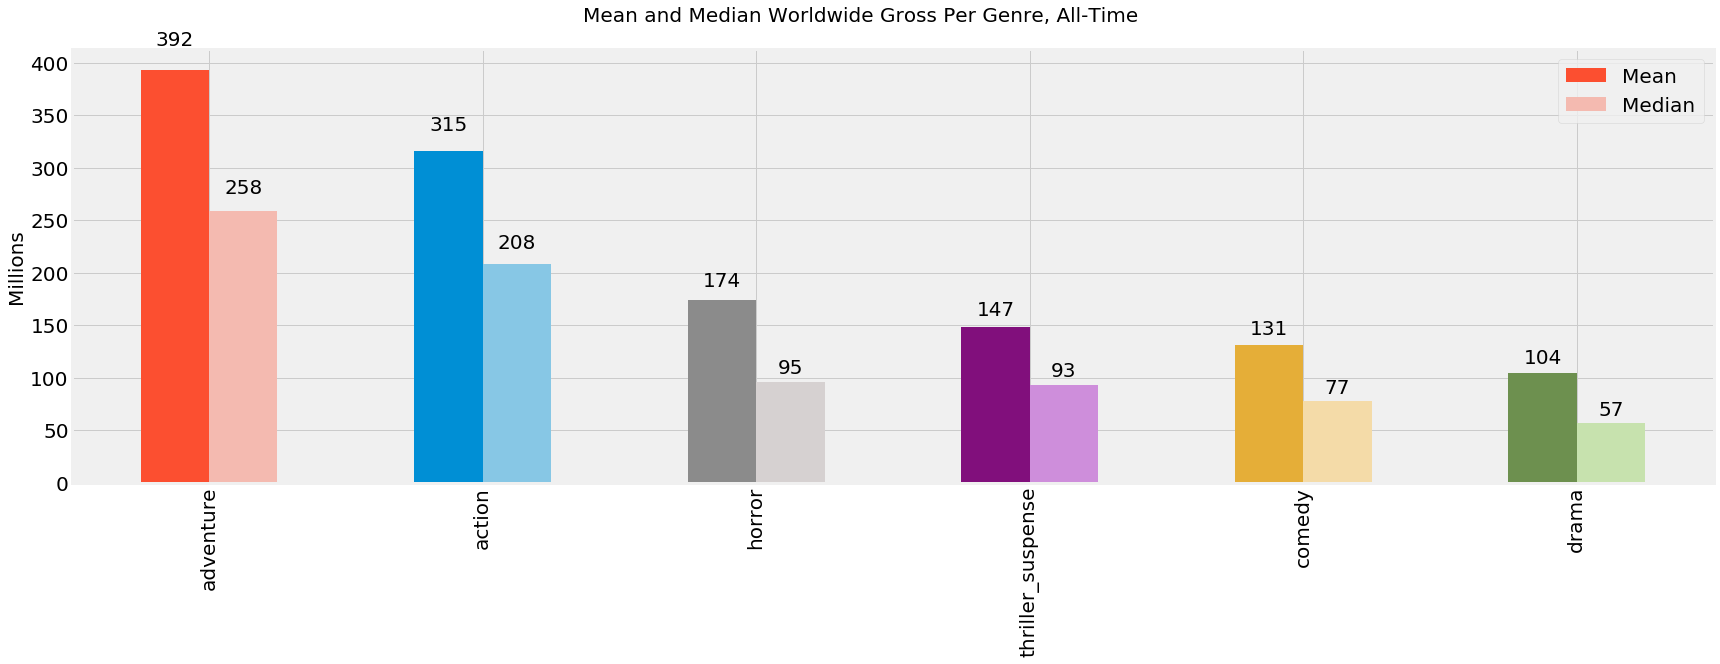

In [382]:
plot_summary_dataframe(summary=summary, sort_column='avg_gross', plot_columns=['avg_gross', 'median_gross'], 
                       title='Mean and Median Worldwide Gross Per Genre, All-Time', colors_needed=2, legend_needed=True, 
                       legend_text=['Mean', 'Median'], y_label='Millions', num_decimals=0)

## Gross Distributions

In [208]:
# Custom function to plot histograms of a stat by genre
def plot_histograms_by_genre(data, stat, title, genres, bins=10, colors_needed=1):
    figure, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(24,15))
    figure.suptitle(title, fontsize=20)

    sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]][stat].median() / 1000000)} for genre in genres], key=lambda k: k['amount'], reverse=True)
    genres_list = [item['genre'] for item in sorted_genres]
    color_list = generate_color_list(colors_needed=1, order_list=genres_list)

    for genre, axis, color in zip(genres_list, axes.flat, color_list):
        (data[data[genre]][stat] / 1000000).plot.hist(bins=bins, ax=axis, color=color)
        axis.set_title(genre, fontsize=20)
        axis.axvline(data[data[genre]][stat].median() / 1000000, color='k', linewidth=1)
        axis.axvline(data[data[genre]][stat].mean() / 1000000, color='r', linewidth=1)
        axis.legend(['Median: {:.1f} million'.format(data[data[genre]][stat].median() / 1000000), 'Mean: {:.1f} million'.format(data[data[genre]][stat].mean() / 1000000)], fontsize=15)
        axis.set_xlabel('Millions', fontsize=20)

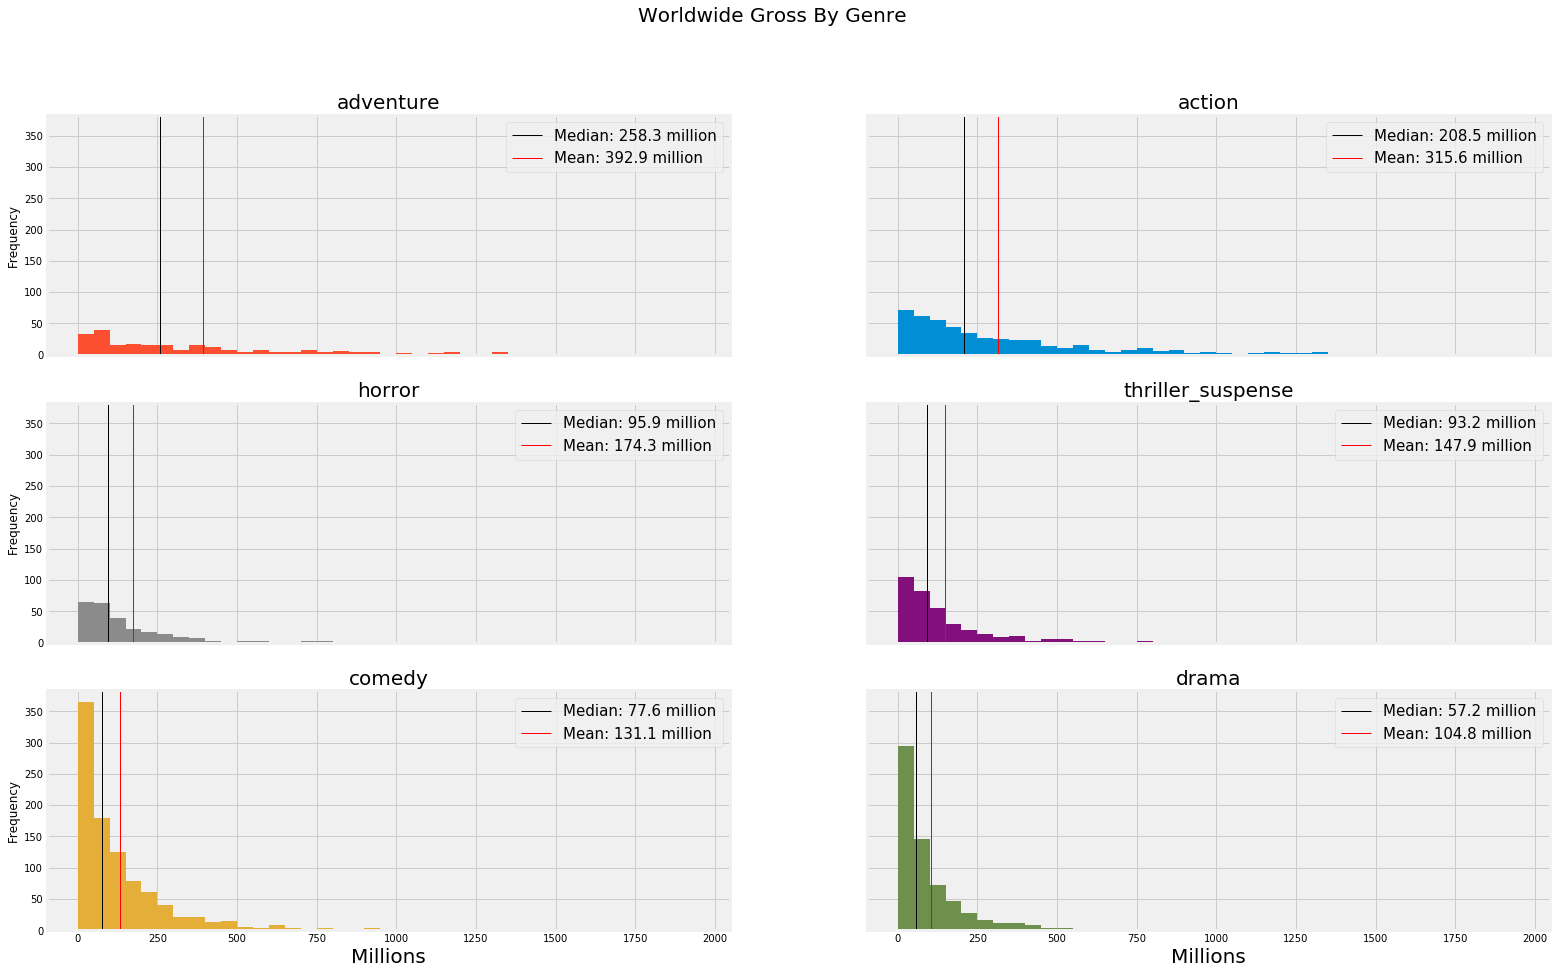

In [383]:
plot_histograms_by_genre(data=data, stat='worldwide_adj', title='Worldwide Gross By Genre', 
                         genres=genres, bins=range(0, 2000, 50), colors_needed=1)

## Quick Takeaways

**Skew**
  - Even subdivided by genre, the gross distributions are all right-skewed.
  
**Mean and median**
  - Mean and median gross for Adventure and Action are far higher than any other genre
  - Adventure's median gross is approximately 2.6 times as large as the third place median gross, Horror.
  - The most common gross amount in every genre except Adventure is $0 - \\$50 milllion
  
**Action/Adventure**
  - These two genres have the biggest spread between mean and median gross
  - Something to keep in mind is the frequency of movies labeled as Action/Adventure. In our analysis, such movies would count towards both Action and Adventure movies. (We are assigning movies to every genre they have.) 
  - Since both of these genres are big on spectacle, they tend to be more likely to be blockbuster material 
  - We might have a situation where duplicate entries in both columns are artificially boosting their totals
  - Let's investigate this a little further  

## Action/Adventure

In [32]:
print('Median gross of Action/Adventure movies: ${:.1f} million'.format(data[data['genres_mojo'] == 'Action / Adventure']['worldwide_adj'].median() / 1000000))
print('Median gross of Action (without Adventure component) movies: ${:.1f} million'.format(data[(data['genres_mojo'].str.contains('Action', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['worldwide_adj'].median() / 1000000))
print('Median gross of Adventure (without Action component) movies: ${:.1f} million'.format(data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['worldwide_adj'].median() / 1000000))

Median gross of Action/Adventure movies: $437.8 million
Median gross of Action (without Adventure component) movies: $173.2 million
Median gross of Adventure (without Action component) movies: $156.8 million


In [33]:
def action_adventure_stats(genre, stat, title):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle(title, fontsize=20)

    median_with_action_adventure = data[data[genre]][stat].median() / 1000000
    median_without_action_adventure = data[(data[genre]) & (data['genres_mojo'] != 'Action / Adventure')][stat].median() / 1000000

    grp = data[data[genre]].groupby('genres_mojo')[stat].median().sort_values(ascending=False) / 1000000

    grp.plot(kind='bar', ax=axis, color=genres_dict[genre]['color1'])
    axis.axhline(median_with_action_adventure, color='k', linewidth=1)
    axis.axhline(median_without_action_adventure, color='r', linewidth=1)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20);
    axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_action_adventure),
                 'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_action_adventure)], loc='best', fontsize=20)
    autolabel(axis)

### Action

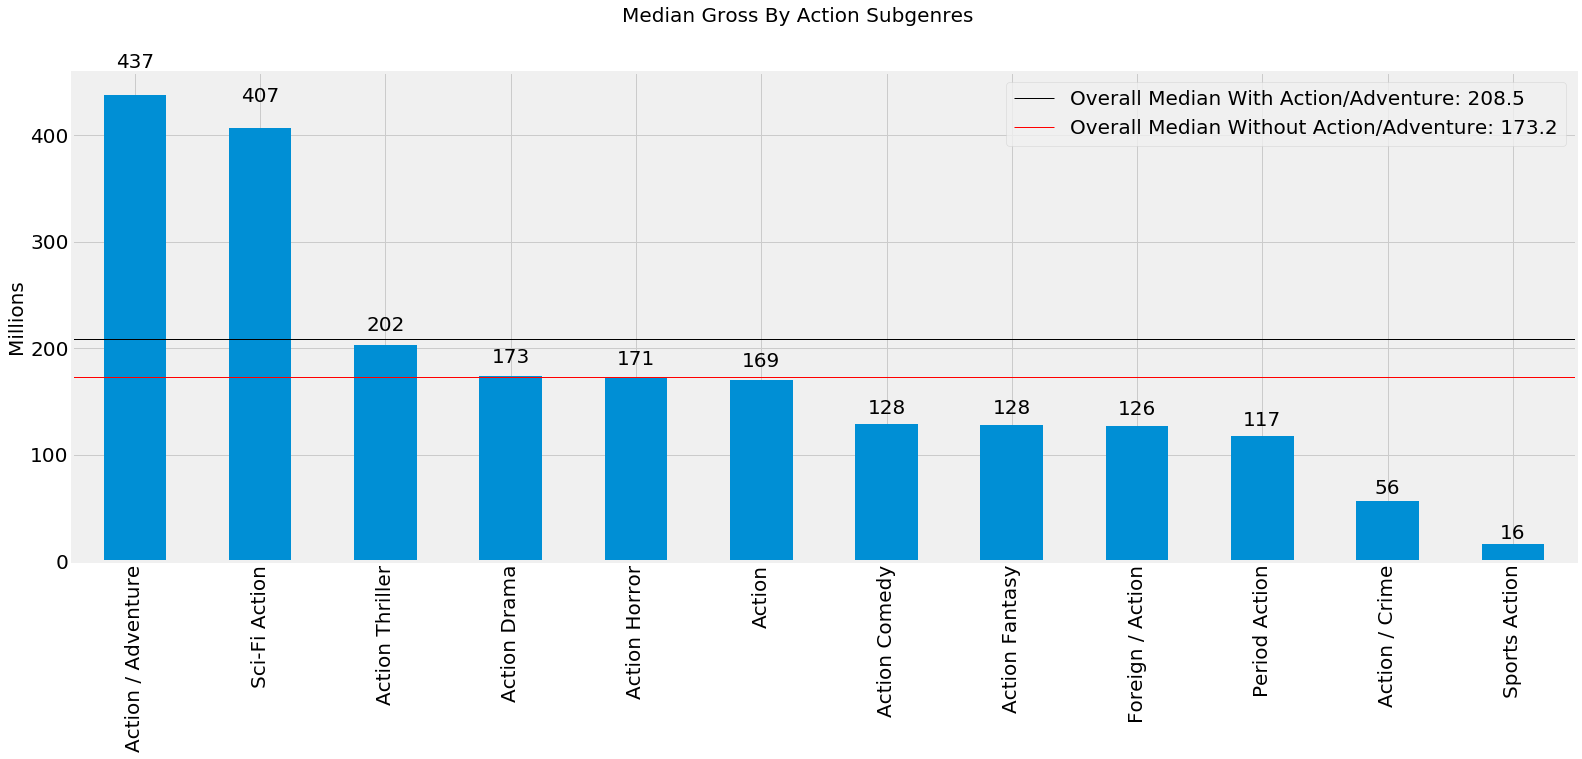

In [210]:
action_adventure_stats(genre='action', stat='worldwide_adj', title='Median Gross By Action Subgenres')

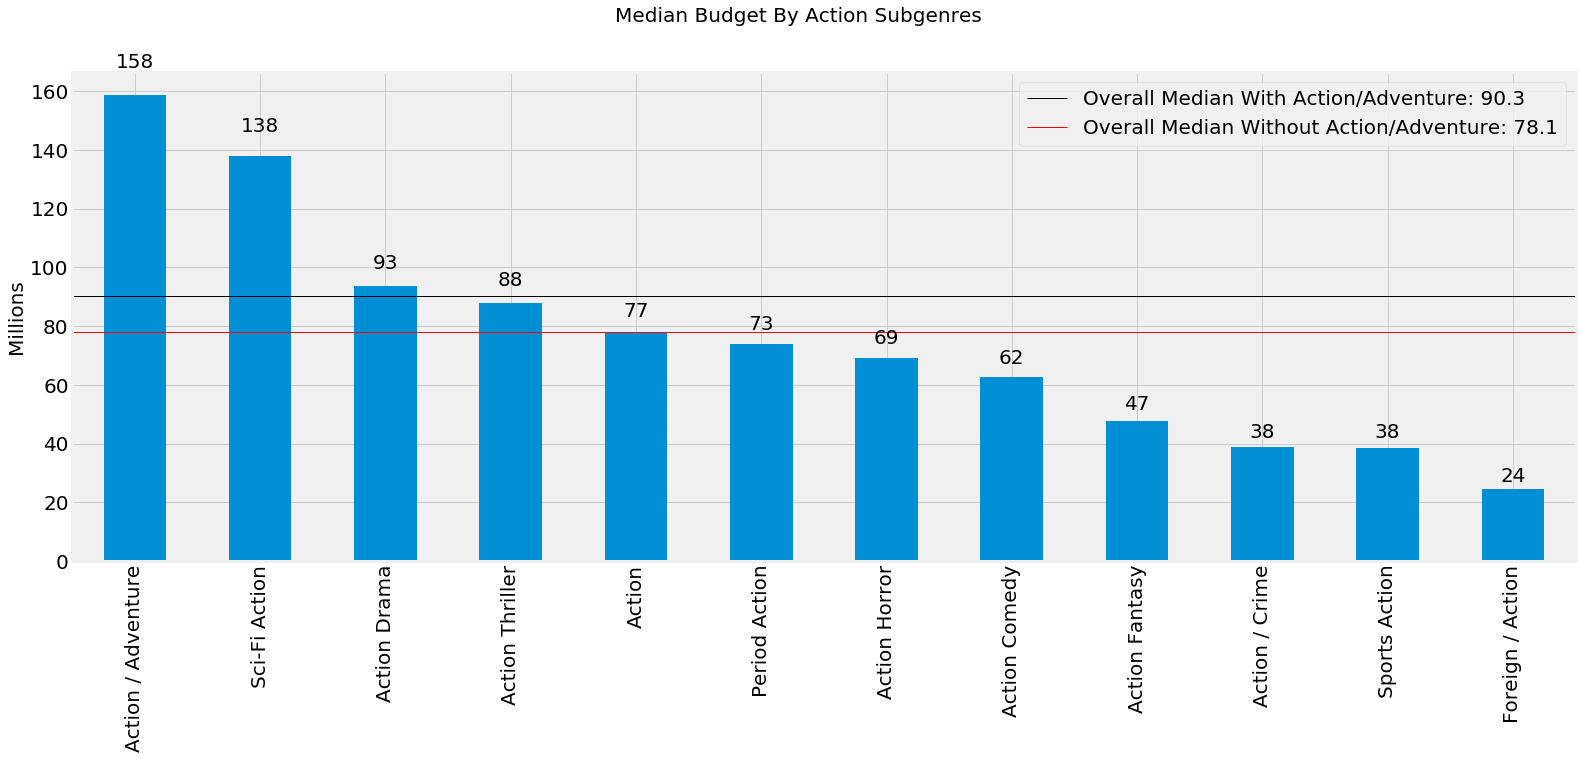

In [211]:
action_adventure_stats(genre='action', stat='budget_adj', title='Median Budget By Action Subgenres')

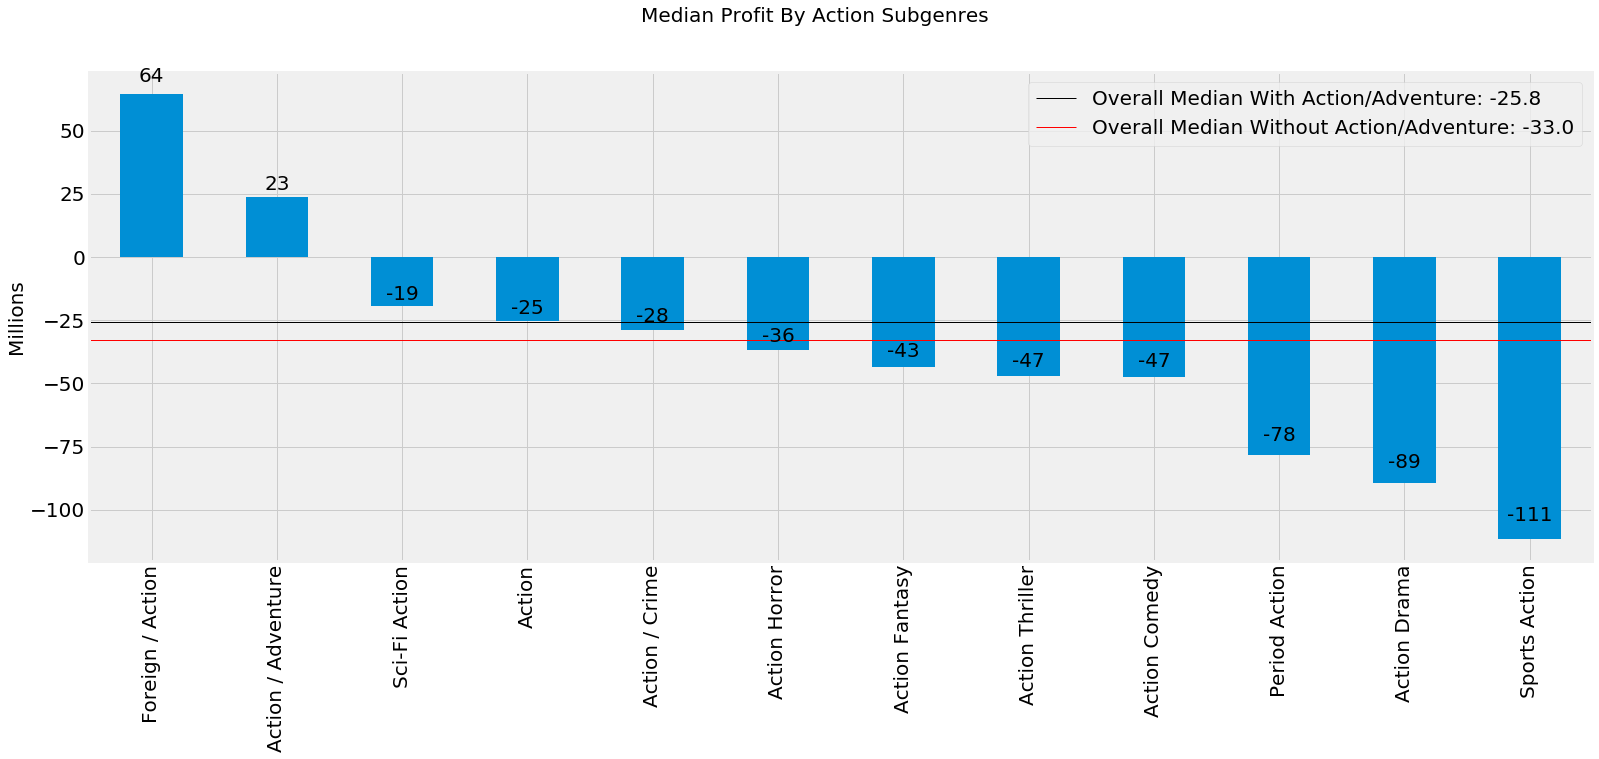

In [212]:
action_adventure_stats(genre='action', stat='profit', title='Median Profit By Action Subgenres')

### Quick Takeaways

  - Action/Adventure and Sci-Fi Action are the highest grossing subgenres. They also carry the highest production budgets.
  - Only Foreign/Action and Action/Adventure have a positive median profit
  - Since Action/Adventure is such a huge grossing subgenre, it boosts the median gross for the entire genre by about \\$34 million.

### Adventure

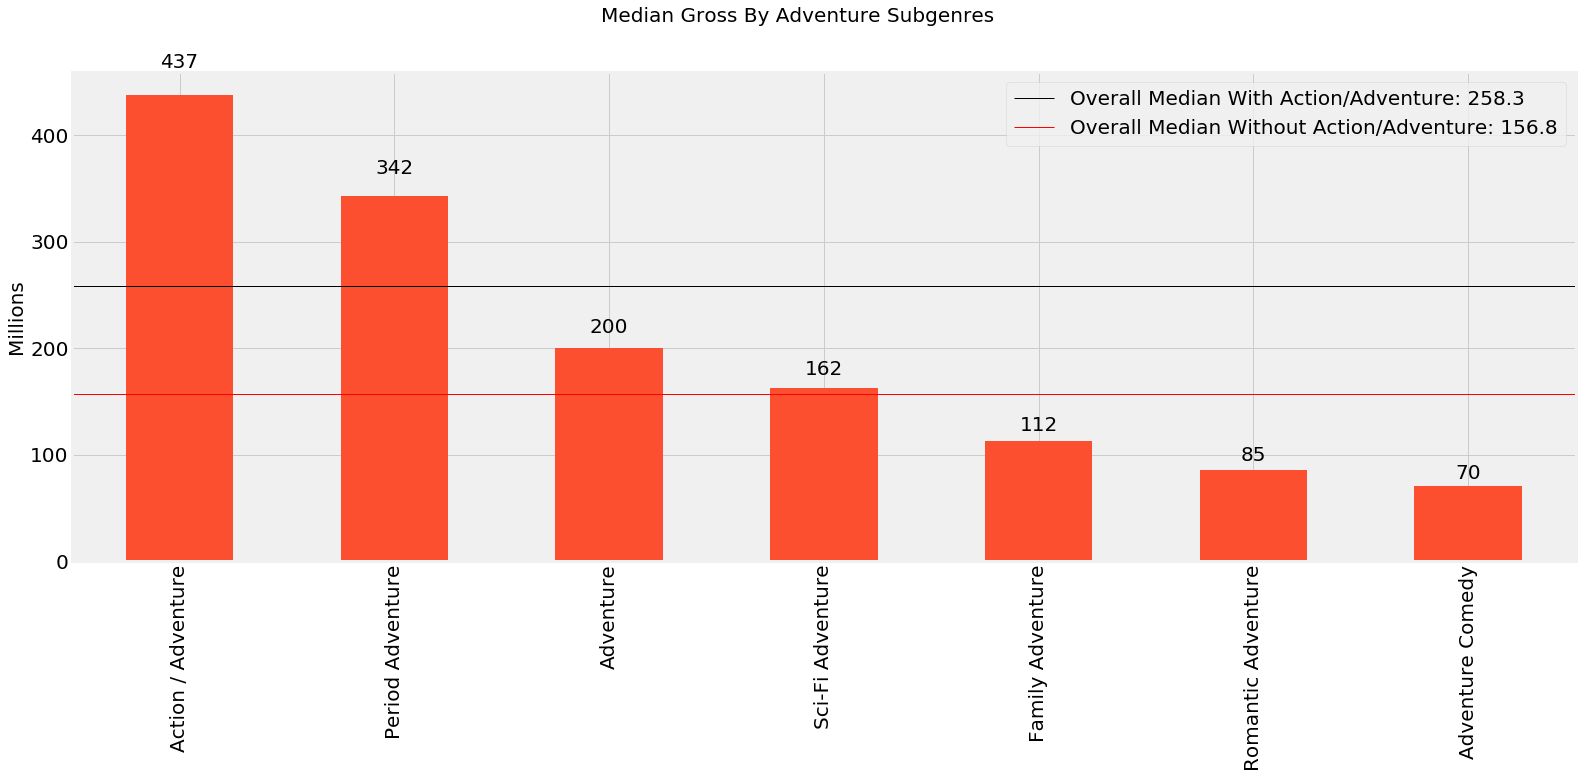

In [213]:
action_adventure_stats(genre='adventure', stat='worldwide_adj', title='Median Gross By Adventure Subgenres')

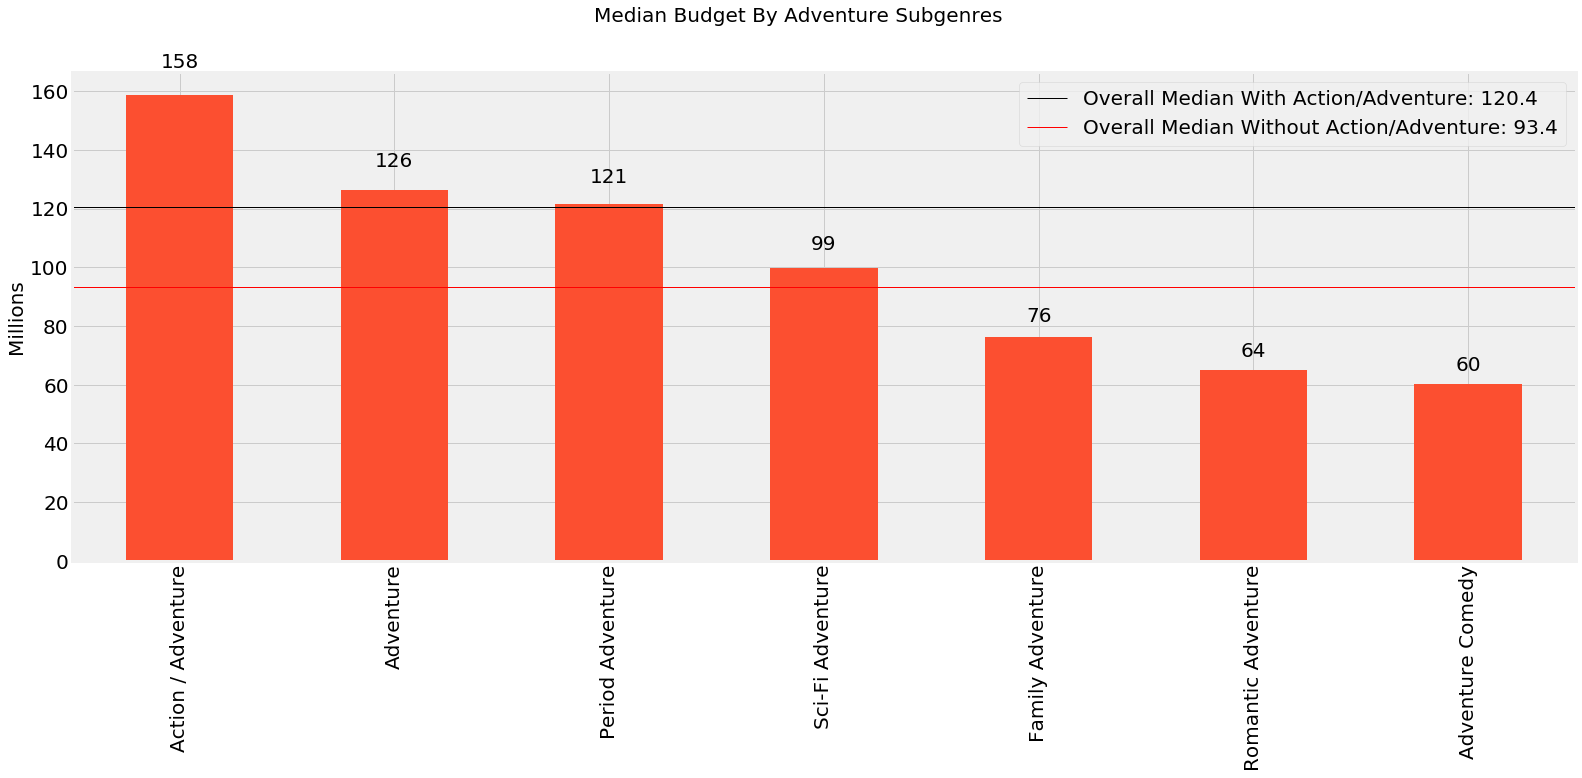

In [214]:
action_adventure_stats(genre='adventure', stat='budget_adj', title='Median Budget By Adventure Subgenres')

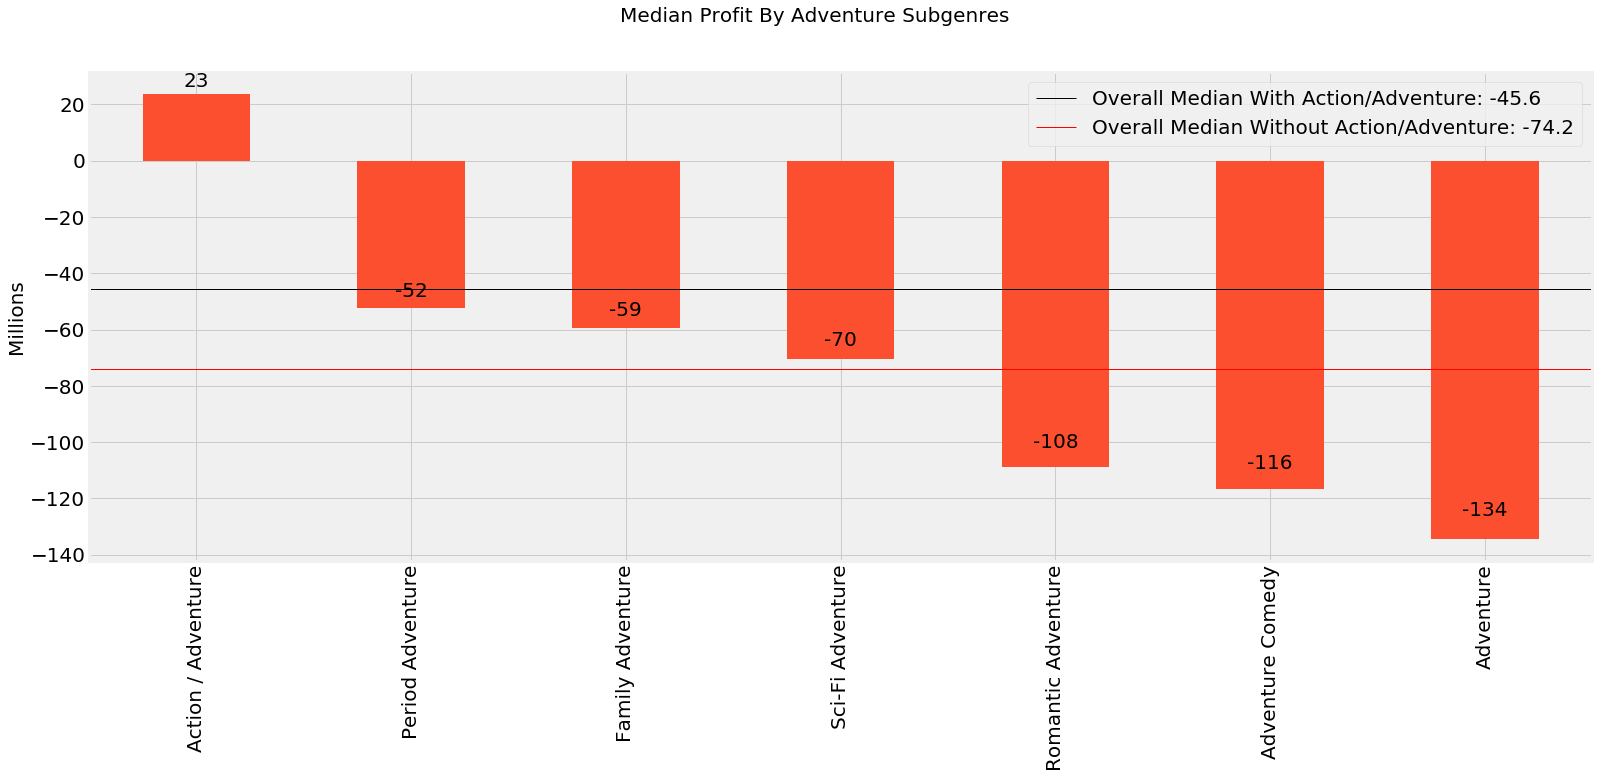

In [215]:
action_adventure_stats(genre='adventure', stat='profit', title='Median Profit By Adventure Subgenres')

### Quick Takeaways

  - Action/Adventure is the highest grossing and most expensive subgenre.
  - Period Adventure is the second highest grossing subgenre and third most expensive.
  - Only Action/Adventure has a positive median profit
  - The Action/Adventure subgenre boosts the median gross for the entire genre by about \\$100 million

### Summary

**Action/Adventure is the culprit!**
  - Action/Adventure movies are so high-grossing that they are boosting the median stats of Action and Adventure movies by a big margin
  
**Gross**
  - Action's median gross increases about \\$34 million
  - Adventure's median gross increases about \\$100 million
    
**Budget**
  - Action's median budget increases about \\$12 million
  - Adventure's median budget increases about \\$27 million
    
**Profit**
  - Action's median profit increases about \\$7 million
  - Adventure's median profit increases about \\$29 million
    
**Keep it in the back of our minds**
  - We should be aware this one subgenre has that much impact on our otherwise separate genres, Action and Adventure

# Deeper Dive on Production Budgets

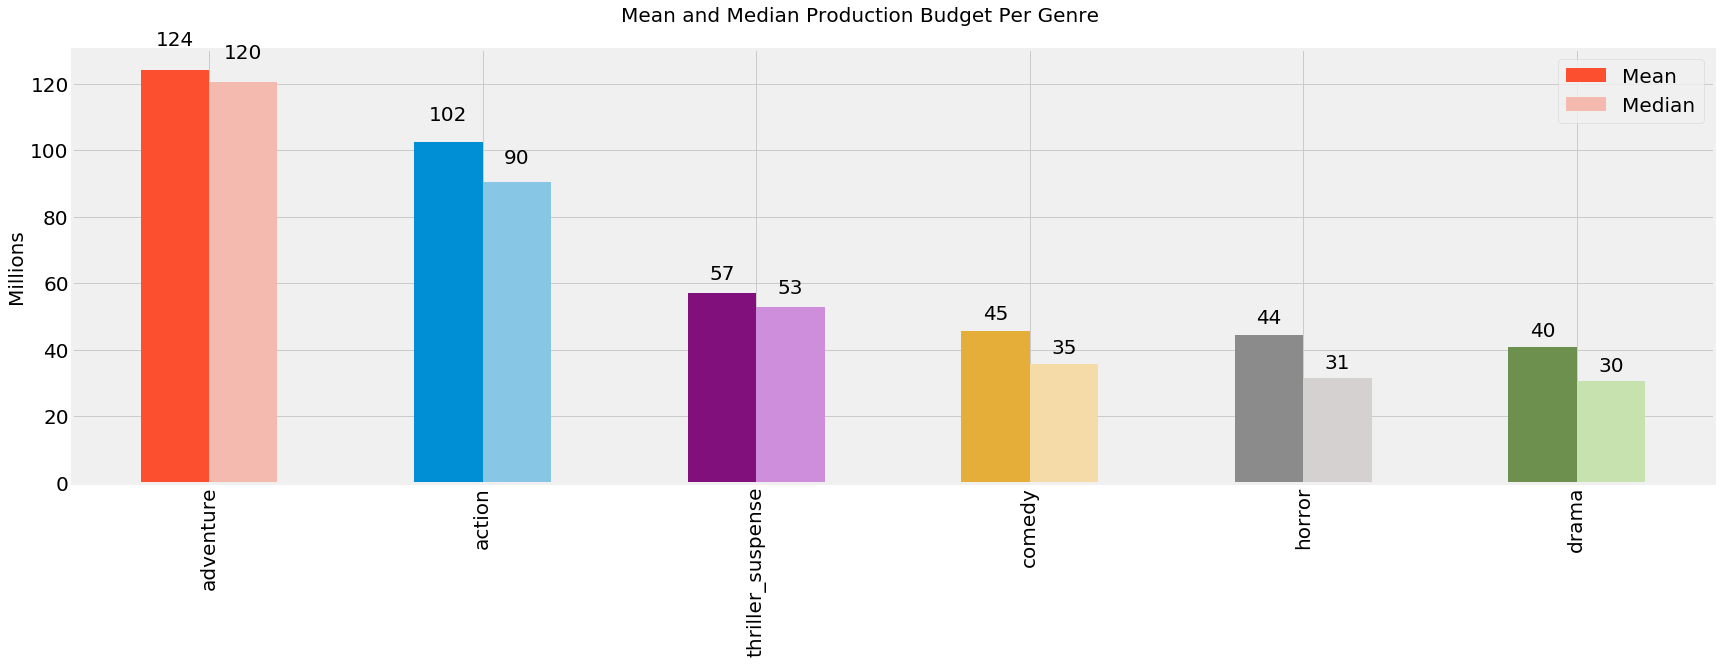

In [216]:
plot_summary_dataframe(summary=summary, sort_column='avg_budget', plot_columns=['avg_budget', 'median_budget'], 
                       title='Mean and Median Production Budget Per Genre', colors_needed=2, legend_needed=True, 
                       legend_text=['Mean', 'Median'], num_decimals=0)

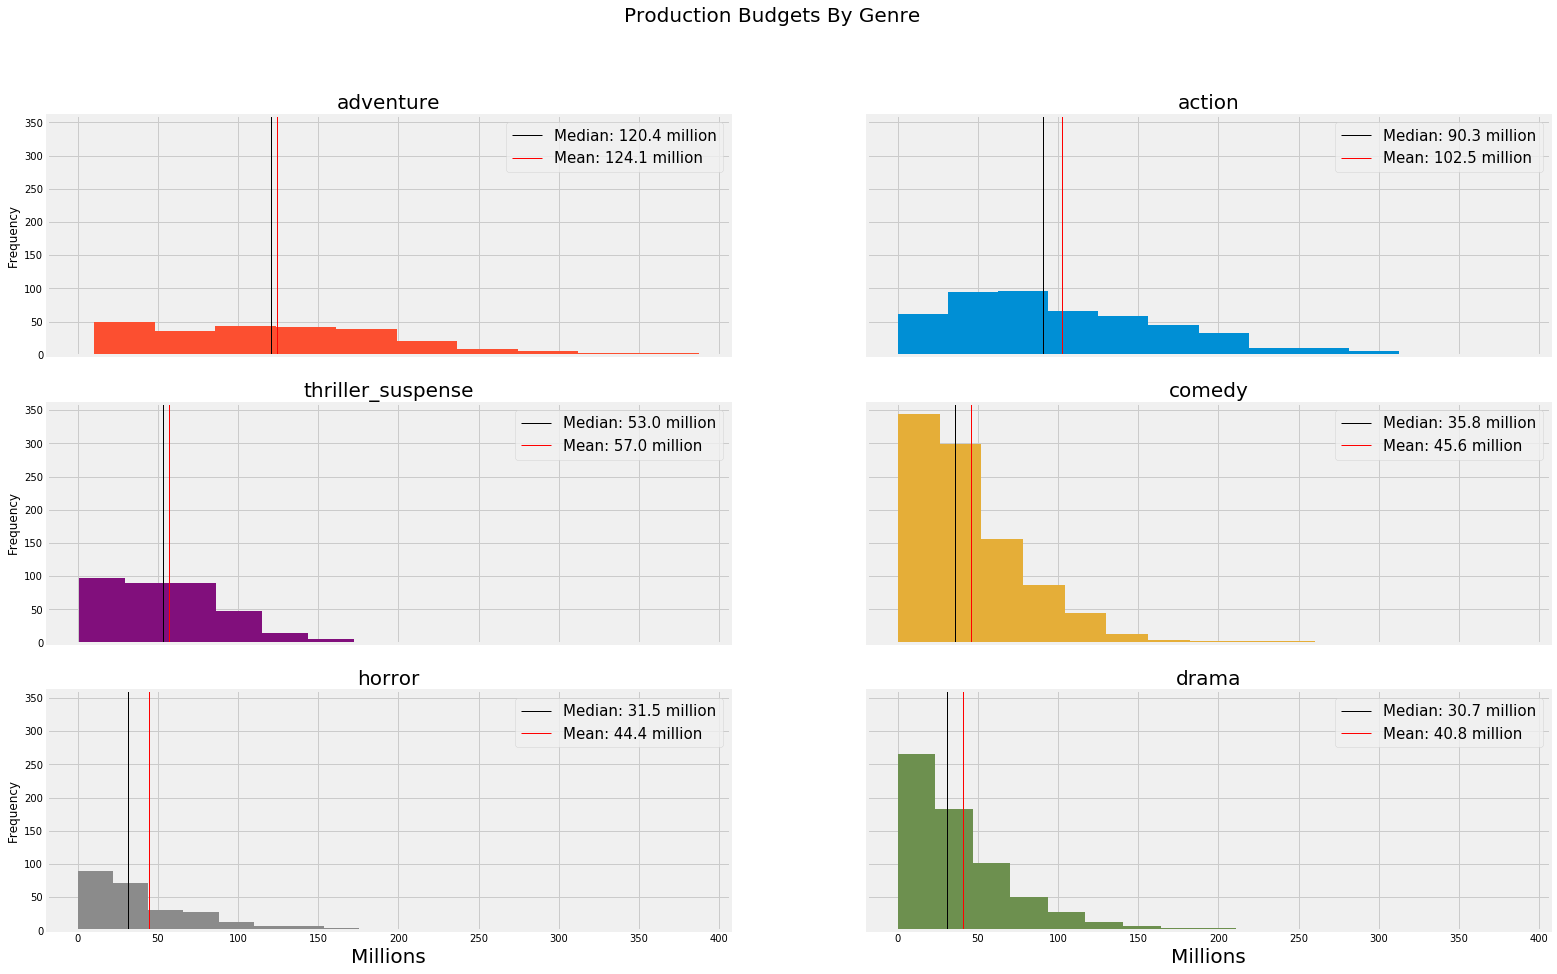

In [207]:
plot_histograms_by_genre(data=data, stat='budget_adj', title='Production Budgets By Genre', 
                         genres=genres, bins=10, colors_needed=1)

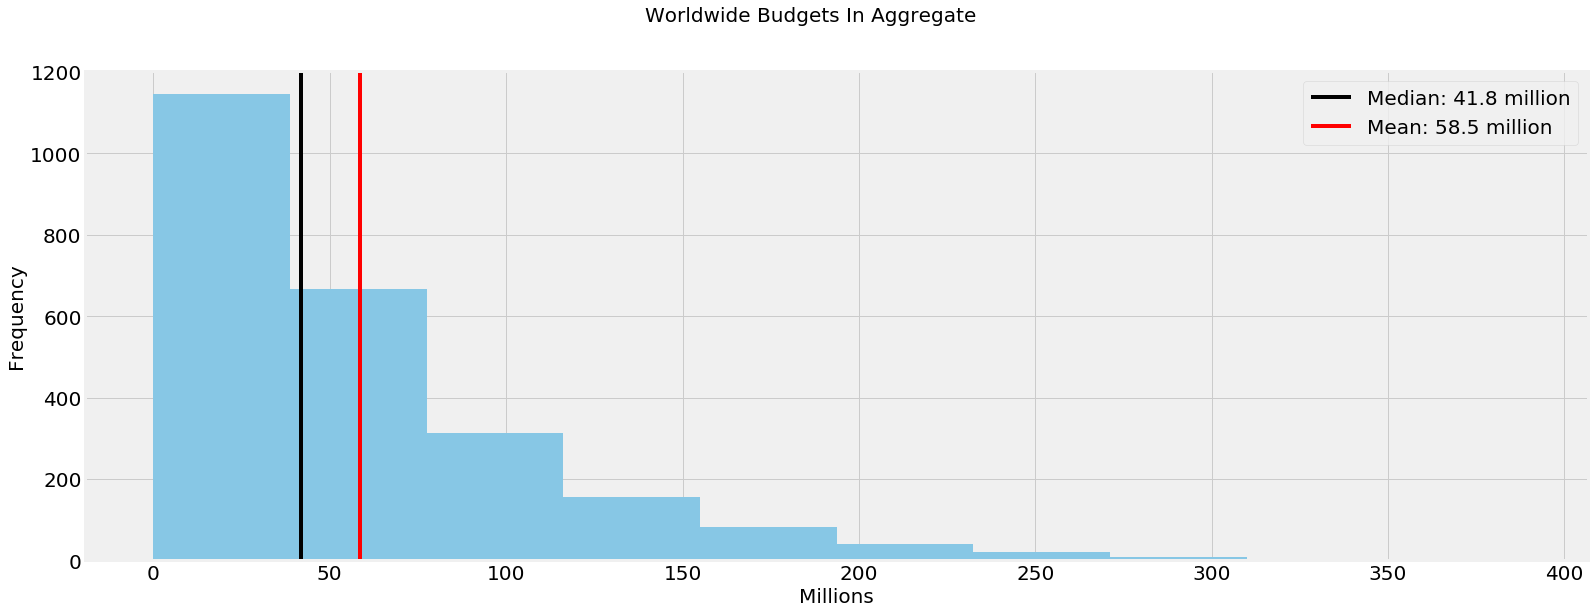

In [217]:
plot_aggregate_histogram(data=data, stat='budget_adj', title='Worldwide Budgets In Aggregate', 
                         bins=10, color=genres_dict['action']['color2'])

## Quick Takeaways

**Median production budget**
  - Adventure and Action have by far the largest median budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Adventure is 2.3 times the median budget of the third place genre, Thriller/Suspense
  - Comedy, Horror, and Drama all have very similar, low median production budgets 
  - Production budgets are also right-skewed, but they have far less skew than worldwide grosses
  
**Low budgets**
  - We can tell by the median production budget of 41.8 million that the majority of movies produced have a relatively small budget
  - Blockbusters (those costing 200-300 million dollars) are the exception, rather than the rule
  - Something to keep in mind is if this trend has changed in the past decade

# Deeper Dive On Profits

## Boxplot To The Rescue!

In [219]:
def plot_boxplot(data, genres, title, columns, starting_year=1970):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))
    figure.suptitle(title, fontsize=20, y=1.05)

    data[data['release_year'] >= starting_year][columns].plot(kind='box', ax=axis)
    axis.set_xticklabels(genres)
    axis.tick_params(labelsize=20)
    axis.axhline(0, color='k', linewidth=1)

    plt.tight_layout()

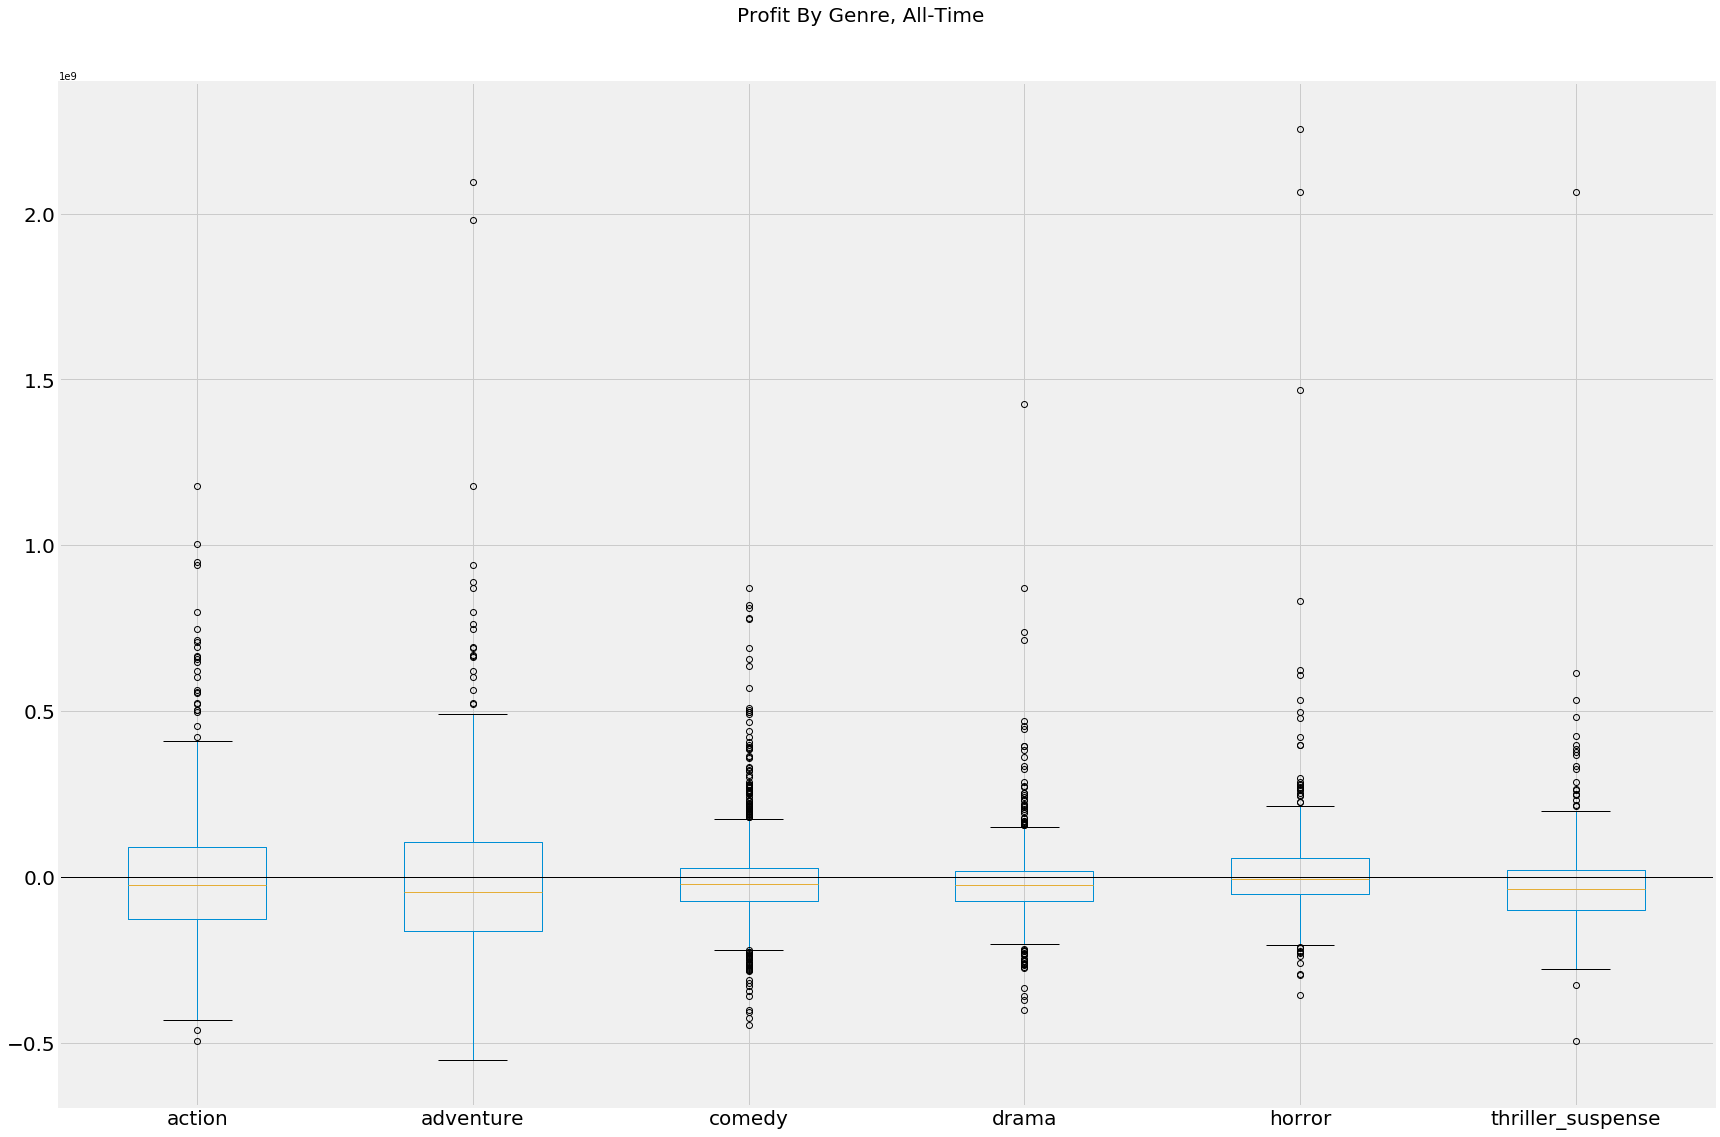

In [222]:
plot_boxplot(data=data, genres=genres, title='Profit By Genre, All-Time', columns=profit_columns, starting_year=1970)

## Quick Takeaways

**Long right tails and negative medians!**
  - All genres have negative median profit
  - All genres have those glorious right tails, the mega-super-duper-blockbuster hits
  - Comedy, Drama, and Horror have many mega-losers

## Median Profits By Subgenre

In [352]:
def profit_by_subgenres(data, genres, aggregation_function='median', apply_function=lambda x: x / 1000000):
    sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]]['profit'].agg(aggregation_function))} for genre in genres], key=lambda k: k['amount'], reverse=True)
    genres_list = [item['genre'] for item in sorted_genres]
    color_list = generate_color_list(colors_needed=1, order_list=genres_list)
    
    figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 54))
      
    for genre, color, axis in zip(genres_list, color_list, axes.flat): 
        overall_stat = data[data[genre]]['profit'].agg(aggregation_function) / 1000000
    
        (data[data[genre]].groupby('genres_mojo')['profit'].agg(aggregation_function).apply(apply_function).sort_values(ascending=False)).plot(kind='bar', ax=axis, color=color)

        axis.axhline(overall_stat, color='k', linewidth=1)
        axis.tick_params(labelsize=20)
        axis.set_xlabel('')
        axis.set_ylabel('Millions', fontsize=20)
        axis.set_title('{} Profit By {} Subgenres'.format(aggregation_function.title(), genre.title()), fontsize=20, y=1.02)
        axis.legend(['Overall {}: {:.1f}'.format(aggregation_function.title(), overall_stat)], loc=3, fontsize=20)
        autolabel(axis)
        
    plt.tight_layout()

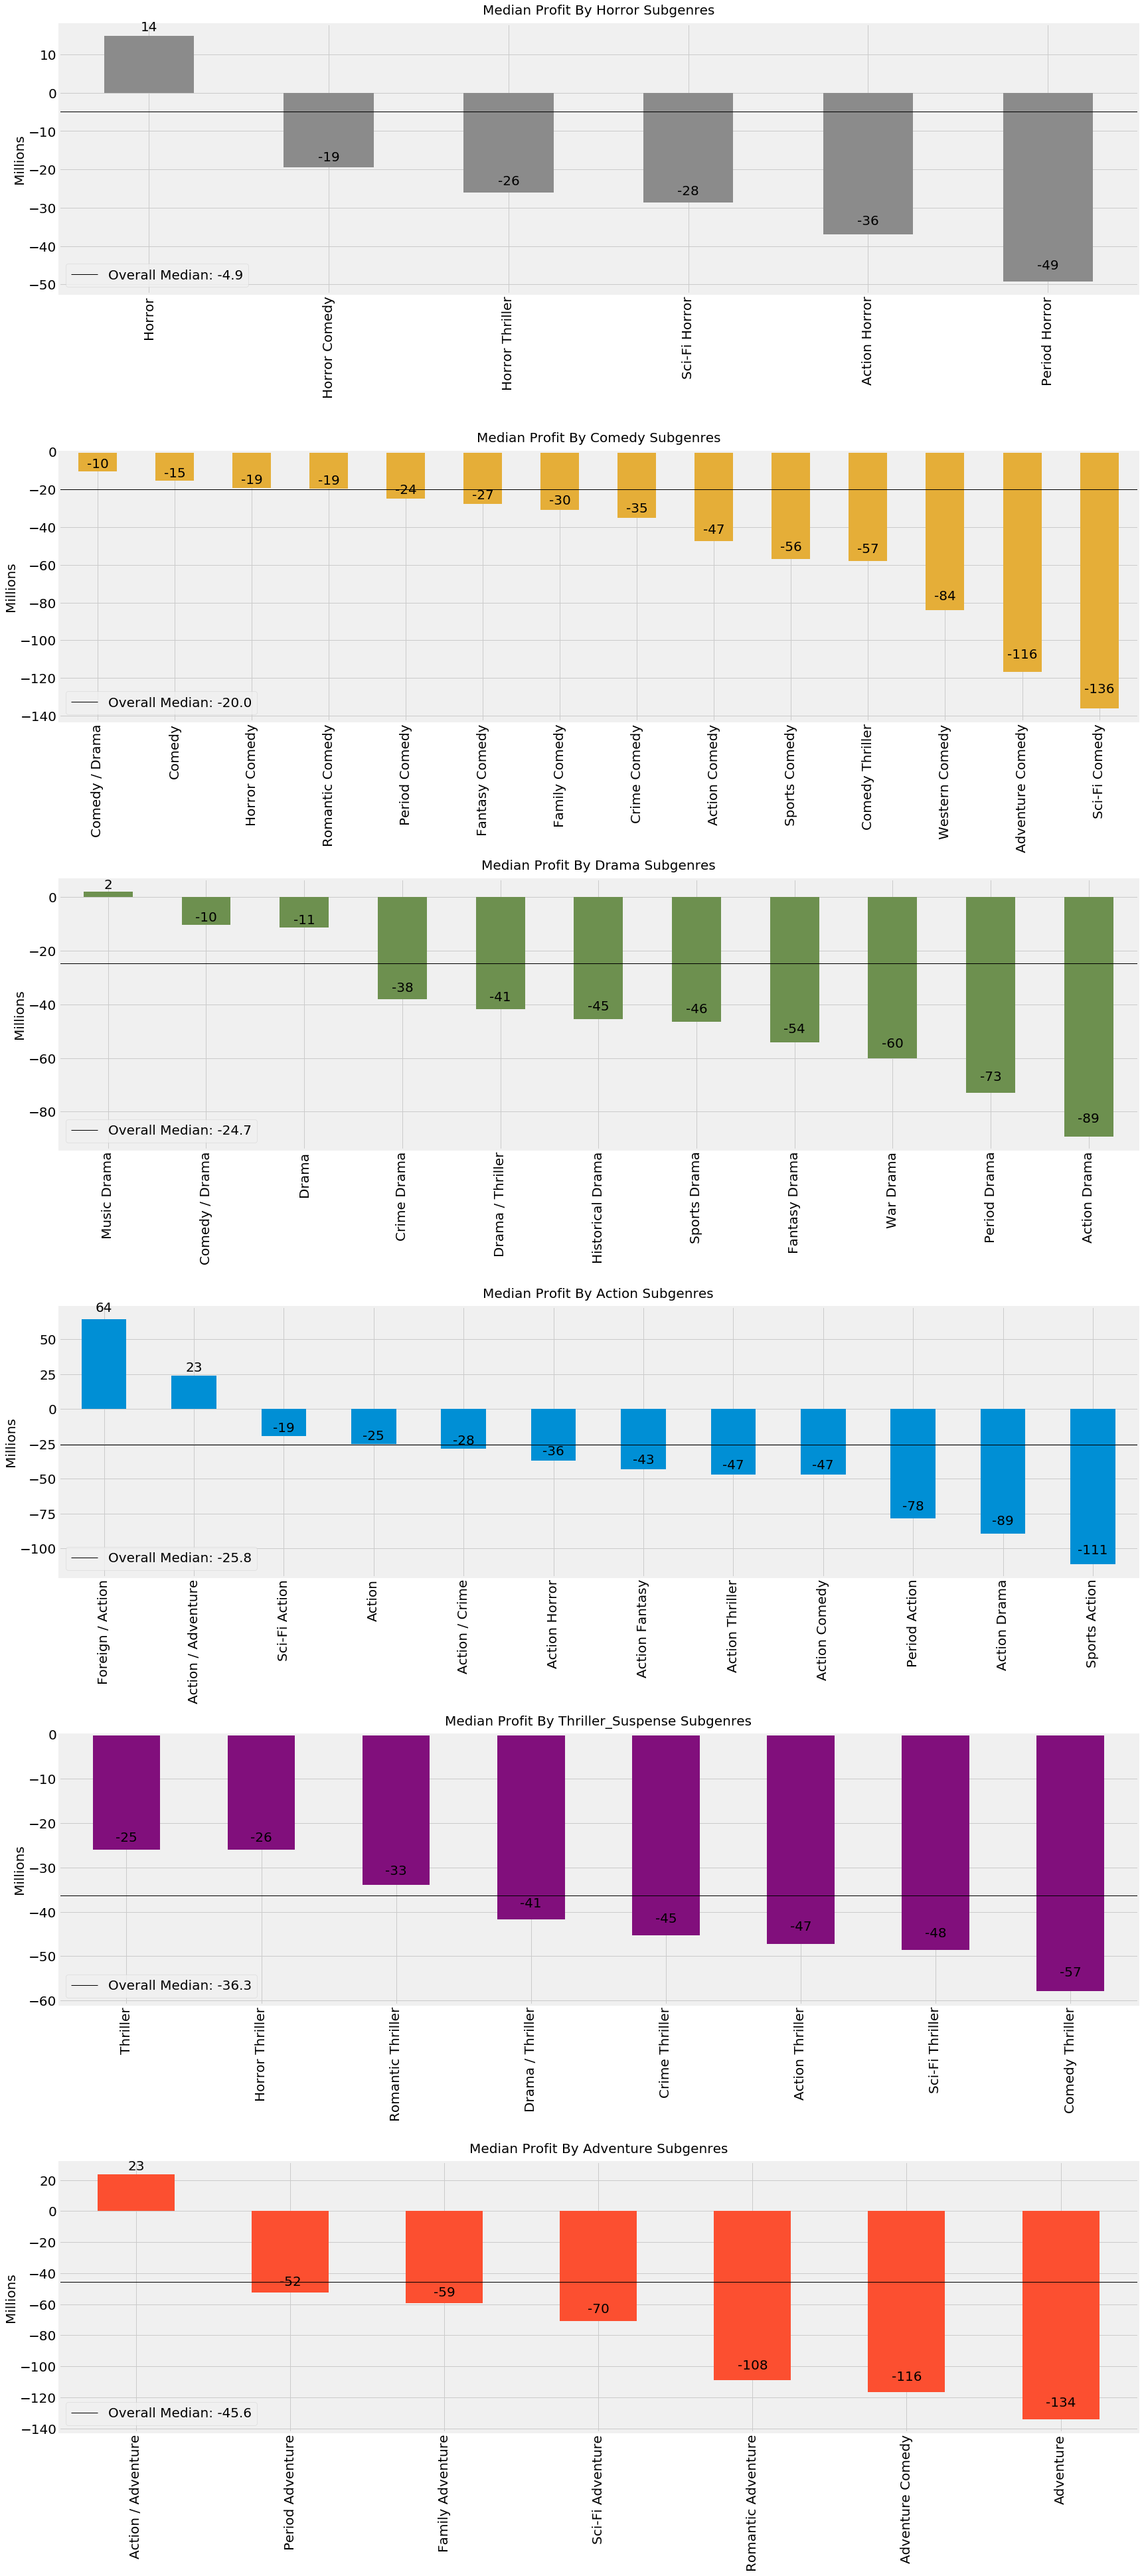

In [354]:
profit_by_subgenres(data=data, genres=genres, aggregation_function='median', apply_function=lambda x: x / 1000000)

## Quick Takeaways

**Movies are a tough business**
  - Just looking at the aggregate movie data we have, it seems like almost no genre is a safe bet.
  - No genre (when including all its subgenres) has a positive median profitability.
  - The only subgenres with a positive median profit are (in descending order) Foreign/Action, Action/Adventure, Horror, and Music Drama.

## Mean Profits By Subgenre

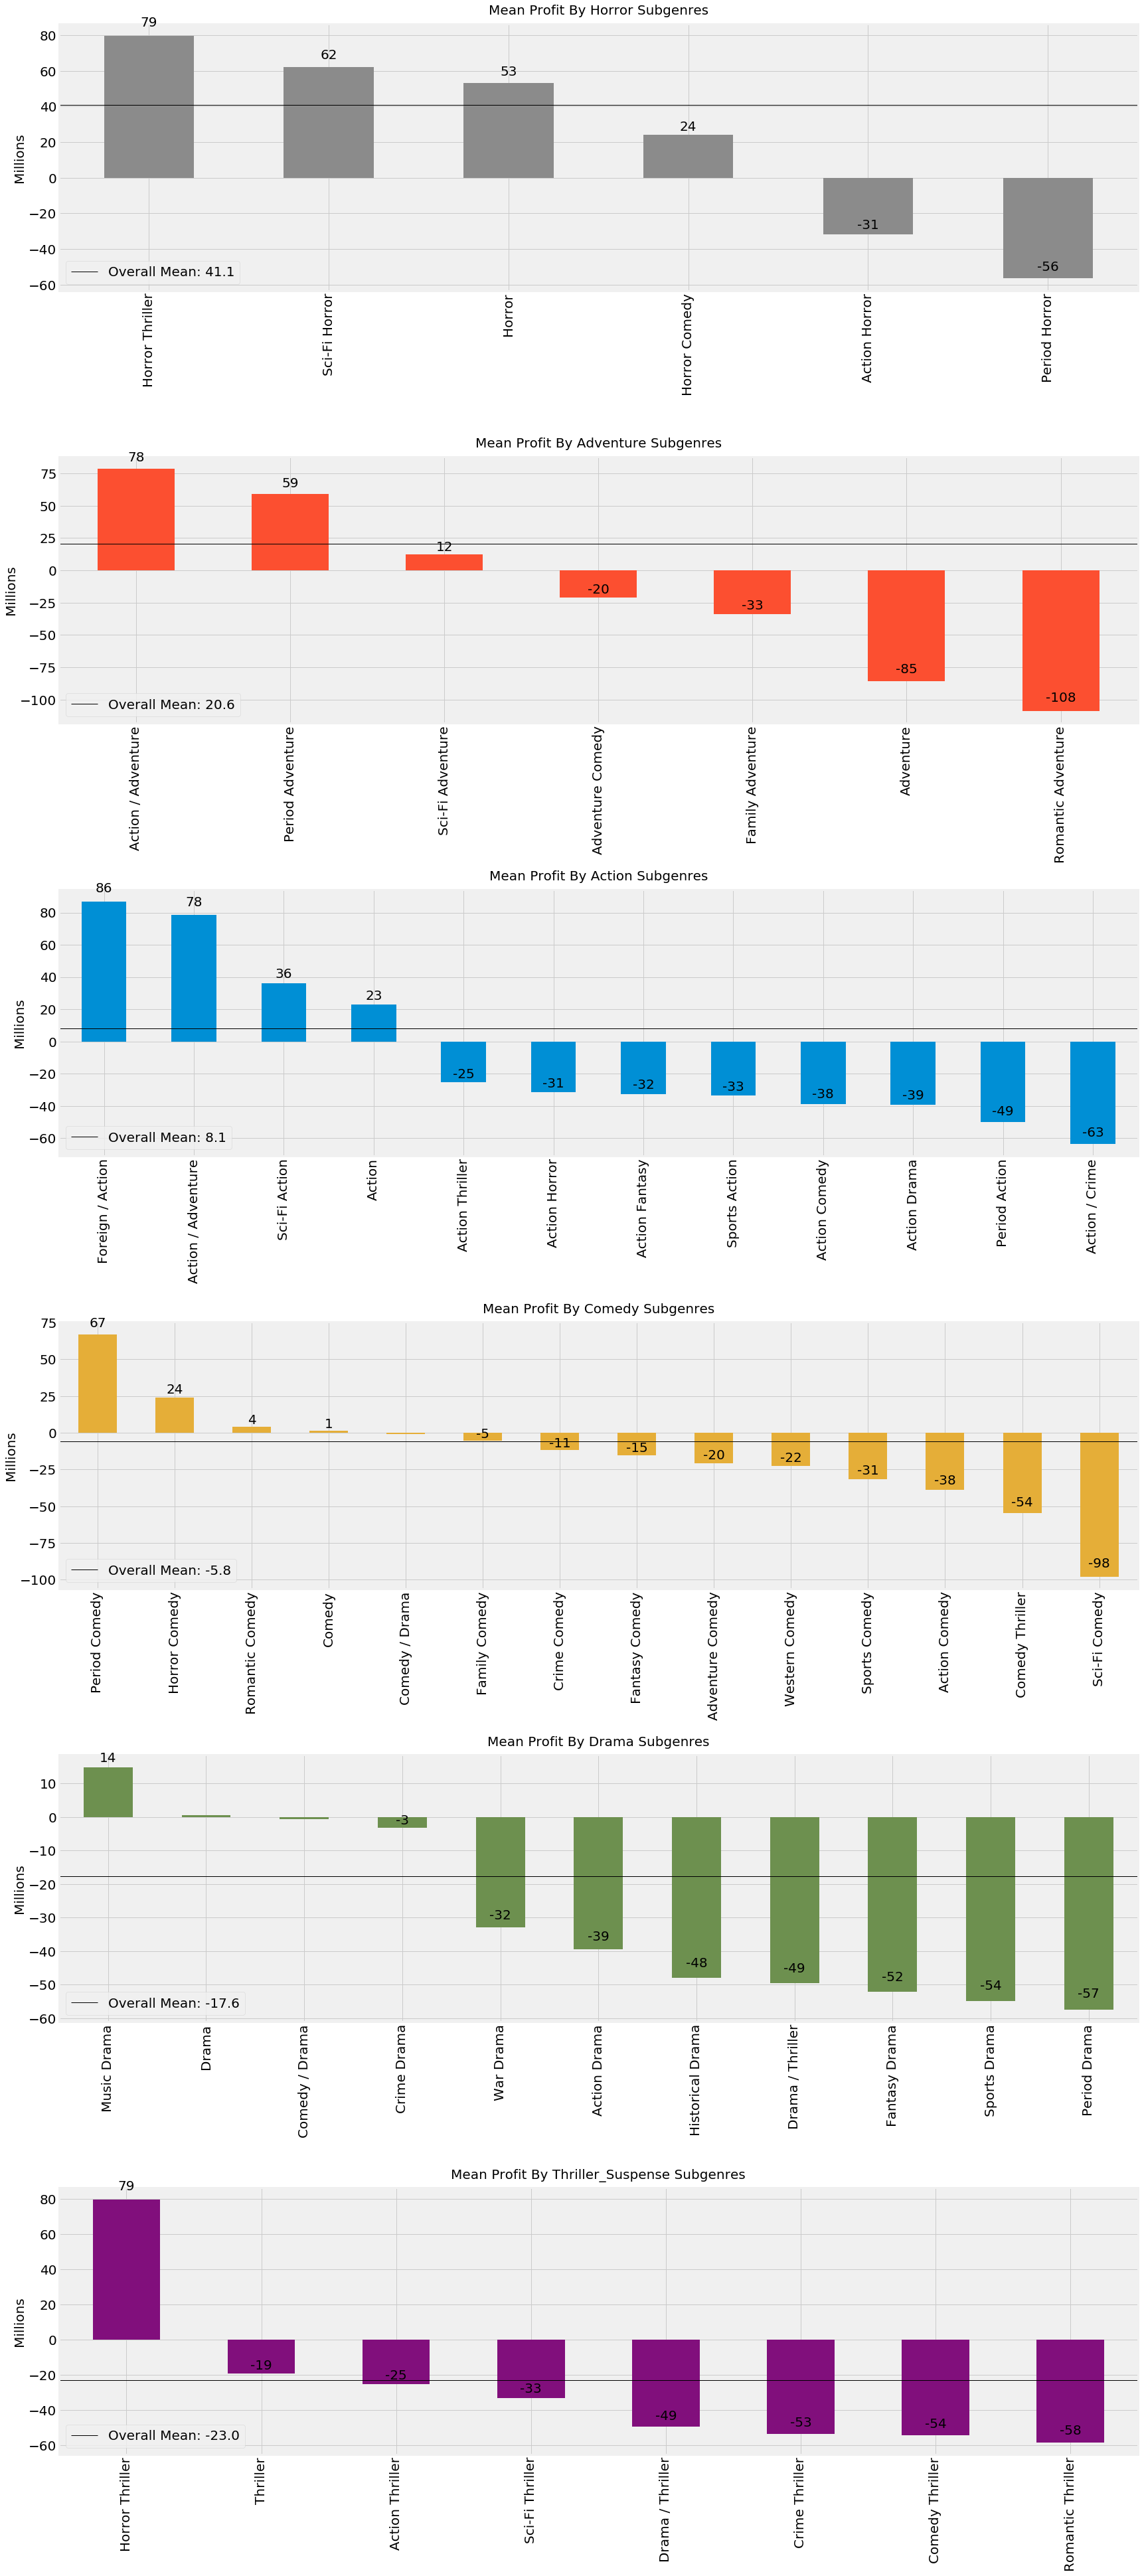

In [355]:
profit_by_subgenres(data=data, genres=genres, aggregation_function='mean', apply_function=lambda x: x / 1000000)

## Quick Takeaways

**The skew strongly affects the results**
  - If we look at mean profits instead of median, the results are much different.
  - Horror, Adventure, and Action are all profitable on the genre level
  - In addition, many more subgenres are profitable in aggregate
  - This is the result of very high-earning movies drastically increasing the average return of other members of their subgenre.

## Dollars Earned Per Dollar Spent

We can calculate this by using our profitability formula. 

We divide the `worldwide_adj` column by (3 * `budget_adj` column).

We can check the results for all-time, the mean, and the median.

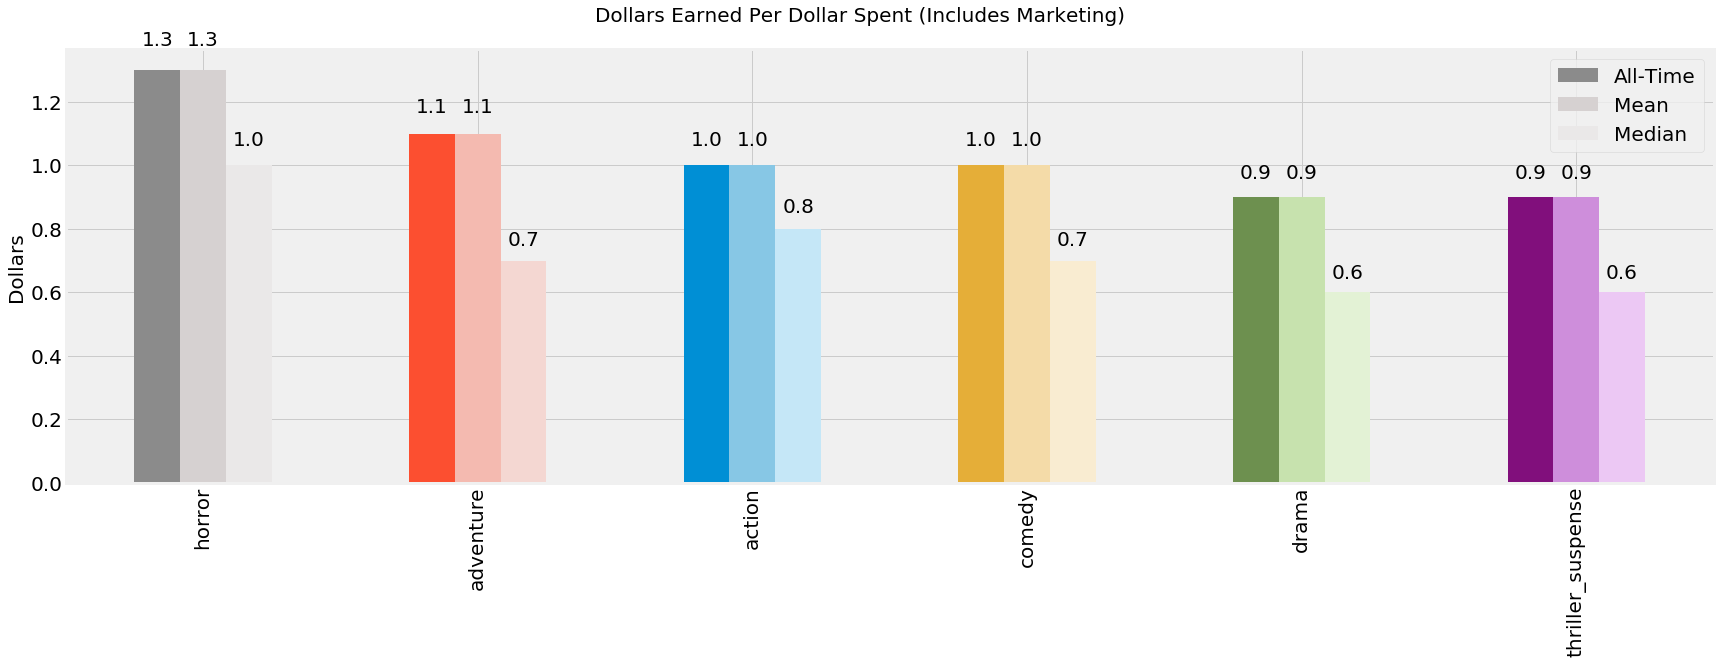

In [135]:
plot_summary_dataframe(summary=summary, sort_column='dollars_earned_for_dollars_spent', 
                       plot_columns=['dollars_earned_for_dollars_spent', 'mean_dollars_earned_for_dollars_spent', 'median_dollars_earned_for_dollars_spent'], 
                       title='Dollars Earned Per Dollar Spent (Includes Marketing)', colors_needed=3, legend_needed=True, 
                       legend_text=['All-Time', 'Mean', 'Median'], y_label='Dollars', num_decimals=1)

## Quick Takeaways

**Same pattern when looking at median versus mean profits**
  - When directly using every single datapoint (`all-time` and `mean`), both Horror and Adventure are profitable in aggregate.
  - However, when using only the median results, Horror is breakeven and all other genres lose money.
  - This is evidence of the power of those long right tails in blockbusters' earnings.

# Breakeven Percentage

We can calculate the percentage chance a movie has to breakeven in aggregate as another way to judge relative risk.

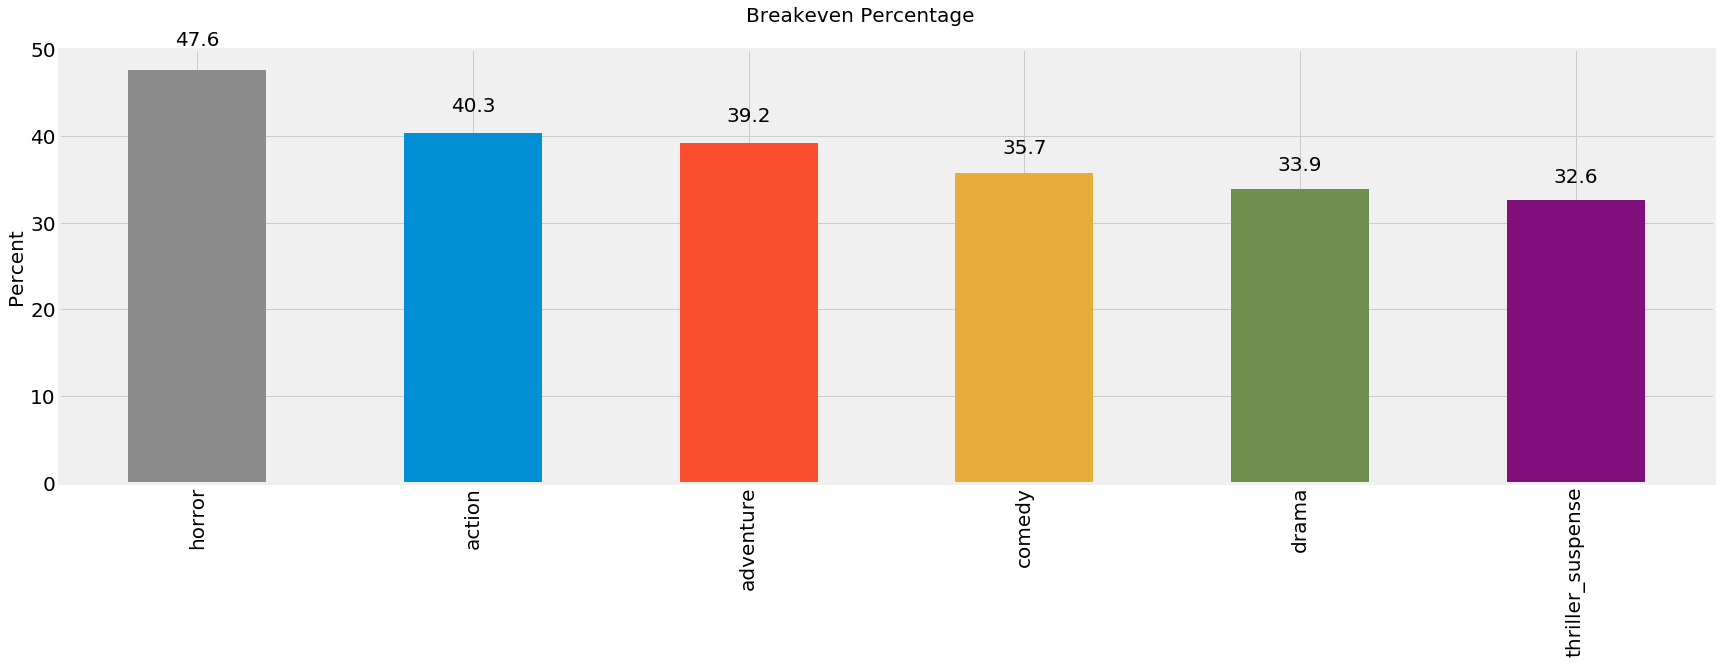

In [123]:
plot_summary_dataframe(summary=summary, sort_column='breakeven_percentage', plot_columns='breakeven_percentage', 
                       title='Breakeven Percentage', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Percent', num_decimals=1)

## Quick Takeaways

**Less than 50%**
  - No genre has a better than 50% chance of breaking even.
  - The least risky one just from a breakeven perpective is Horror.
  - The next least risky movies are Action and Adventure.

# If A Decision Must Be Made Now

This would be a difficult decision to make. 

Action, Comedy, and Adventure have made the most overall money worldwide. Action and Adventure have far higher median worldwide grosses than Comedy. Comedy must be making up for this with its higher numbers of movies released. However, Adventure and Action are the two most expensive genres to make, whereas Comedy is fourth.

The highest aggregate return for every dollar spent comes from Horror, then Adventure. 

The highest median return for every dollar spent comes from Horror, then Action.

The highest median profit per genre is Horror, then Comedy. (Note though that both these numbers are negative, since no genre has a positive median profit all-time.)

The genres with the lowest median budgets are Drama, then Horror, then Comedy.

Genres with the best chance to breakeven are Horror, then Action, then Adventure.

## A Few Strategies

### "Let's not lose money" strategy

If our bosses are all about capital preservation and are more risk-averse as opposed to reward-inclined, I would suggest Horror and Comedy.

Horror is one of the cheapest genres to produce and yet it has the highest median profit per genre. It also has the highest chance to breakeven. Our bosses could make around three Horror movies for the price of a single Action movie, or four Horror movies for the price of one Adventure movie. Horror's median gross of \\$94 million is well below Action's \\$206 million and Adventure's \\$257 million, but it would be a safer play.

Comedy has the second cheapest median budget and the second highest median profit. Historically, it is a solid genre, as it has earned in aggregate the second-most amount of box office dollars (behind only Action). It tends to have a ceiling in terms of box office gross (only one Comedy has ever earned \\$1 billion at the box office, Forrest Gump), but it's a reliable bet given it's much lower budget compared to big fare like Action and Adventure.

### "Swing for the fences" strategy

If our bosses really care about releasing those mega blockbusters and risk be damned, then we all know they're talking about Action and Adventure, the kings of the right tails. 16 of the top 20 all-time highest grossing movies are in one of those two genres. Three of the other four are in the Horror genre.

I would suggest sticking to those three genres.

## Disclaimer

There are a lot of reasons why studios prefer to make certain genres over others. After all, it's tough to make theme park rides based on Drama and Comedy movies. This analysis assumes we only care about how much money a movie makes at the box office.

## Let's Keep Digging

So far, we have only analyzed these genres in aggregate. 

Our bosses want more pinpoint accuracy. Which genres are the hottest right now? Which genres perform the best during which parts of the year?

So we've got more digging to do, and we'll next look for trends by Release Decade and Release Week. 

# Performance By Decade

We will now dive into the performance of movies by decade of release.

## Number of movies

In [317]:
def plot_by_time_and_stat(data, genres, title, groupby_column, stat_columns, aggregate_function, apply_needed=False, apply_function=None, y_label='', y_ticks_needed=False, y_ticks='', legend_needed=True, legend_text=genres, color=colors, axhline_needed=False, axhline_value='', autolabel_needed=False):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
    figure.suptitle(title, fontsize=20)
    
    if apply_needed: 
        data.groupby(groupby_column)[stat_columns].agg(aggregate_function).apply(apply_function).plot(kind='bar', ax=axis, color=color)
    else: 
        data.groupby(groupby_column)[stat_columns].agg(aggregate_function).plot(kind='bar', ax=axis, color=color)
        
    axis.set_xlabel('')
    axis.set_ylabel(y_label, fontsize=20)
    axis.tick_params(labelsize=20)
    
    if legend_needed: 
        axis.legend(legend_text, loc='best', fontsize=15)
    
    if y_ticks_needed:
        axis.set_yticks(y_ticks)
        
    if axhline_needed:
        axis.axhline(axhline_value, color='k', linewidth=1)
        
    if autolabel_needed:
        autolabel(axis)

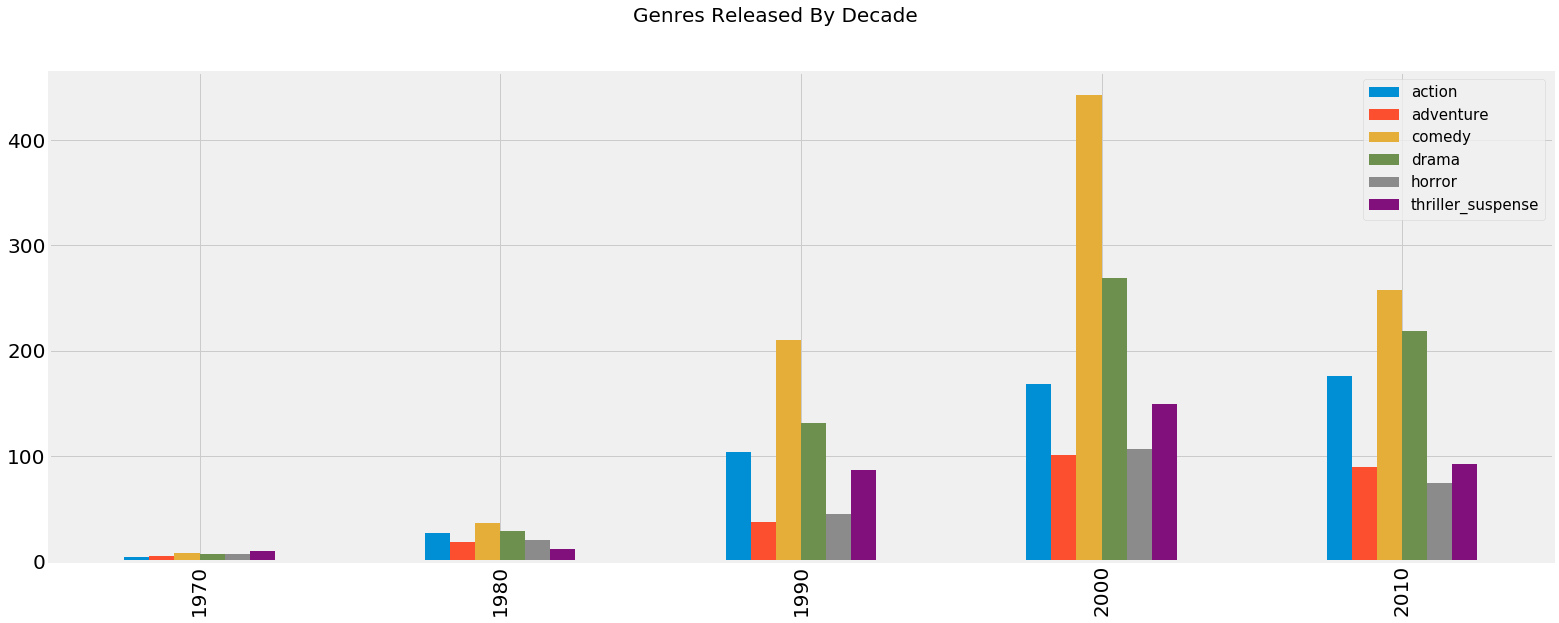

In [319]:
plot_by_time_and_stat(data=data, genres=genres, title='Genres Released By Decade', 
                      groupby_column='release_decade', stat_columns=genres, aggregate_function='sum', 
                      apply_needed=False, apply_function=None, y_label='', y_ticks_needed=False, y_ticks='')

## Quick Takeaways

**1970s to 2000s**
  - We see huge increases in the number of movies released per genre
  - Comedy and Drama are the most produced genres from then to the present by a wide margin
  
**2000s to 2010s**
  - We see a reduction in the number of movies released for all genres except Action 
  
**Fewer movies made now**
- Our gut should tell us movies are not as profitable now as they used to be because the Big Five release far fewer movies now than they did in the 2000s.

## Grosses

### Aggregate

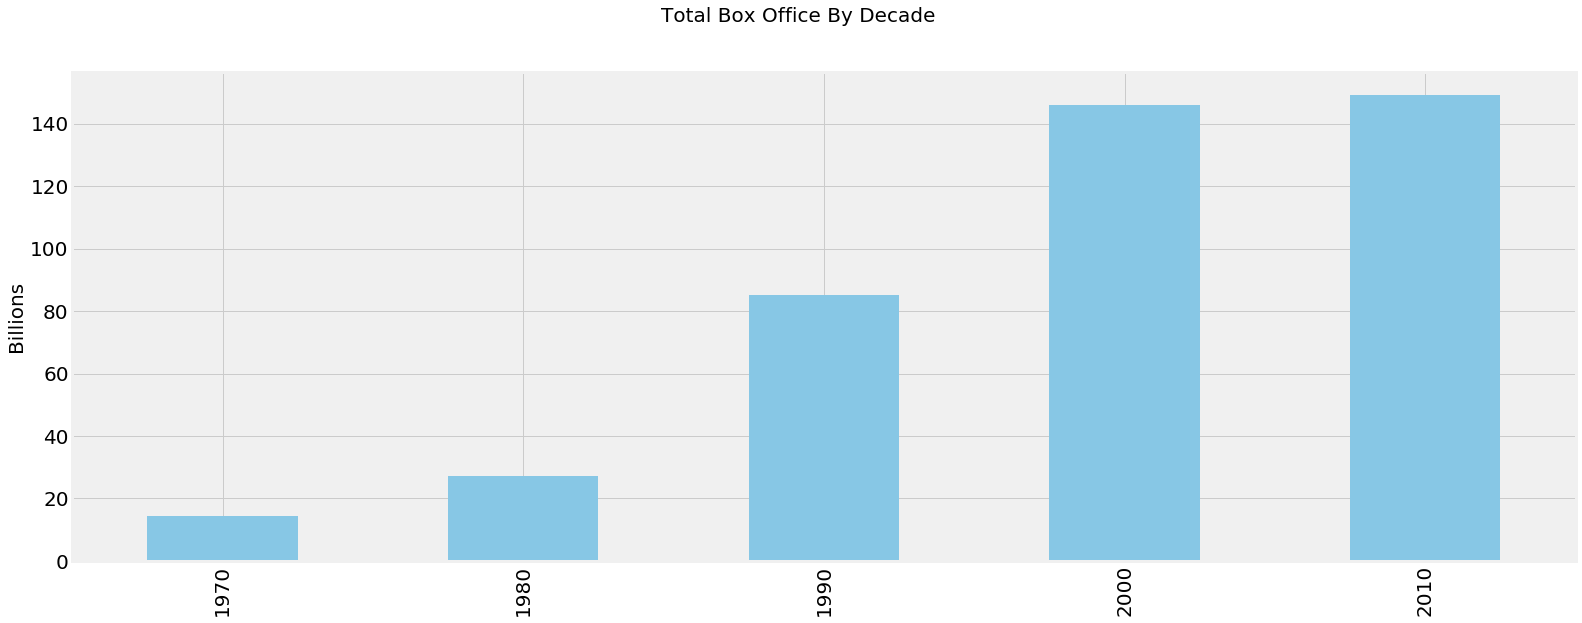

In [384]:
plot_by_time_and_stat(data=data, genres=genres, title='Total Box Office By Decade', 
                      groupby_column='release_decade', stat_columns='worldwide_adj', 
                      aggregate_function='sum', apply_needed=True, apply_function=lambda x: x / 1000000000, 
                      y_label='Billions', y_ticks_needed=False, y_ticks='', legend_needed=False, 
                      legend_text='', color=genres_dict['action']['color2'])

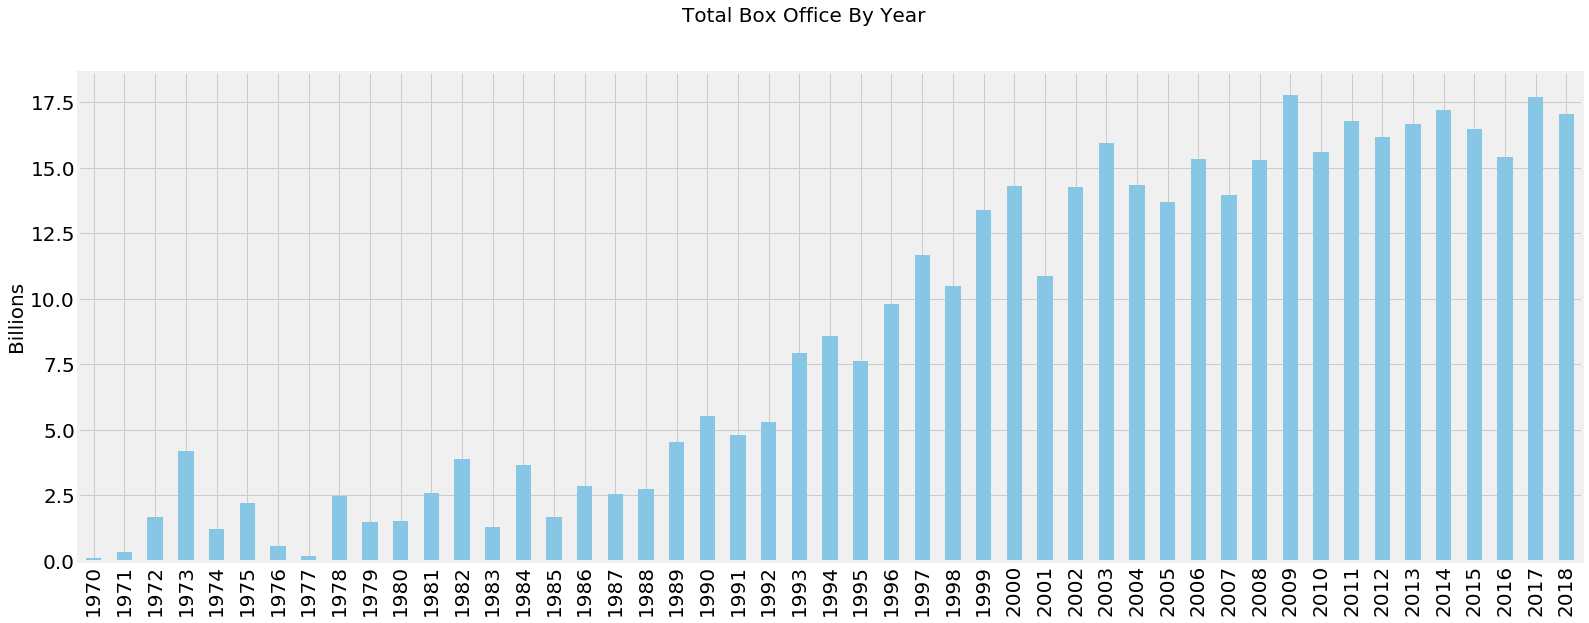

In [385]:
plot_by_time_and_stat(data=data, genres=genres, title='Total Box Office By Year', 
                      groupby_column='release_year', stat_columns='worldwide_adj', 
                      aggregate_function='sum', apply_needed=True, apply_function=lambda x: x / 1000000000, 
                      y_label='Billions', y_ticks_needed=False, y_ticks='', legend_needed=False, 
                      legend_text='', color=genres_dict['action']['color2'])

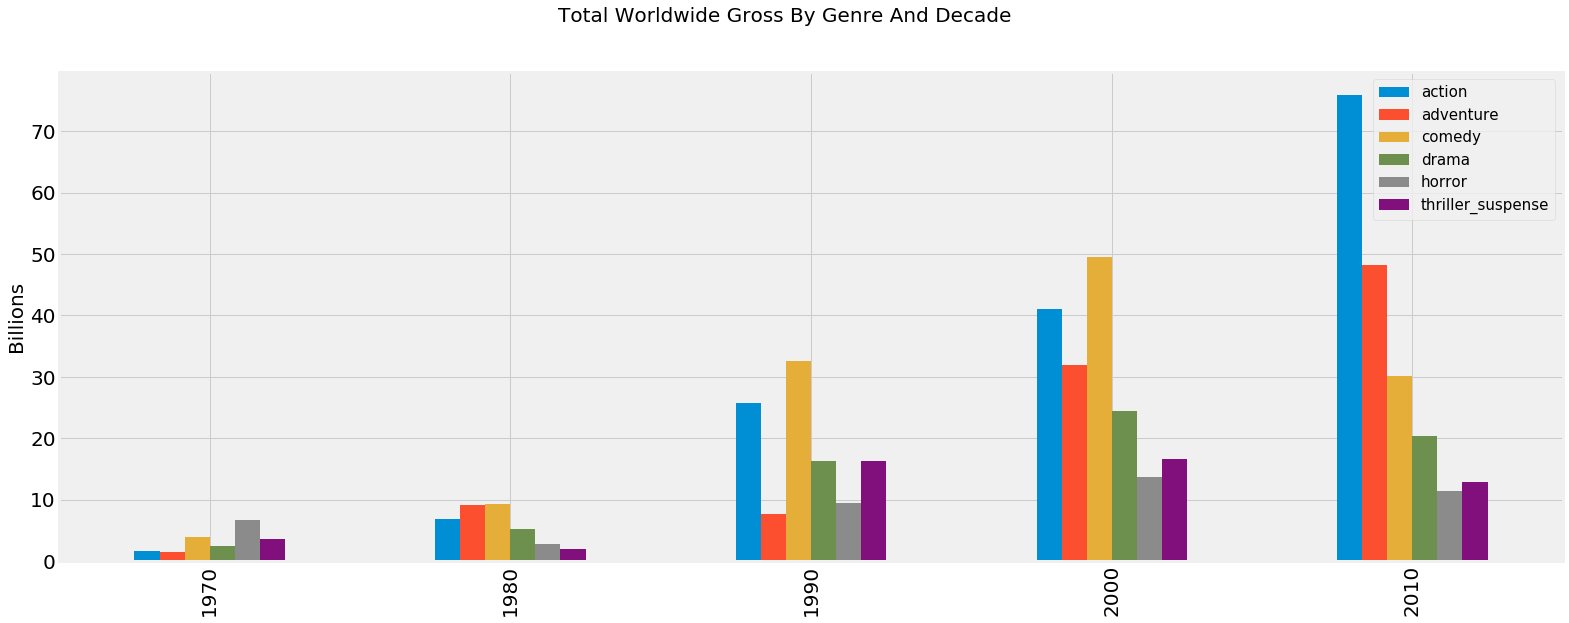

In [323]:
plot_by_time_and_stat(data=data, genres=genres, title='Total Worldwide Gross By Genre And Decade', groupby_column='release_decade', stat_columns=gross_columns, aggregate_function='sum', apply_needed=True, apply_function=lambda x: x / 1000000000, y_label='Billions', y_ticks_needed=False, y_ticks='')

In [53]:
# Create custom function to determine the background color for labeling the genre with the highest stat per decade
def find_genre_for_background_color(groupby_instance, decade):
    column_name_list = groupby_instance.loc[decade].sort_values(ascending=False).index[0].split('_')
    
    # Check if the split string has length 4, if so it is thriller_suspense and requires extra filtering
    # The reason is our genres are 'action', 'adventure', 'comedy', 'drama', 'horror', and 'thriller_suspense'
    # Our worldwide stat column names have the following form: worldwide_(stat name)_genre
    # Thus five of our six genres will have length 3 when split on '_', but 'thriller_suspense' will have length 4
    if len(column_name_list) == 4:
        return '_'.join(column_name_list[-2:])
    
    # If the genre is not 'thriller_suspense', we just need the last word in the list
    return column_name_list[-1]

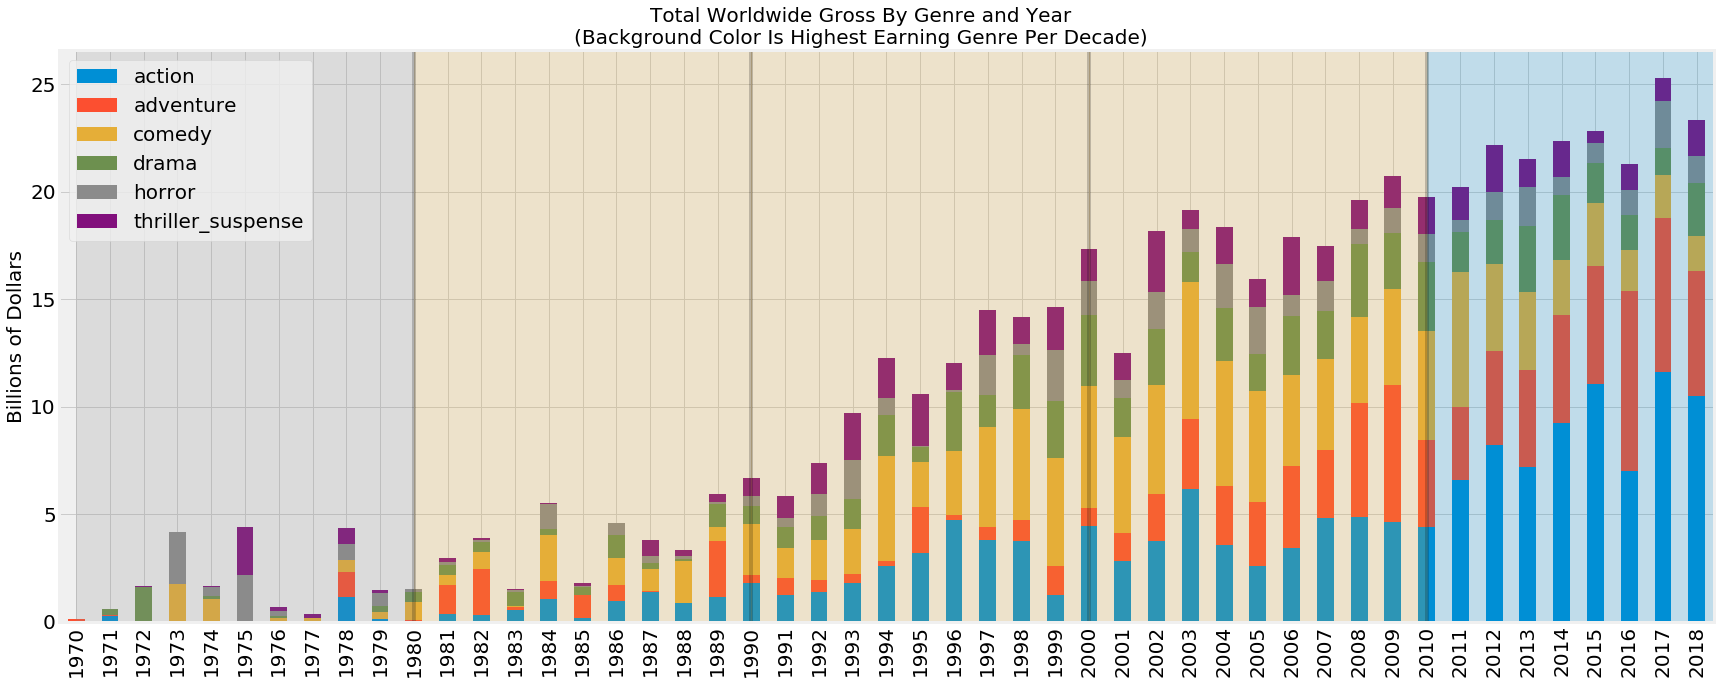

In [54]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Total Worldwide Gross By Genre and Year\n(Background Color Is Highest Earning Genre Per Decade)', fontsize=20, y=1.05)

# Determine background colors for each decade
grp = data.groupby('release_decade')[gross_columns].sum() / 1000000000
bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

# Set up plot
grp = data.groupby('release_year')[gross_columns].sum() / 1000000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)
axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
axis.axvline(10, color='k', alpha=0.2)
axis.axvline(20, color='k', alpha=0.2)
axis.axvline(30, color='k', alpha=0.2)
axis.axvline(40, color='k', alpha=0.2)

plt.tight_layout()

### Quick Takeaways

**Box office increasing at a slower rate**
  - Decade by decade, the global box office revenue is increasing, but its rate of growth has slowed down.
  - Action and Adventure have increased their overall gross every decade since the 1980s.
  - Horror was the highest grossing genre in the 1970s.
  - Comedy was the highest grossing genre for the 1980s, 1990s, and 2000s.
  - Comedy had a big jump from the 1990s to 2000s, but has contracted in the 2010s.
  - Action is the highest grossing genre in the 2010s.
  - Drama, Horror, and Thriller/Suspense seem flat from the 2000s to 2010s.
  
**Note**
  - This graph shows higher global box office numbers than the 'Total Box Office By Year' graph above. This is due to how we count a movie multiple times if it has multiple genres. For example, an Action/Adventure movie would count as both an Action movie and an Adventure movie. Thus, the box office results for that movie would be reported twice when we subdivide by genre.

### Mean and Median Gross

In [388]:
def plot_mean_and_median_by_time_and_stat(data, genres, groupby_column, stat_columns, stat_name_for_title, apply_needed=False, apply_function=None, y_label='', y_ticks_needed=False, y_ticks='', axhline_needed=False, axhline_value=''):
    figure, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
    
    if apply_needed: 
        data.groupby(groupby_column)[stat_columns].agg('mean').apply(apply_function).plot(kind='bar', ax=axis1)
        data.groupby(groupby_column)[stat_columns].agg('median').apply(apply_function).plot(kind='bar', ax=axis2)
    else:
        data.groupby(groupby_column)[stat_columns].agg('mean').plot(kind='bar', ax=axis1)
        data.groupby(groupby_column)[stat_columns].agg('median').plot(kind='bar', ax=axis2)
    
    axis1.set_ylabel(y_label, fontsize=20)
    
    if y_ticks_needed:
        axis1.set_yticks(y_ticks)
        axis2.set_yticks(y_ticks)
        
    axis1.set_xlabel('')
    axis1.tick_params(labelsize=20)
    axis1.legend(genres, fontsize=20)
    axis1.set_title('Mean {} By Genre And Decade'.format(stat_name_for_title), fontsize=20, y=1.02)

    axis2.set_ylabel(y_label, fontsize=20)
    axis2.set_xlabel('')
    axis2.tick_params(labelsize=20)
    axis2.legend(genres, fontsize=20)
    axis2.set_title('Median {} By Genre And Decade'.format(stat_name_for_title), fontsize=20, y=1.02)
    
    if axhline_needed:
        axis1.axhline(axhline_value, color='k', linewidth=1)
        axis2.axhline(axhline_value, color='k', linewidth=1)

    plt.tight_layout()

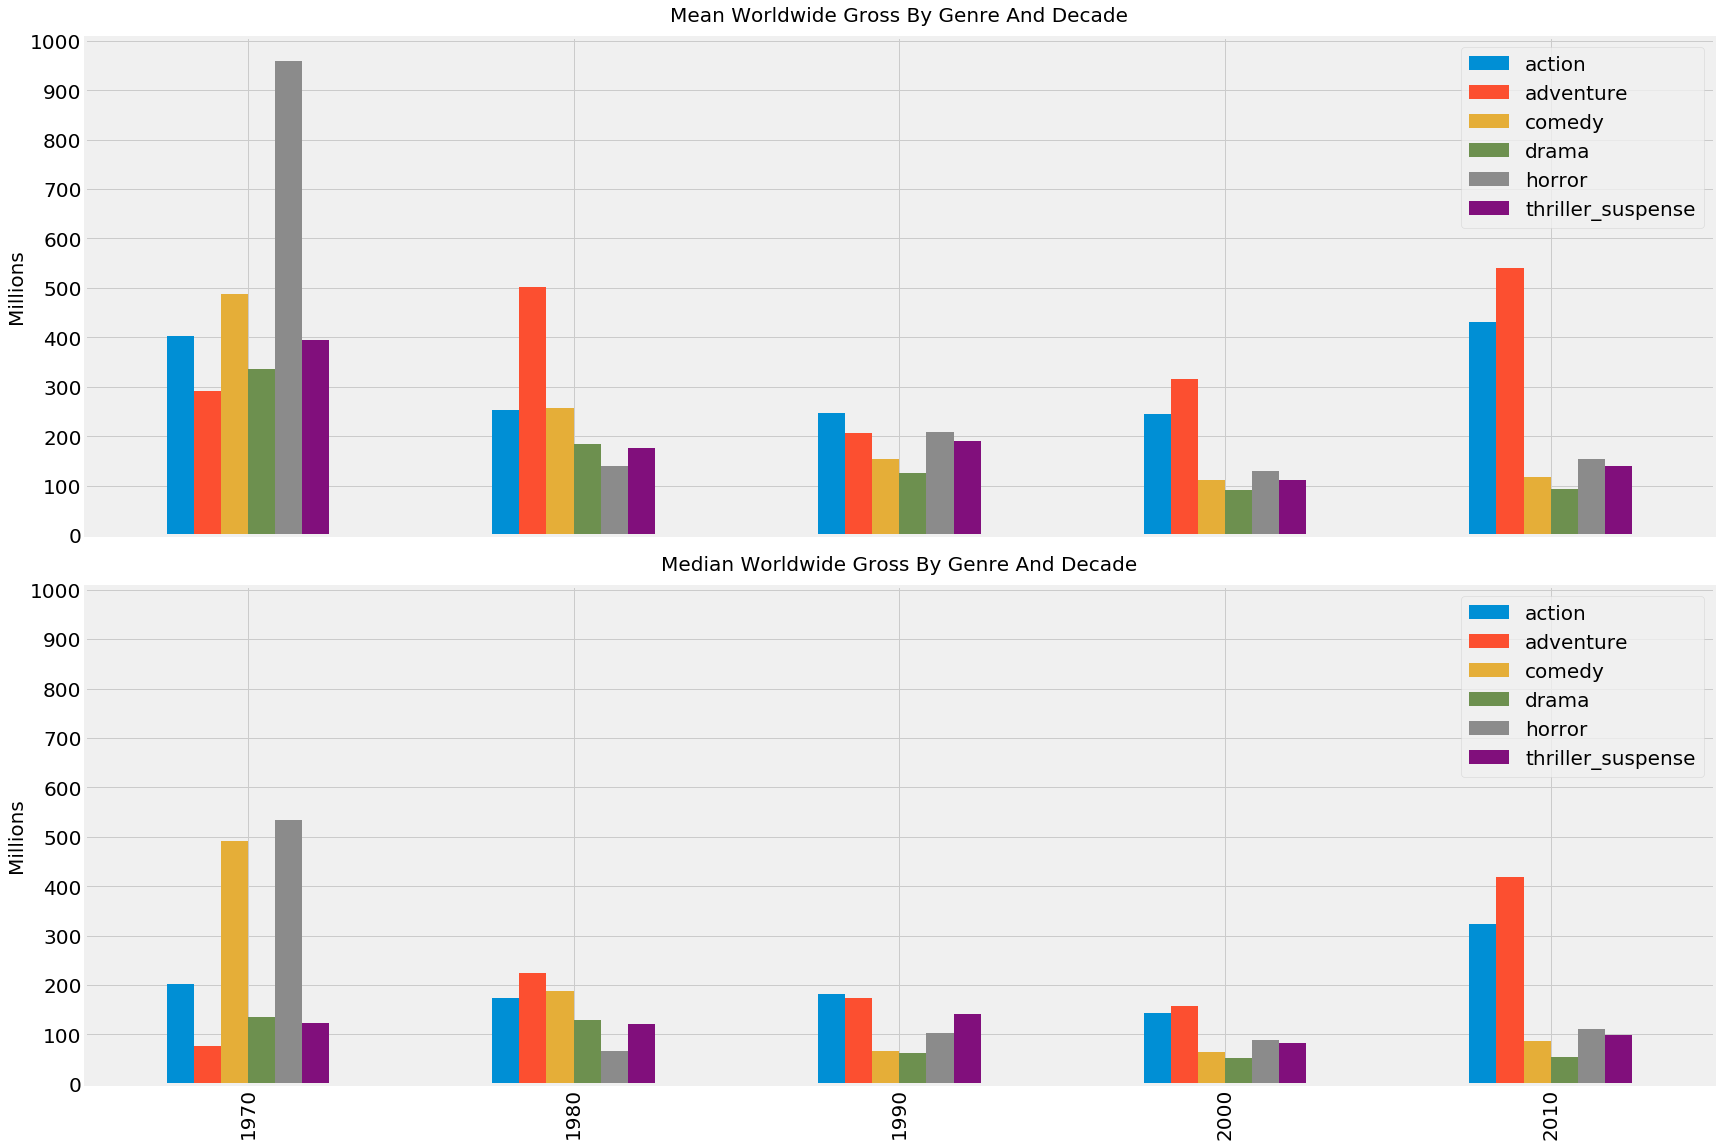

In [386]:
plot_mean_and_median_by_time_and_stat(data=data, genres=genres, groupby_column='release_decade', 
                                      stat_columns=gross_columns, stat_name_for_title='Worldwide Gross', 
                                      apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      y_label='Millions', y_ticks_needed=True, y_ticks=range(0, 1100, 100))

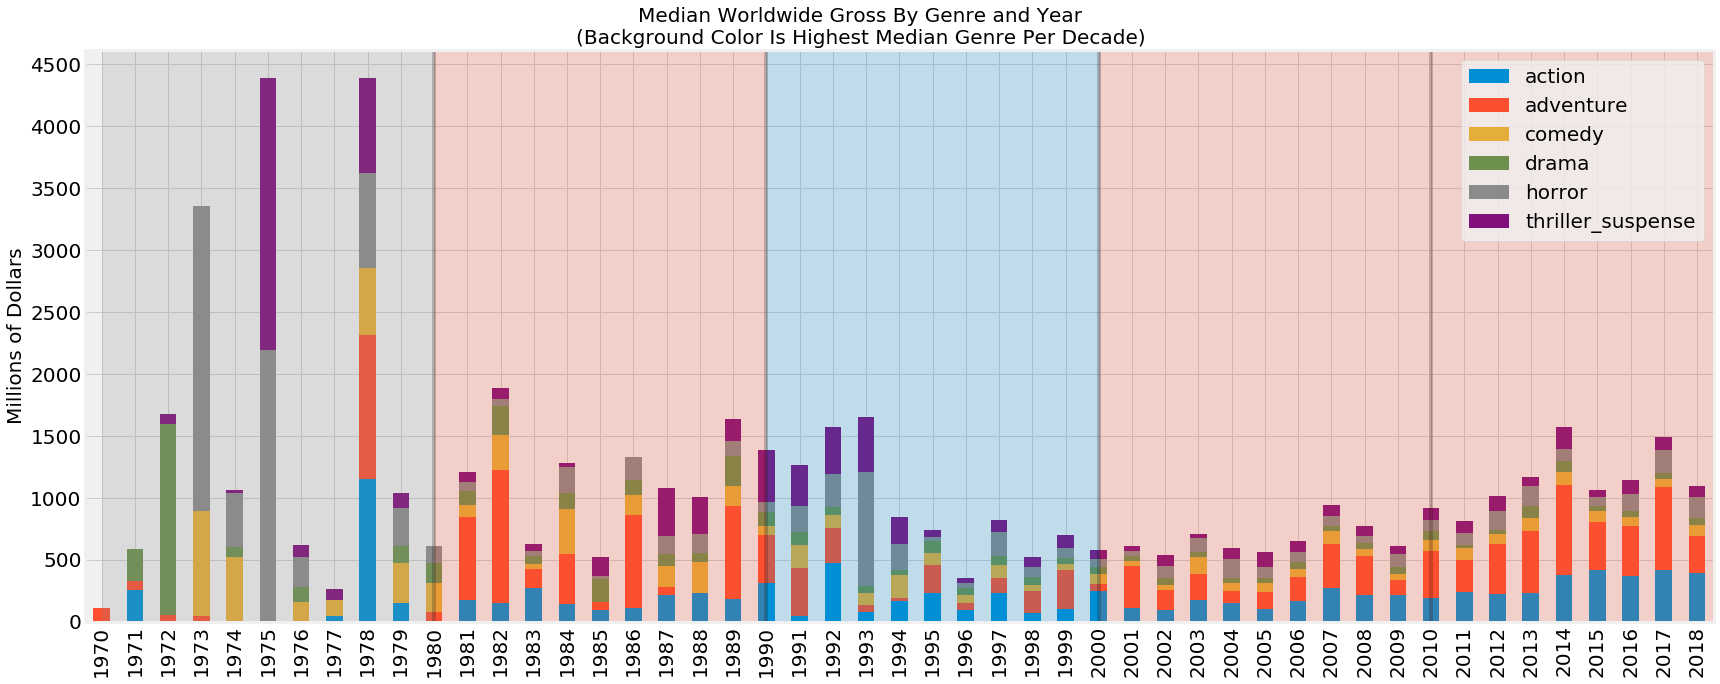

In [56]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Worldwide Gross By Genre and Year\n(Background Color Is Highest Median Genre Per Decade)', fontsize=20, y=1.05)

# Determine background colors for each decade
grp = data.groupby('release_decade')[gross_columns].median() / 1000000000
bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

grp = data.groupby('release_year')[gross_columns].median() / 1000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.set_yticks(range(0, 5000, 500))
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)
axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
axis.axvline(10, color='k', alpha=0.2)
axis.axvline(20, color='k', alpha=0.2)
axis.axvline(30, color='k', alpha=0.2)
axis.axvline(40, color='k', alpha=0.2)

plt.tight_layout()

### Quick Takeaways

**Contracting period, then expanding period**
  - We see an overall contraction in mean/median gross by decade from the 1980s to the 2000s. The exceptions are Action, Horror, and Thriller/Suspense having median increases from the 1980s to the 1990s, but then falling in the 2000s like the other genres.  
  - From the 2000s to the 2010s, Action and Adventure's median grosses have more than doubled.
  - From the 2000s to the 2010s, Comedy, Horror, and Thriller/suspense all have double digit median gross increases.
  - Drama has the smallest increase in the last decade, only 6.4% median gross increase.
  
**Median gross change from 2000s to 2010s ranked from highest to lowest**
  - Adventure:         \\$261 million    -- 165.0%
  - Action:            \\$180.9 million  -- 126.3%
  - Comedy:            \\$22.8 million   -- 35.3%
  - Horror:            \\$21.1 million   -- 23.6%
  - Thriller/Suspense: \\$16.3 million   -- 19.7%
  - Drama:             \\$3.3 million    -- 6.4%
  
**Highest median gross by decade**
  - 1970s: Horror
  - 1980s: Adventure
  - 1990s: Action
  - 2000s: Adventure
  - 2010s: Adventure

In [367]:
def one_stat_over_time_in_separate_graphs(data, genres, title, figsize, colors, groupby_column, stat_column, aggregation_function, starting_year=1970, apply_needed=False, apply_function=None, xtick_values='', y_label='', axhline_needed=False, axhline_value=''):
    figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=figsize)
    figure.suptitle(title, fontsize=20, y=1.02)

    for genre, axis, color in zip(genres, axes.flat, colors):    
        # Create a series with decades as indexes and median budget as values
        
        if apply_needed:
            (data[(data[genre]) & (data['release_year'] >= starting_year)].groupby(groupby_column)[stat_column].agg(aggregation_function).apply(apply_function)).sort_index(ascending=True).plot(kind='bar', xticks=xtick_values, ax=axis, linewidth=3, color=color)
        else:
            (data[(data[genre]) & (data['release_year'] >= starting_year)].groupby(groupby_column)[stat_column].agg(aggregation_function)).sort_index(ascending=True).plot(kind='bar', xticks=xtick_values, ax=axis, linewidth=3, color=color)
                
        axis.set_ylabel(y_label, fontsize=20)
        axis.tick_params(labelsize=20)
        axis.set_xlabel('')
        axis.legend([genre], loc=2, fontsize=15)
        autolabel(axis)
        
        if axhline_needed:
            axis.axhline(axhline_value, color='k', linewidth=1)

    plt.tight_layout()

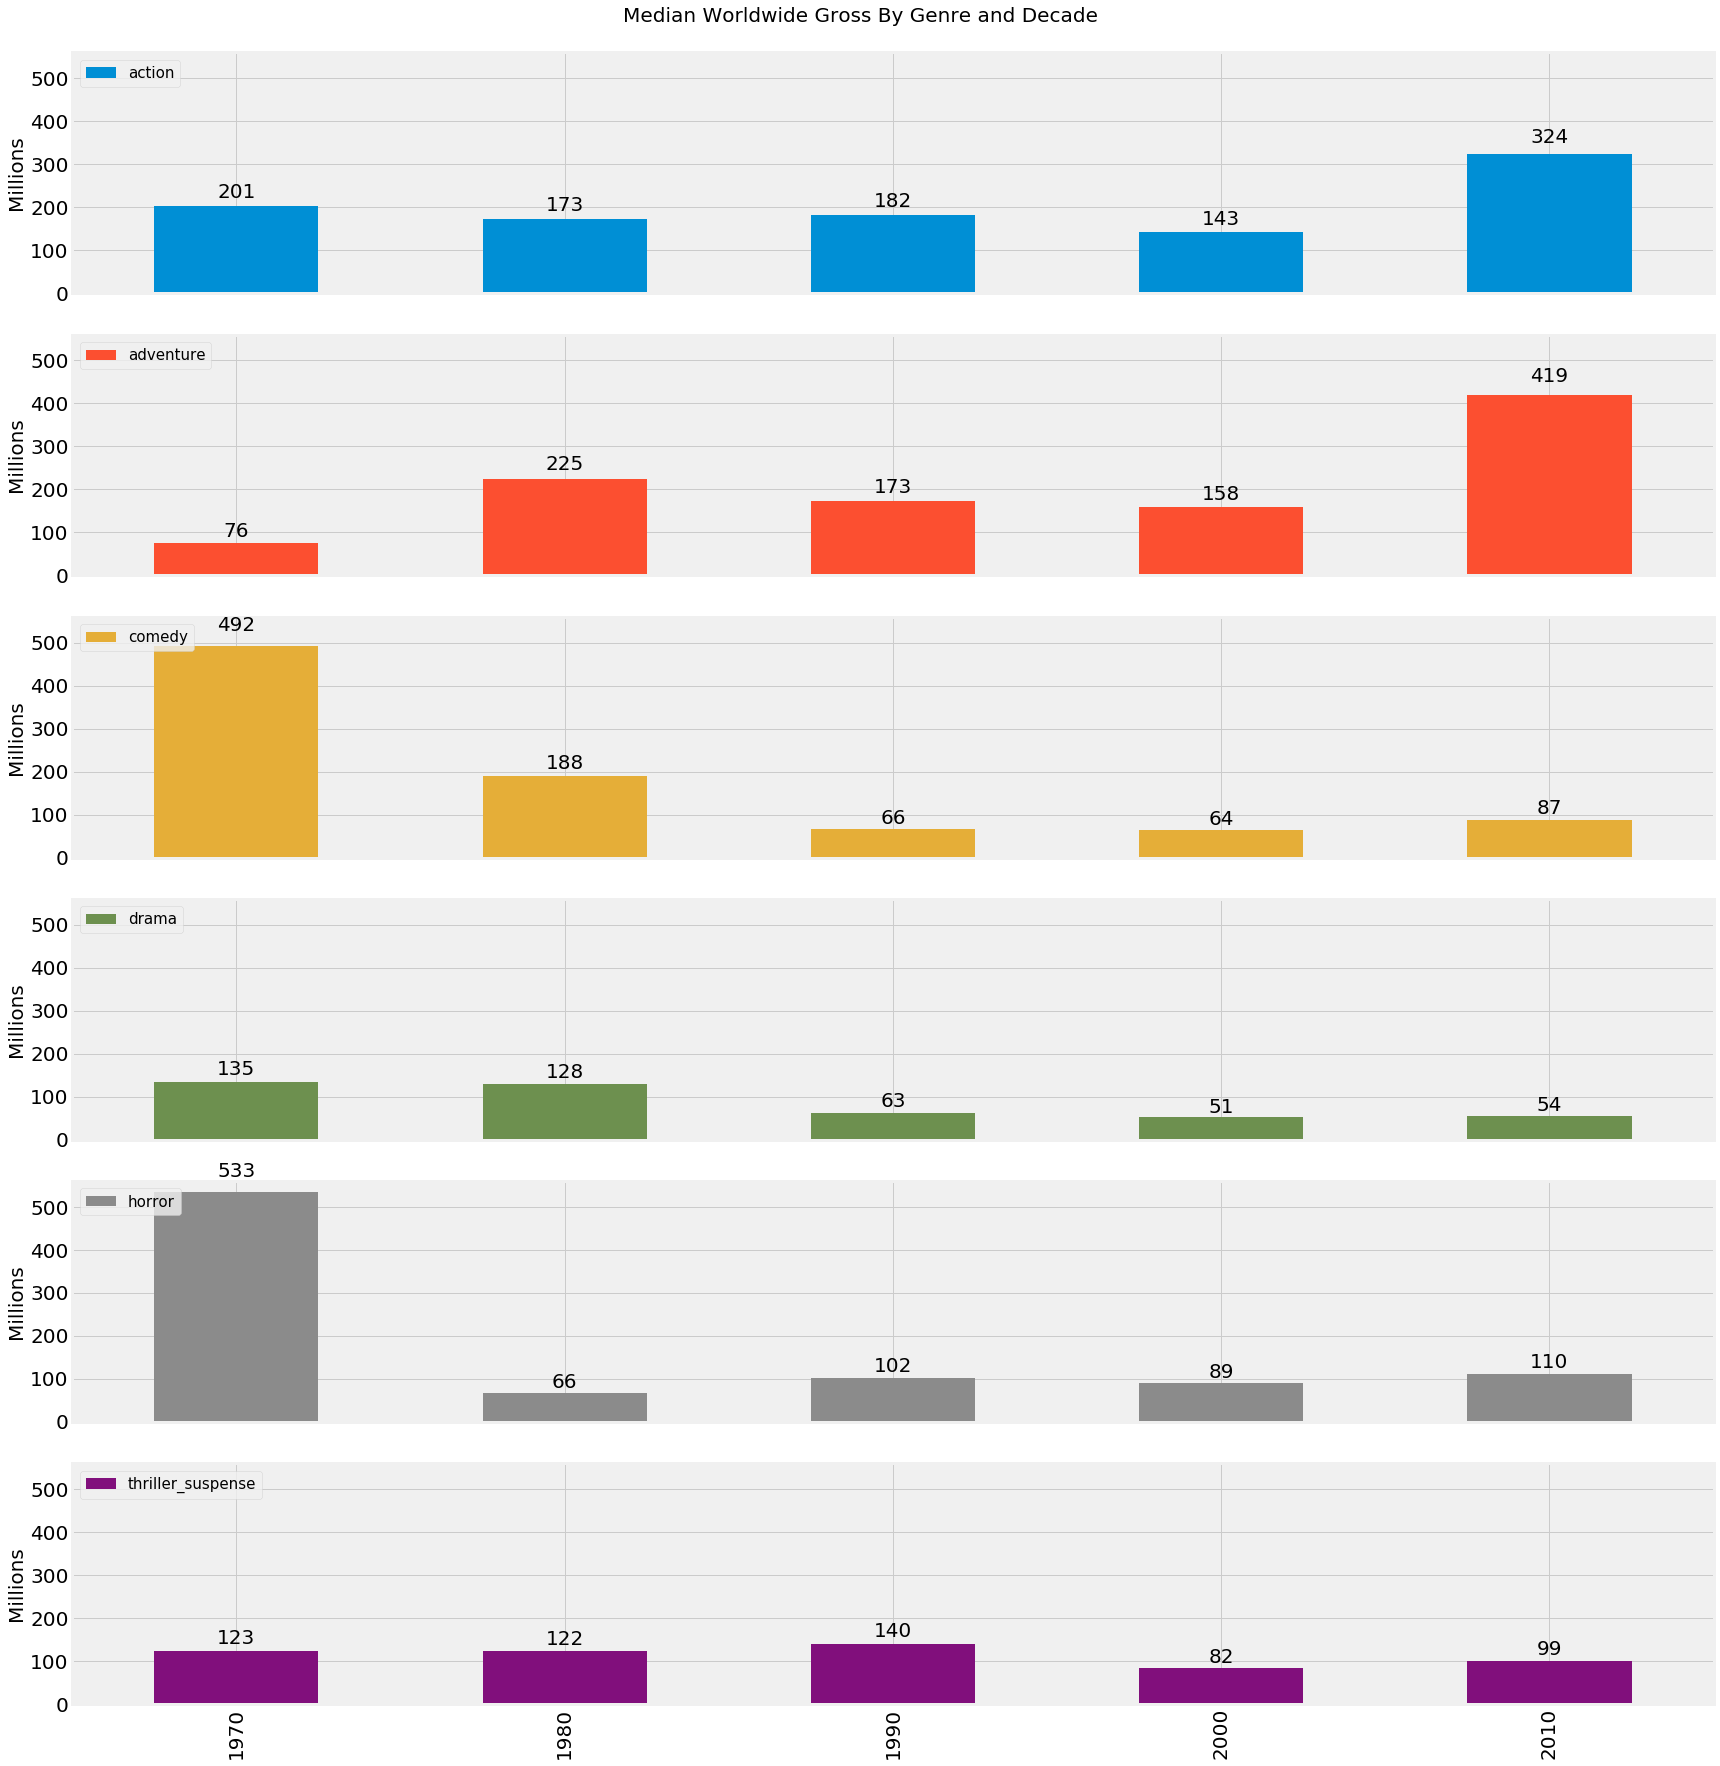

In [372]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Median Worldwide Gross By Genre and Decade', figsize=(24,24), 
                                      colors=colors, groupby_column='release_decade', stat_column='worldwide_adj', 
                                      aggregation_function='median', apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      xtick_values=range(1970, 2020, 10), y_label='Millions', axhline_needed=False, axhline_value='')    

### Quick Takeaways:

**1990s to 2000s**
  - Every genre saw a reduction in median gross from the 1990s to 2000s.
  - This reduction coincided with a huge increase in the number of movies released per genre
  
**2000s to 2010s**
  - Every genre has seen an increase in median gross from the 2000s to 2010s
  - Except for Action, this has coincided with a decrease in the number of movies per genre
  - Action and Adventure's median grosses have more than doubled from the 2000s to 2010s!

**Horror**
  - Horror has the third highest median gross with \\$110 million

## Budgets

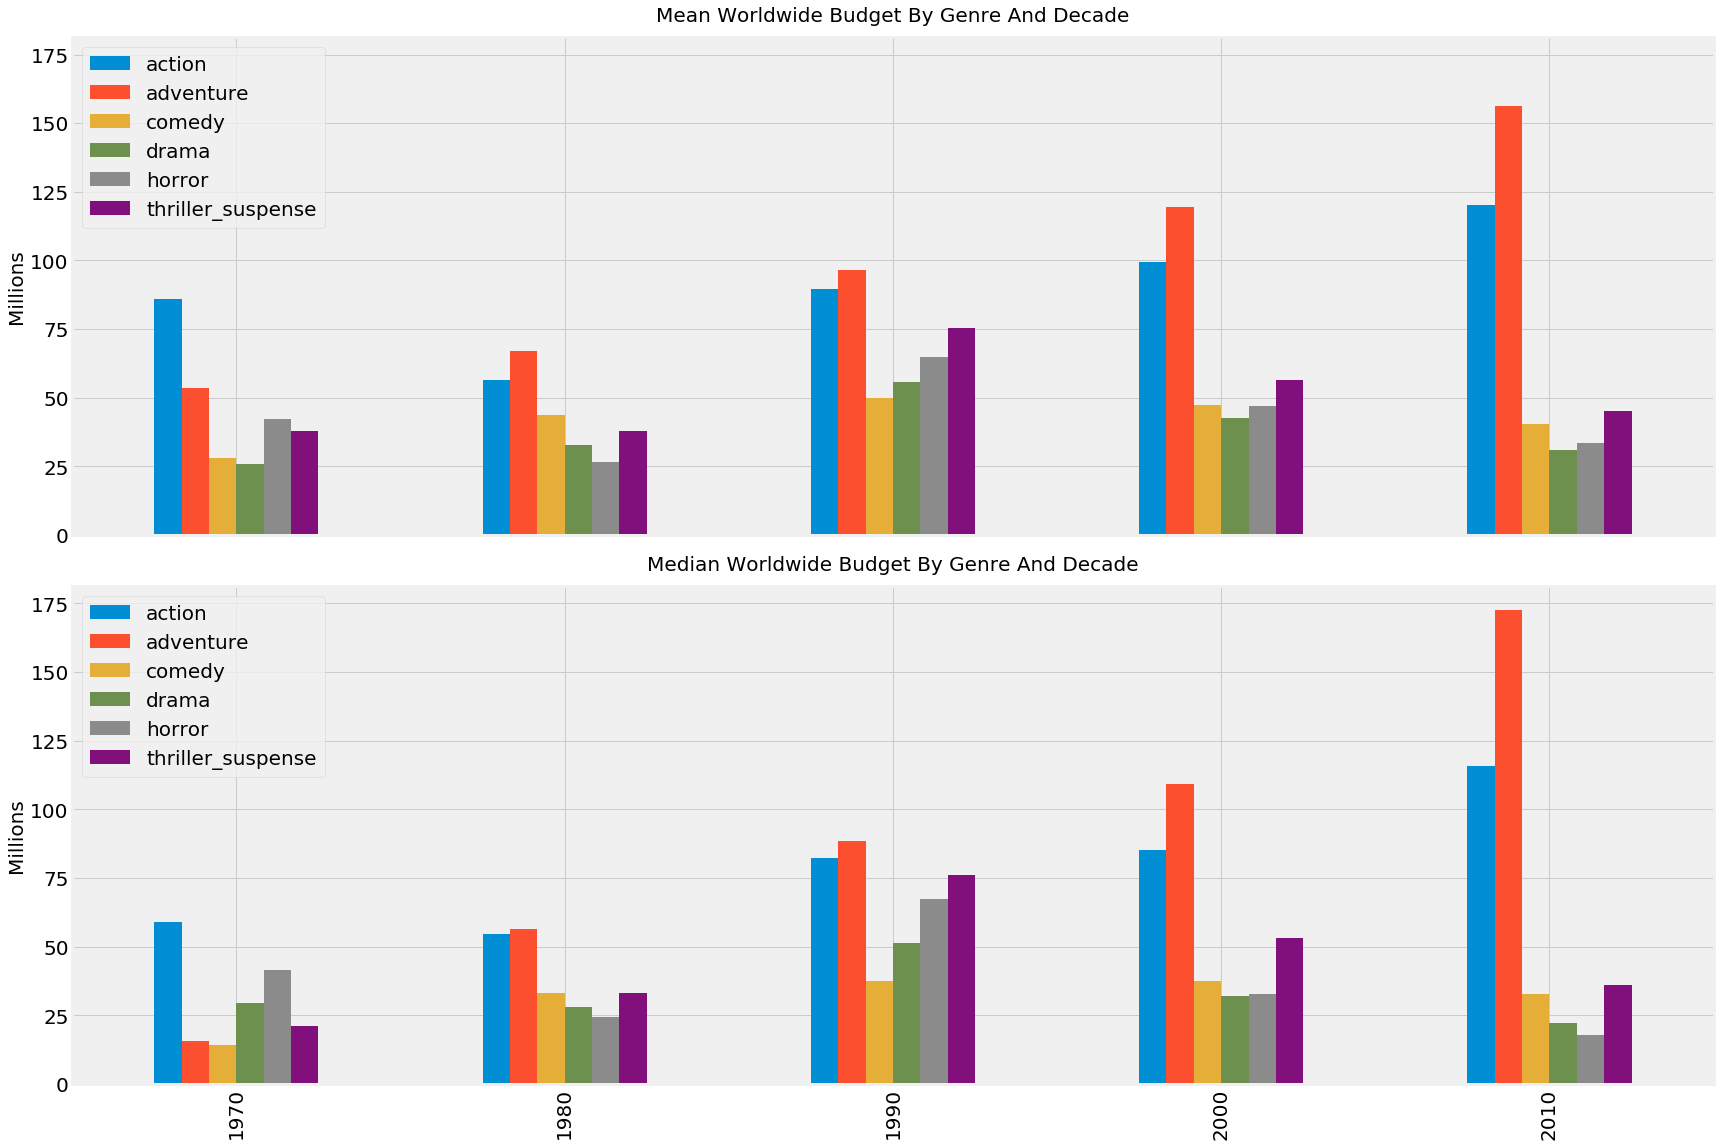

In [387]:
plot_mean_and_median_by_time_and_stat(data=data, genres=genres, groupby_column='release_decade', 
                                      stat_columns=budget_columns, stat_name_for_title='Worldwide Budget', 
                                      apply_needed=True, apply_function=lambda x: x / 1000000, y_label='Millions', y_ticks_needed=False, y_ticks='')

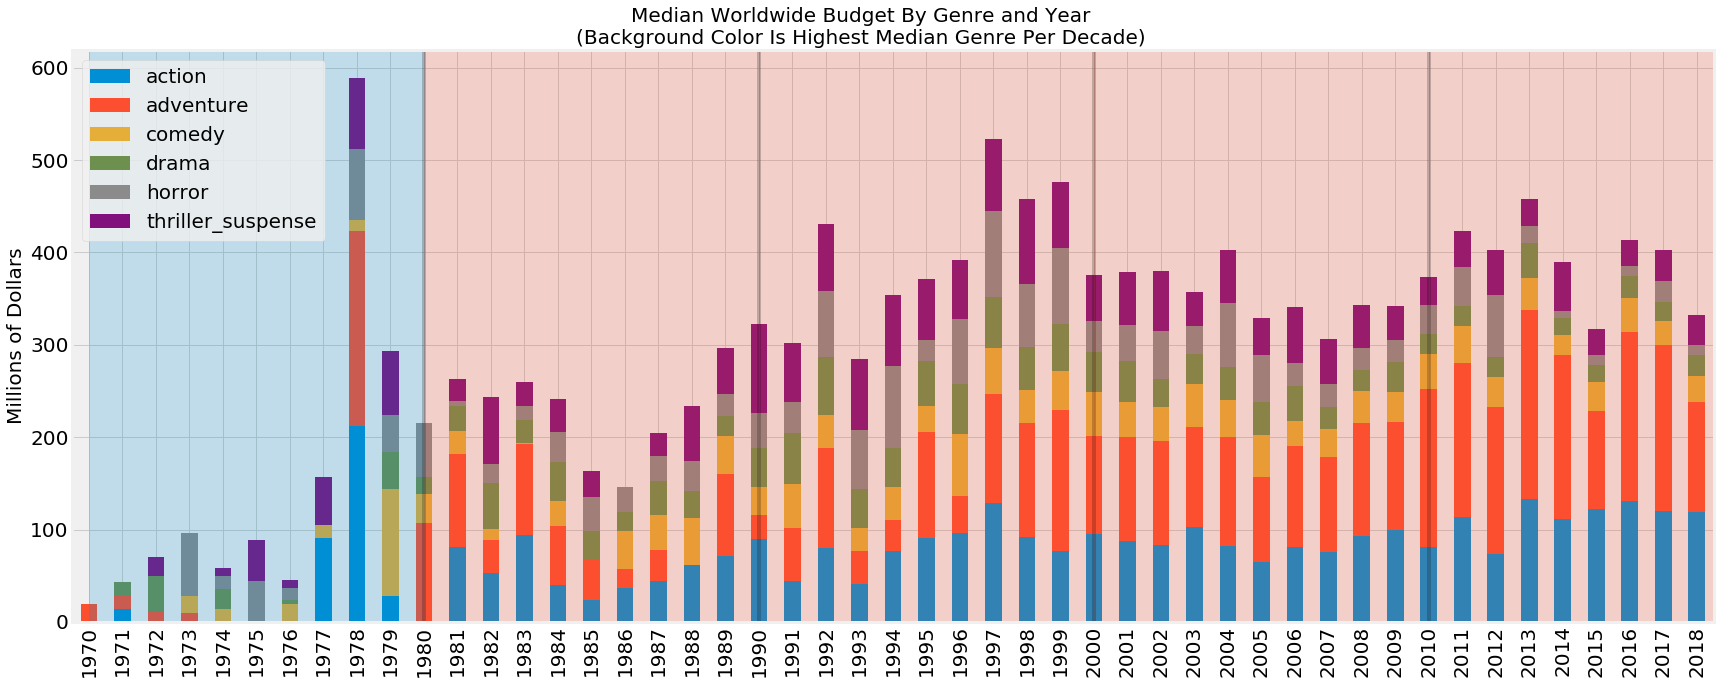

In [59]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Worldwide Budget By Genre and Year\n(Background Color Is Highest Median Genre Per Decade)', fontsize=20, y=1.05)

# Determine background colors for each decade
grp = data.groupby('release_decade')[budget_columns].median() / 1000000000
bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

grp = data.groupby('release_year')[budget_columns].median() / 1000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)
axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
axis.axvline(10, color='k', alpha=0.2)
axis.axvline(20, color='k', alpha=0.2)
axis.axvline(30, color='k', alpha=0.2)
axis.axvline(40, color='k', alpha=0.2)

plt.tight_layout()

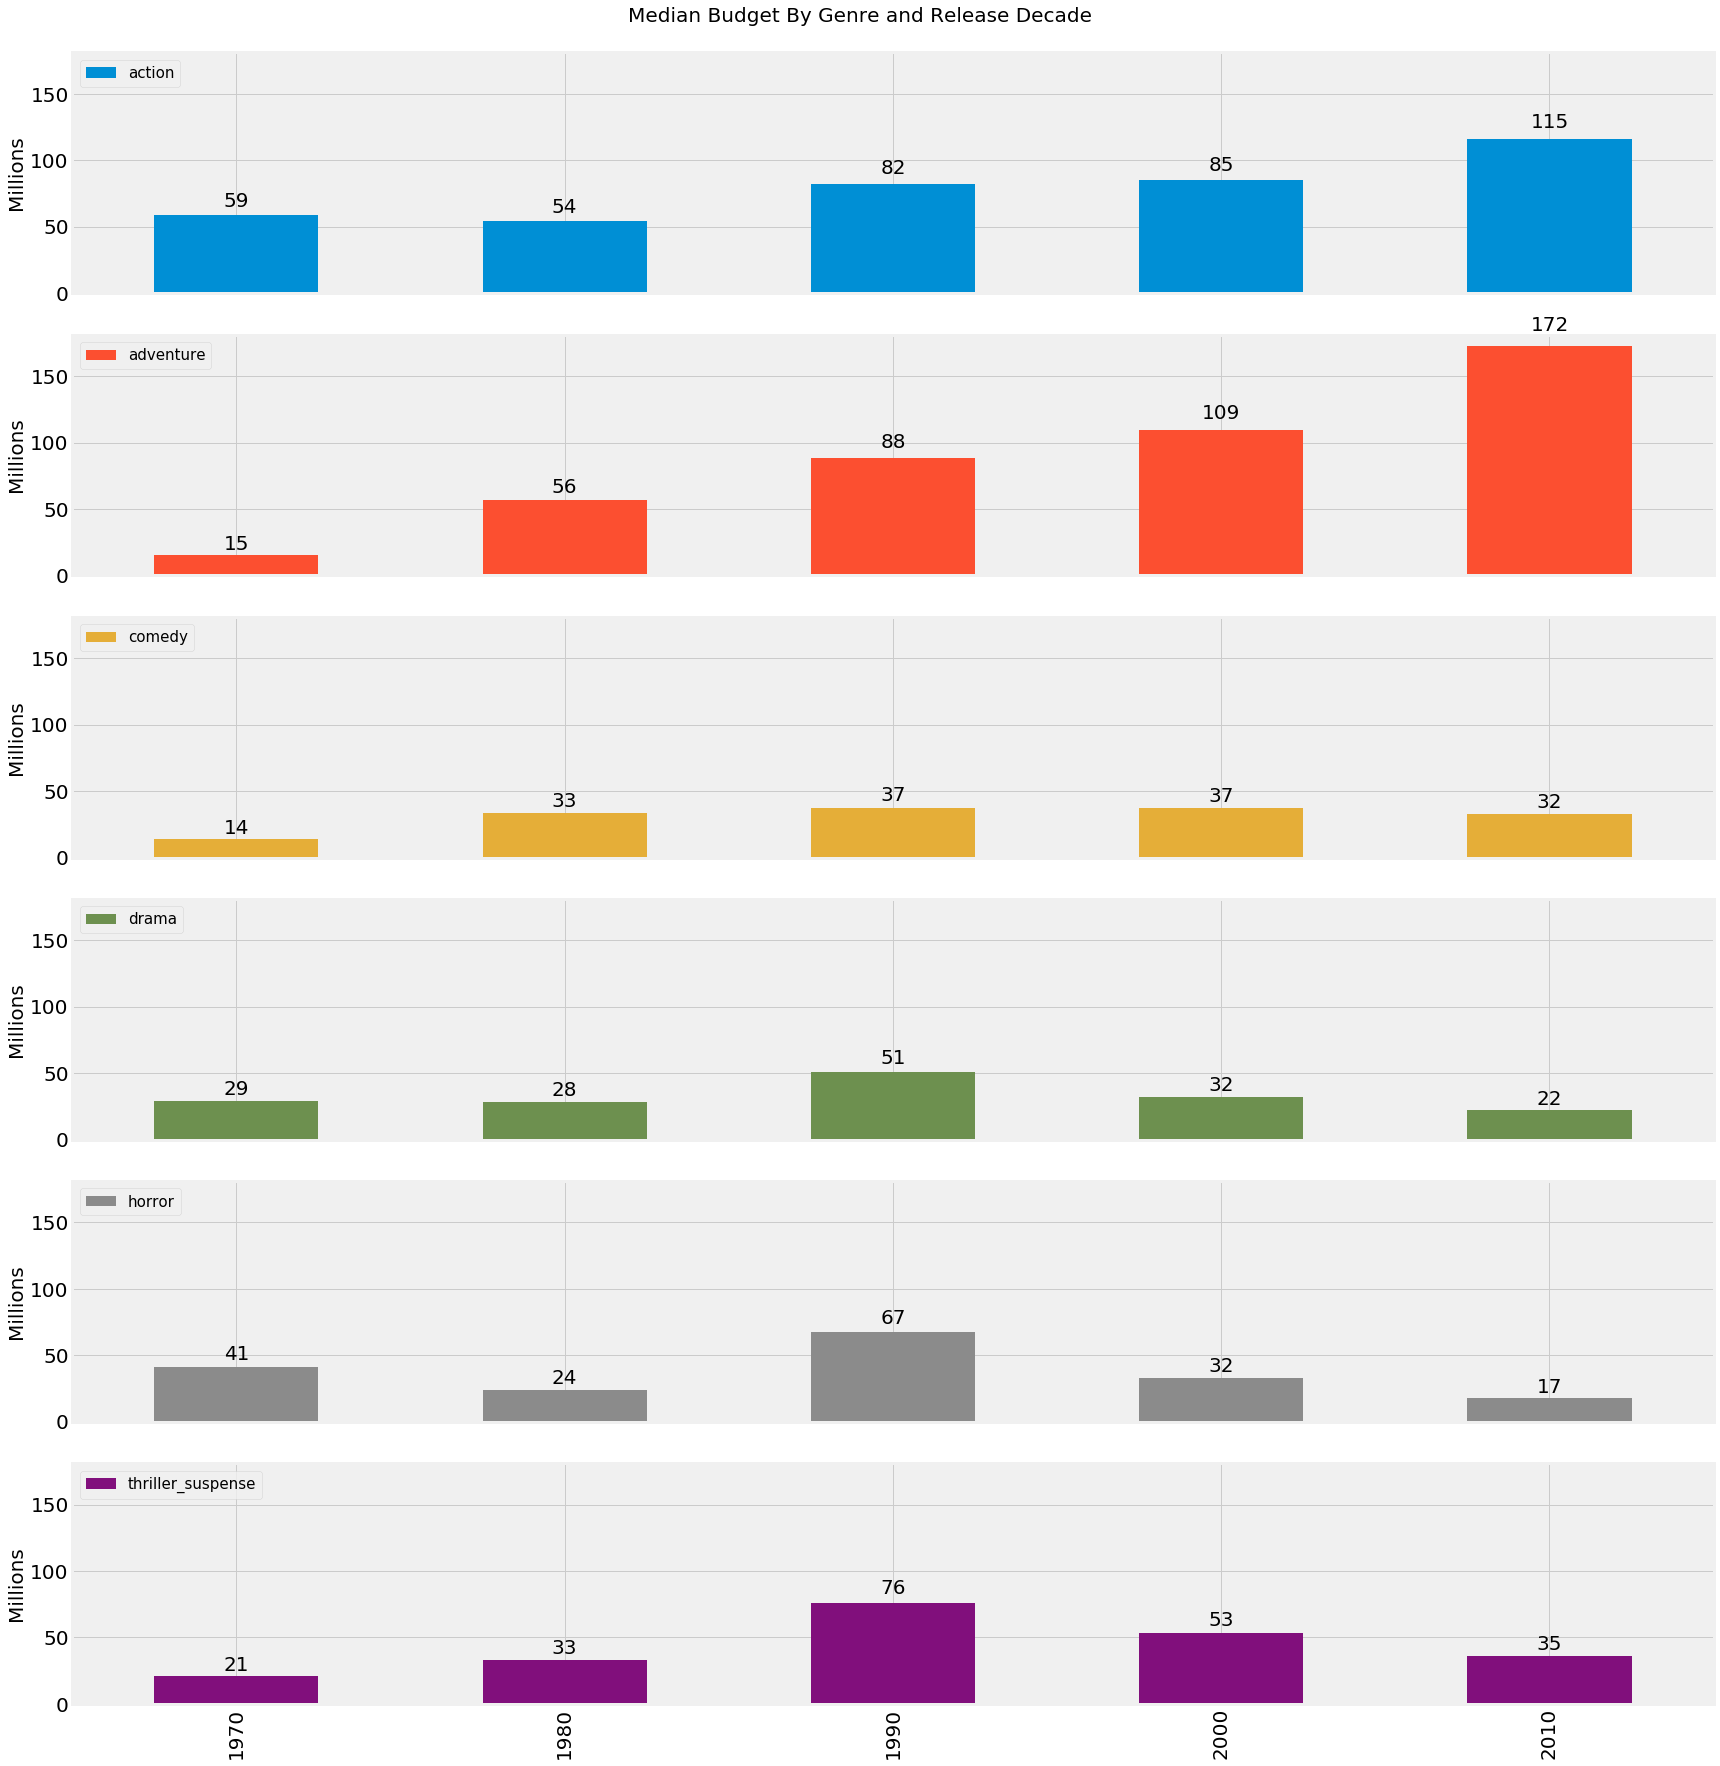

In [368]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Median Budget By Genre and Release Decade', figsize=(24,24), 
                                      colors=colors, groupby_column='release_decade', stat_column='budget_adj', 
                                      aggregation_function='median', apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      xtick_values=range(1970, 2020, 10), y_label='Millions', axhline_needed=False, axhline_value='')

## Quick Takeaways 

**Mean and median pretty much the same**
  - There's not much difference between the shapes of the mean and median in terms of budgets
  
**Since the 1990s**
  - Budgets have decreased since the 1990s for all genres except Action and Adventure, whose budgets have increased substantially
  
**Action and Adventure**
  - Action had the highest median budget in the 1970s. Since then, Adventure has the highest.

## Profits

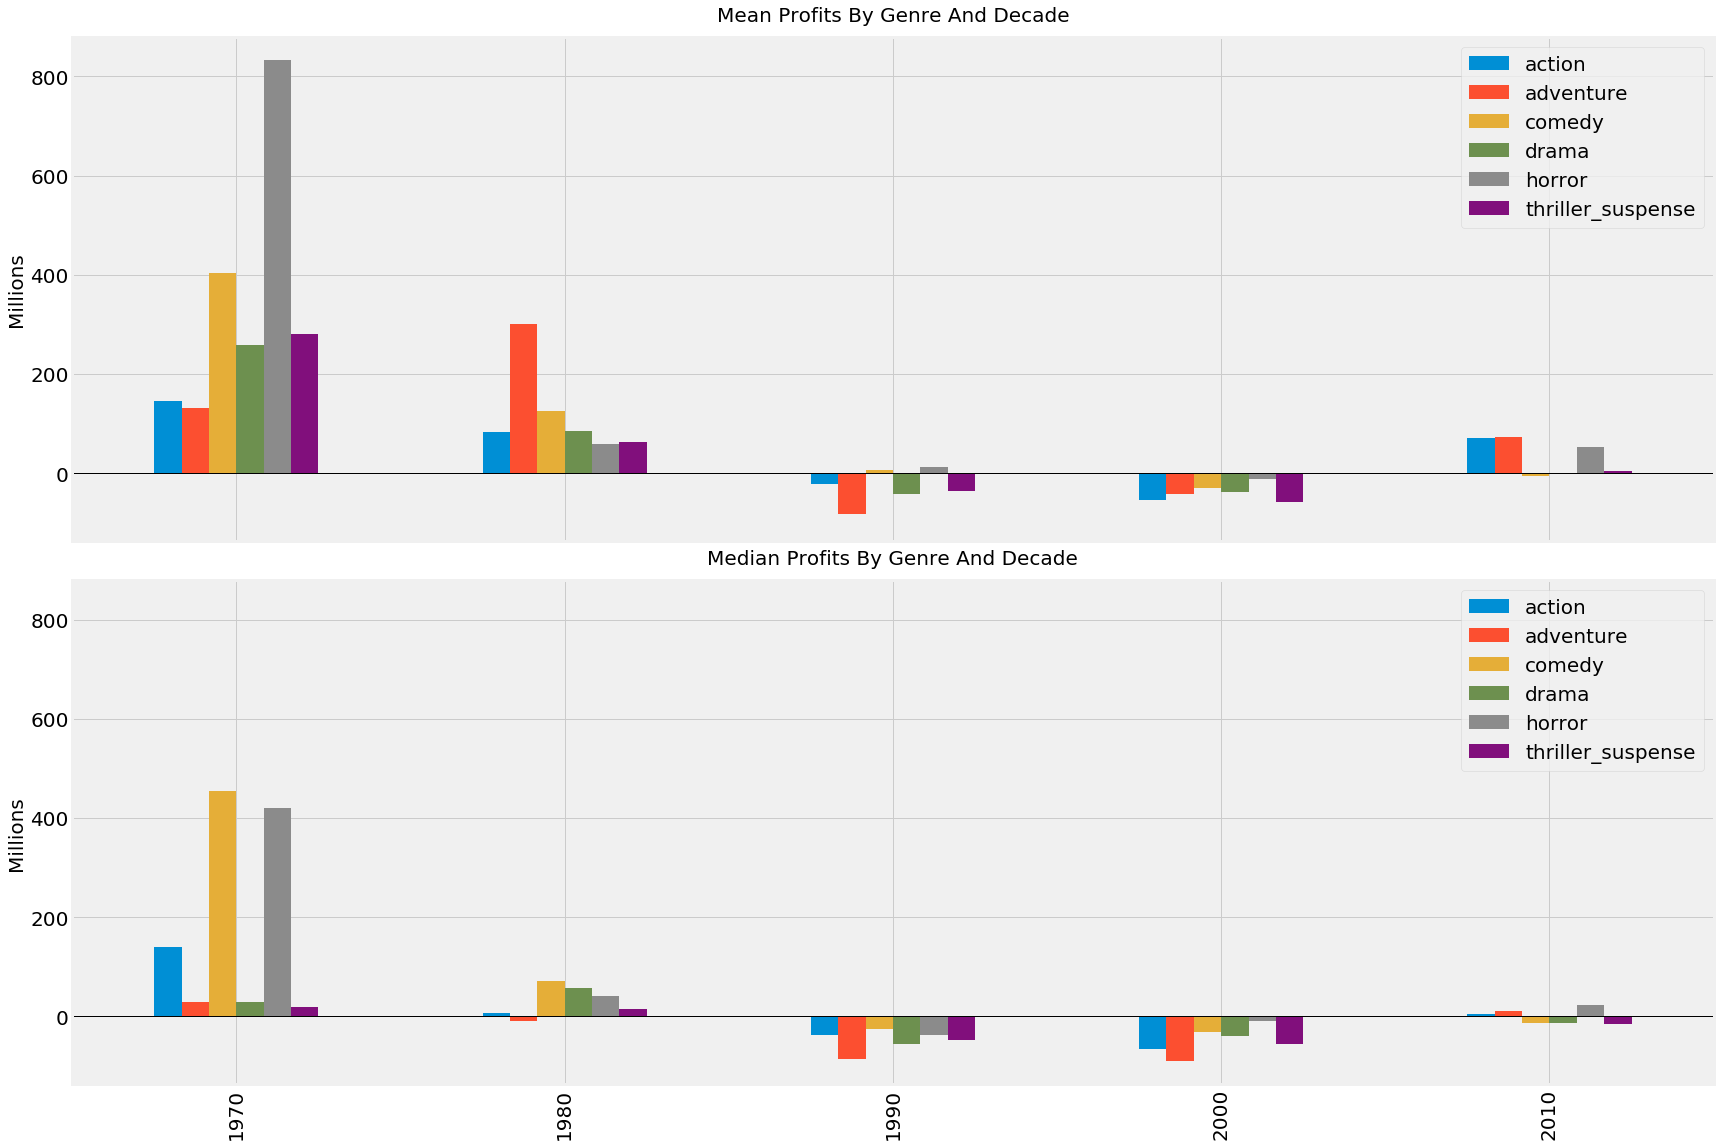

In [389]:
plot_mean_and_median_by_time_and_stat(data=data, genres=genres, groupby_column='release_decade', 
                                      stat_columns=profit_columns, stat_name_for_title='Profits', 
                                      apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      y_label='Millions', y_ticks_needed=False, y_ticks='', axhline_needed=True, axhline_value=0)

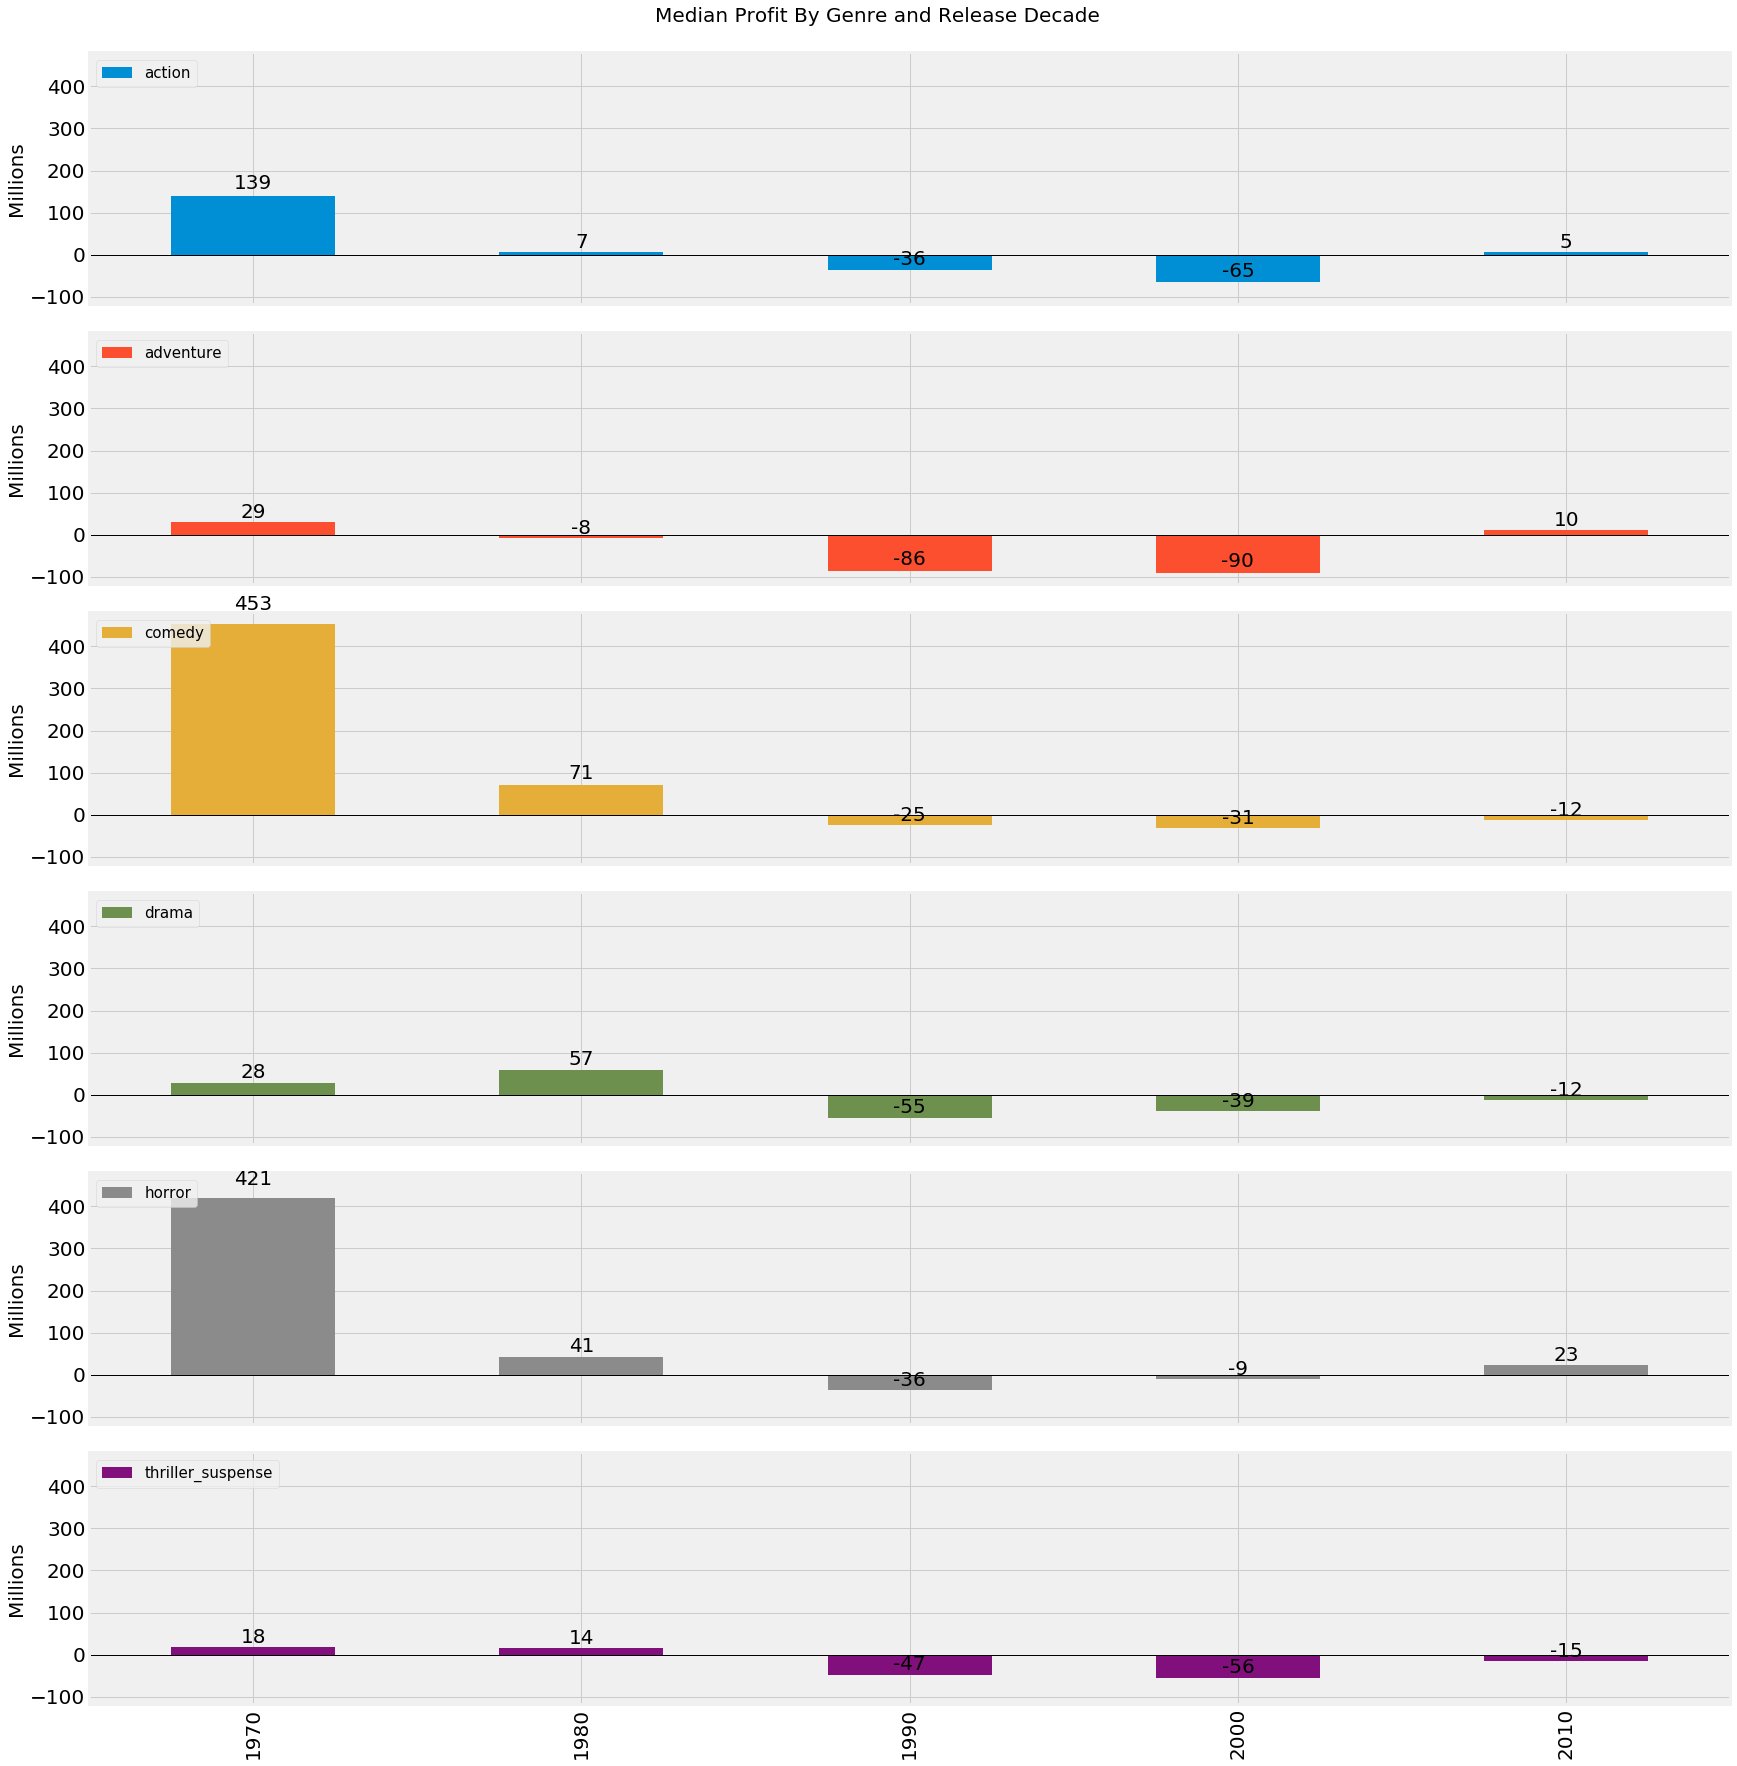

In [369]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Median Profit By Genre and Release Decade', figsize=(24,24), 
                                      colors=colors, groupby_column='release_decade', stat_column='profit', 
                                      aggregation_function='median', apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      xtick_values=range(1970, 2020, 10), y_label='Millions', axhline_needed=True, axhline_value=0)

## Quick Takeaways

**The average movie is not a winner**
  - From the 1990s onwards, most genres have had a negative median profit. In other words, they are net losers of money.
  - In the 1990s, no genre had a positive median profit.
  - In the 2000s, no genre had a positive median profit.
  - In the 2010s, Horror has the best median profit of \\$23 million, followed by Adventure at \\$10 million and Action at \\$5 million.

## Breakeven Percentage

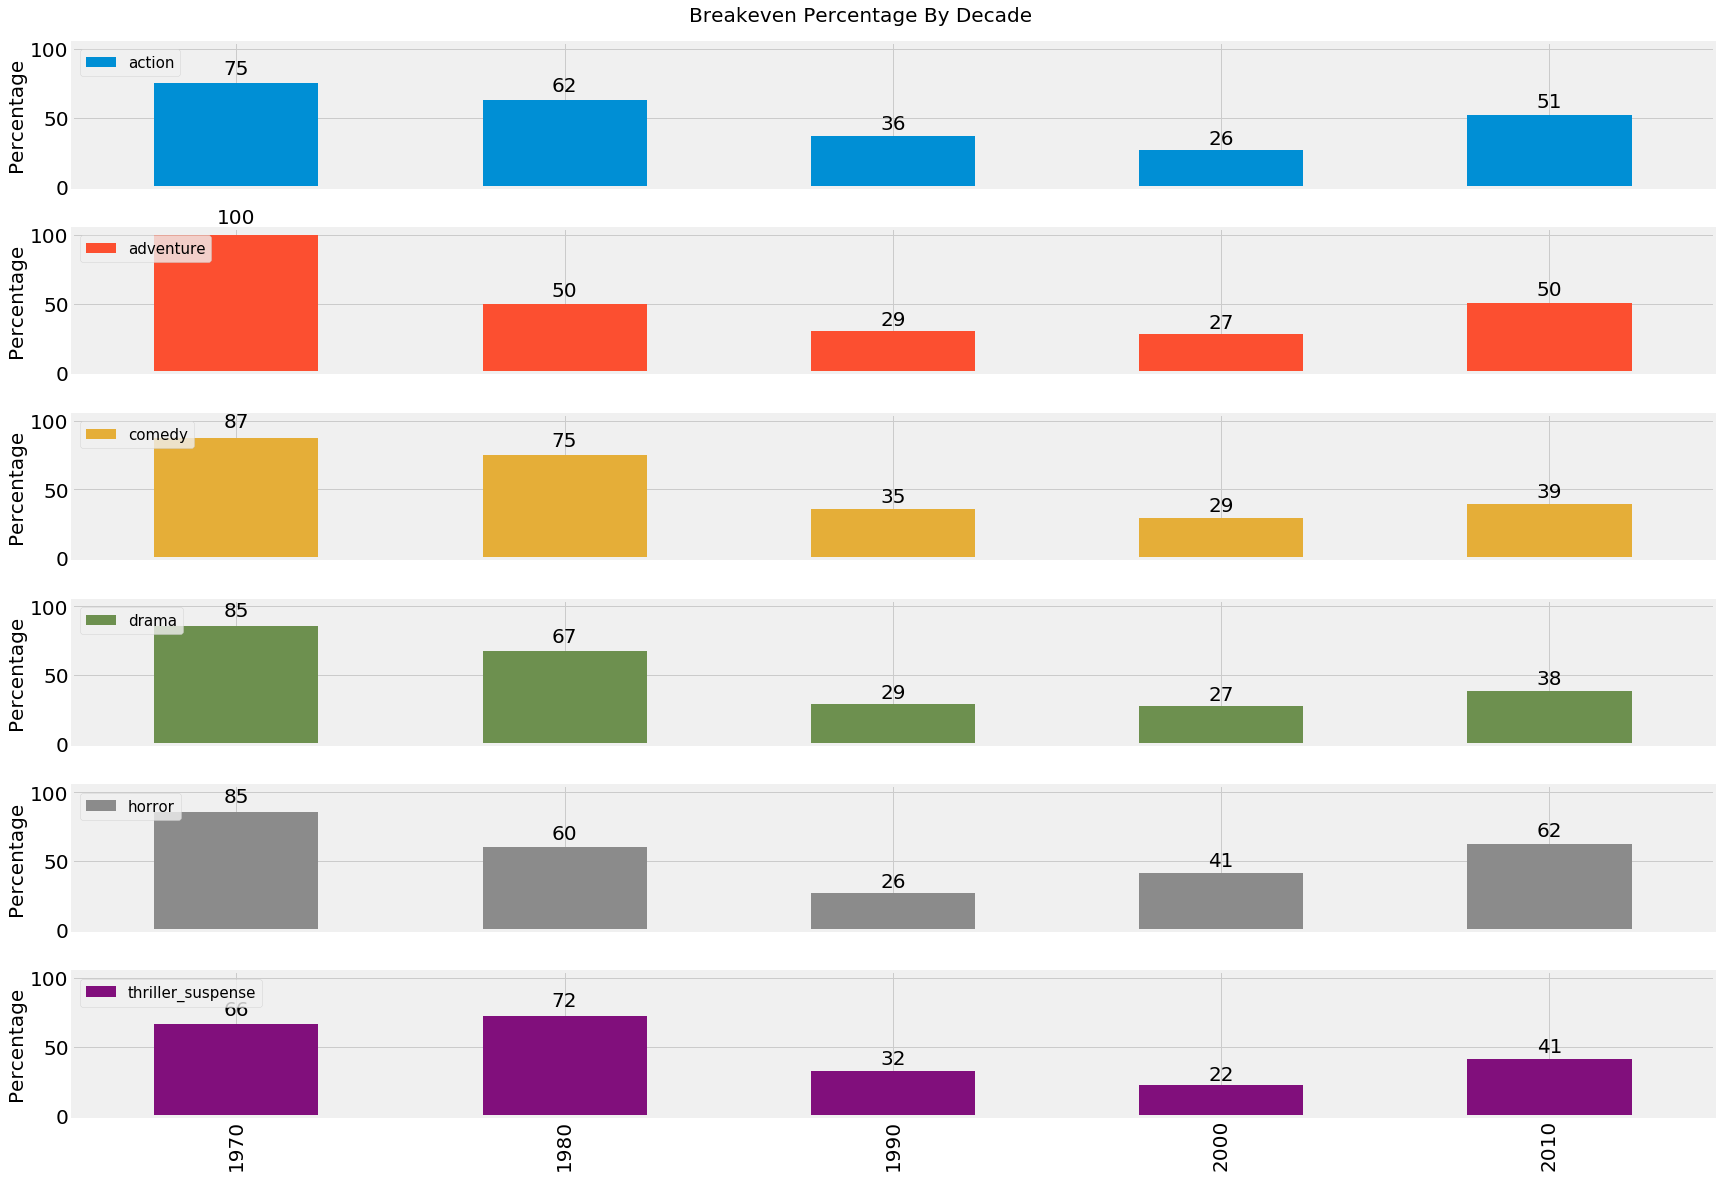

In [370]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Breakeven Percentage By Decade', figsize=(24,16), 
                                      colors=colors, groupby_column='release_decade', stat_column='worldwide_breakeven', 
                                      aggregation_function='mean', apply_needed=True, apply_function=lambda x: x * 100, 
                                      xtick_values=range(1970, 2020, 10), y_label='Percentage', axhline_needed=False, axhline_value='')

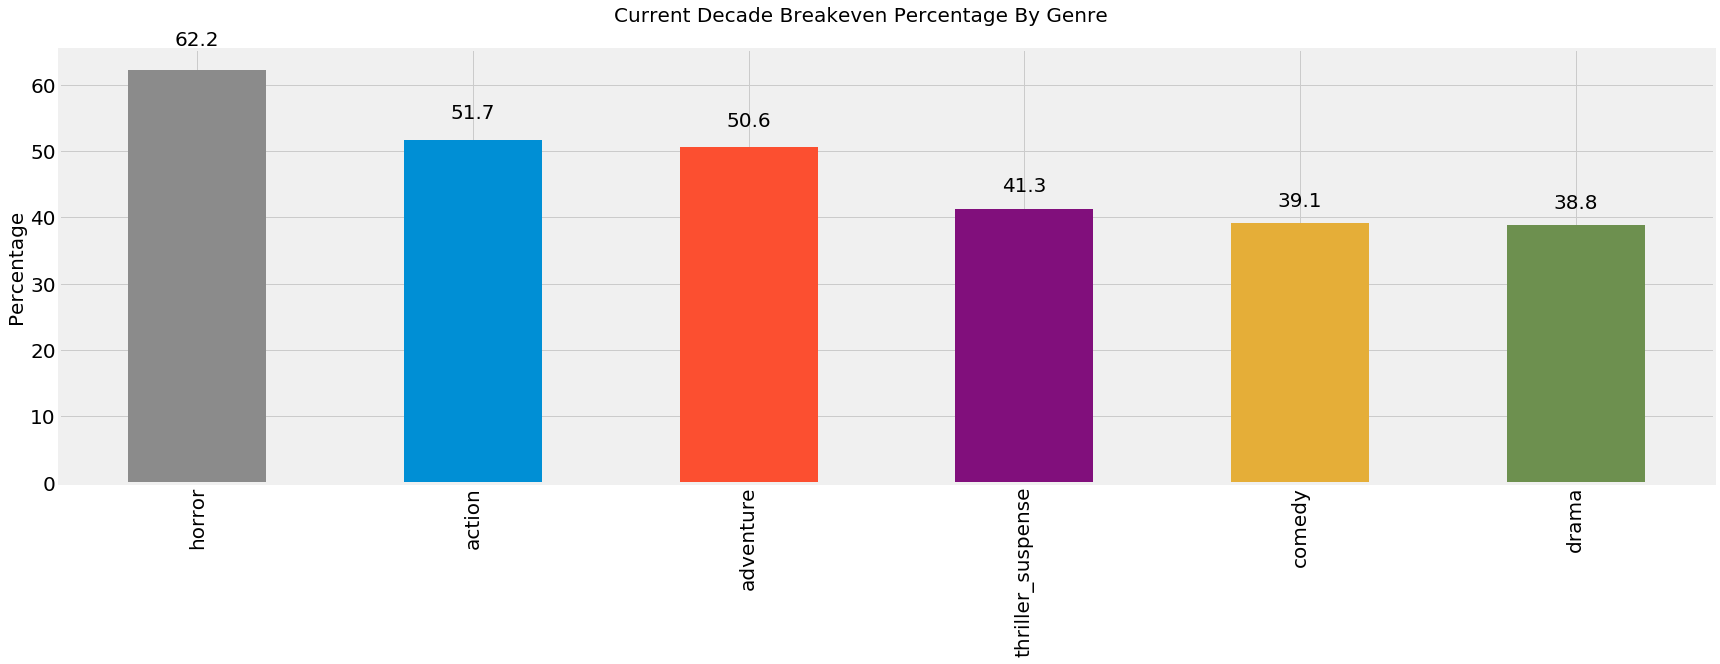

In [289]:
plot_summary_dataframe(summary=summary, 
                       sort_column='current_decade_breakeven_percentage',
                       plot_columns='current_decade_breakeven_percentage', 
                       title='Current Decade Breakeven Percentage By Genre', 
                       colors_needed=1, 
                       legend_needed=False, 
                       legend_text=[], 
                       y_label='Percentage', 
                       num_decimals=1)

## Quick Takeaways

**1970s to 2000s**
  - Overall, there was a big decrease in a a movie's probability of breaking even
  - The exceptions are Thriller/Suspense's bump in the 1980s and Horror's bump in the 2000s
  
**2000s to 2010s**
  - All genres have seen a boost to their probability of breaking even in the last decade

**Safest current genres**
  - Horror is by far the safest worldwide release genre with a 62% chance of at least breaking even
  - Action and Adventure are the next safest from a breakeven perspective at around 50% each
  - Comedy and Drama have the worst odds of breaking even
  
**Movies are risky today**
  - From a breakeven standpoint, movies are safer today than they were in the 1990s or 2000s
  - However, the best chance a movie has to breakeven in aggregate is still only 62% for Horror
  - Movies are still a big risk

## Breaking Down By Subgenres

The movie business is so variable that looking at trends within subgenres probably doesn't yield much actionable insight.

But we shall look at mean and median profitability of subgenres by decade just in case.

In [65]:
# Function to plot mean and median profitability by subgenre by decade
def subgenre_profitability_by_decade(genre, colors):
    subgenres = data[data[genre.lower()]].groupby('genres_mojo').count().index
    num_subgenres = len(subgenres)
    
    figure, axes = plt.subplots(nrows=num_subgenres, ncols=1, figsize=(24, 50), sharex=True)
    figure.suptitle('Mean and Median Profit By {} Subgenre And Decade'.format(genre.title()), fontsize=20, y=1.02)

    for subgenre, axis in zip(subgenres, axes.flat):
            grp = (data[data['genres_mojo'] == subgenre].groupby('release_decade').agg(['mean', 'median']) / 1000000)['profit']

            # If the series is missing a decade, add it as an index and set the value to zero
            for decade in range(1970, 2020, 10):
                if decade not in grp.index:
                    grp.loc[decade] = 0

            # Sort the series by its index to have the decades in chronological order                
            grp.sort_index(ascending=True, inplace=True)
 
            grp.plot(kind='bar', xticks=range(1970, 2020, 10), color=colors, linewidth=3, ax=axis)

            axis.set_ylabel('Millions', fontsize=20)
            axis.set_title(subgenre, fontsize=20)
            axis.legend(['Mean', 'Median'], loc='lower left', fontsize=15)
            axis.set_xlabel('')
            axis.tick_params(labelsize=20)
            axis.axhline(0, color='k', linewidth=1)

            autolabel(axis)

    plt.tight_layout()

### Action Subgenres By Decade

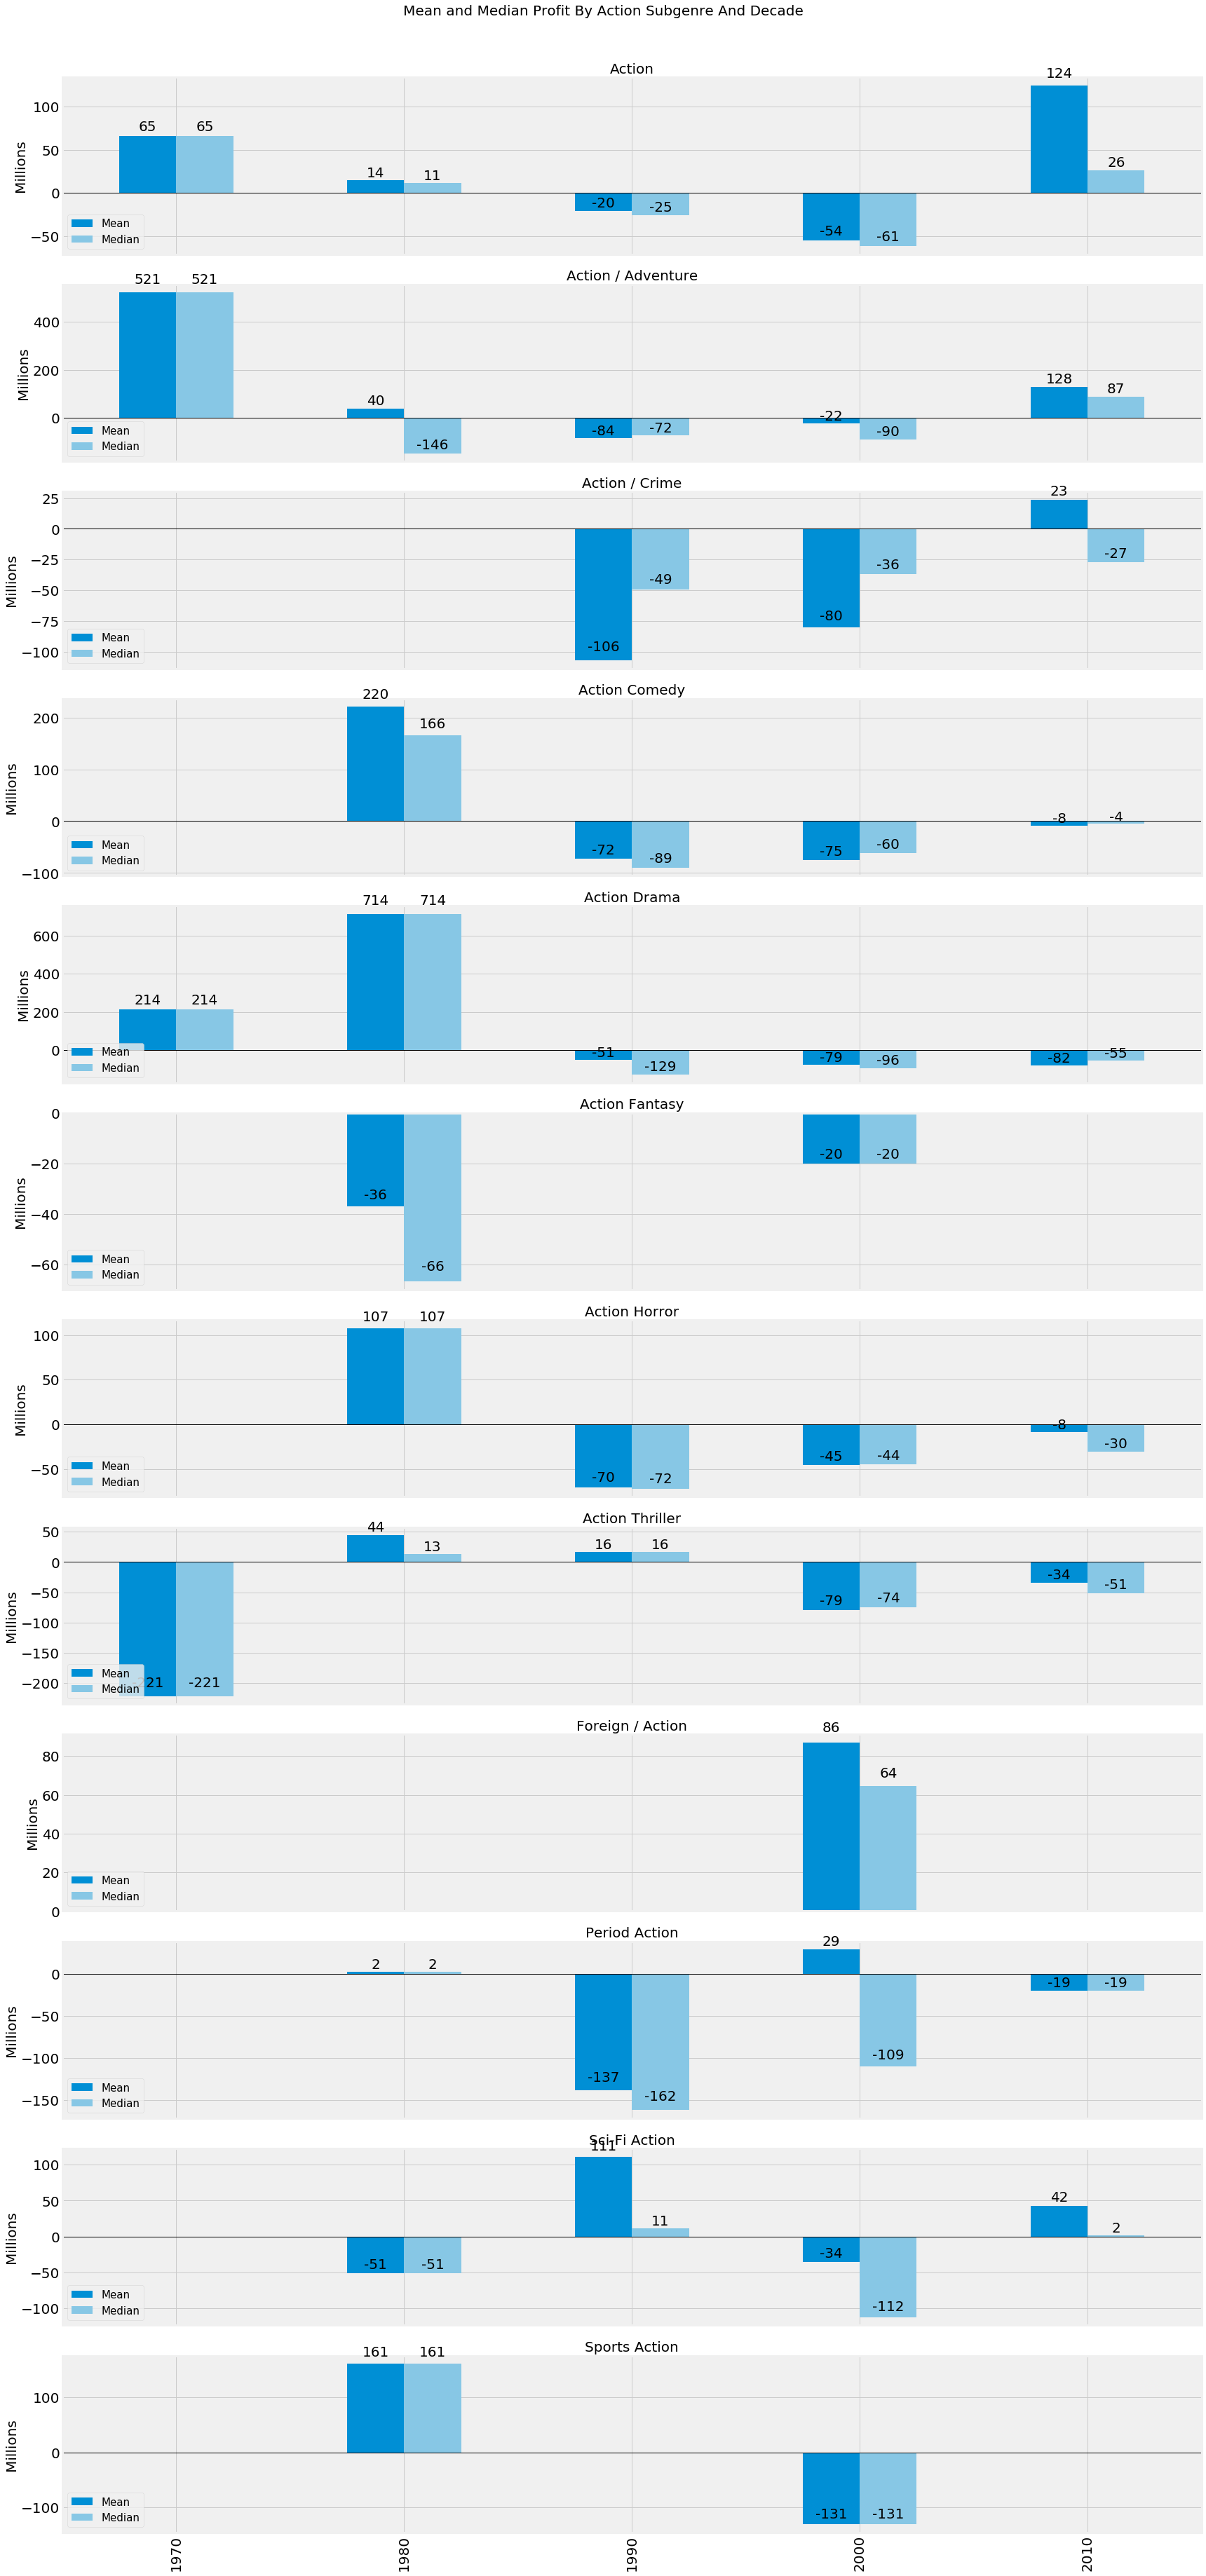

In [66]:
subgenre_profitability_by_decade('action', [genres_dict['action']['color1'], genres_dict['action']['color2']])

### Quick Takeaways

There's no clear best subgenre. There's too much variance by decade. In the current decade, the only subgenres with positive median profits are Action/Adventure, Action, and Sci-Fi Action.

### Adventure Subgenres By Decade

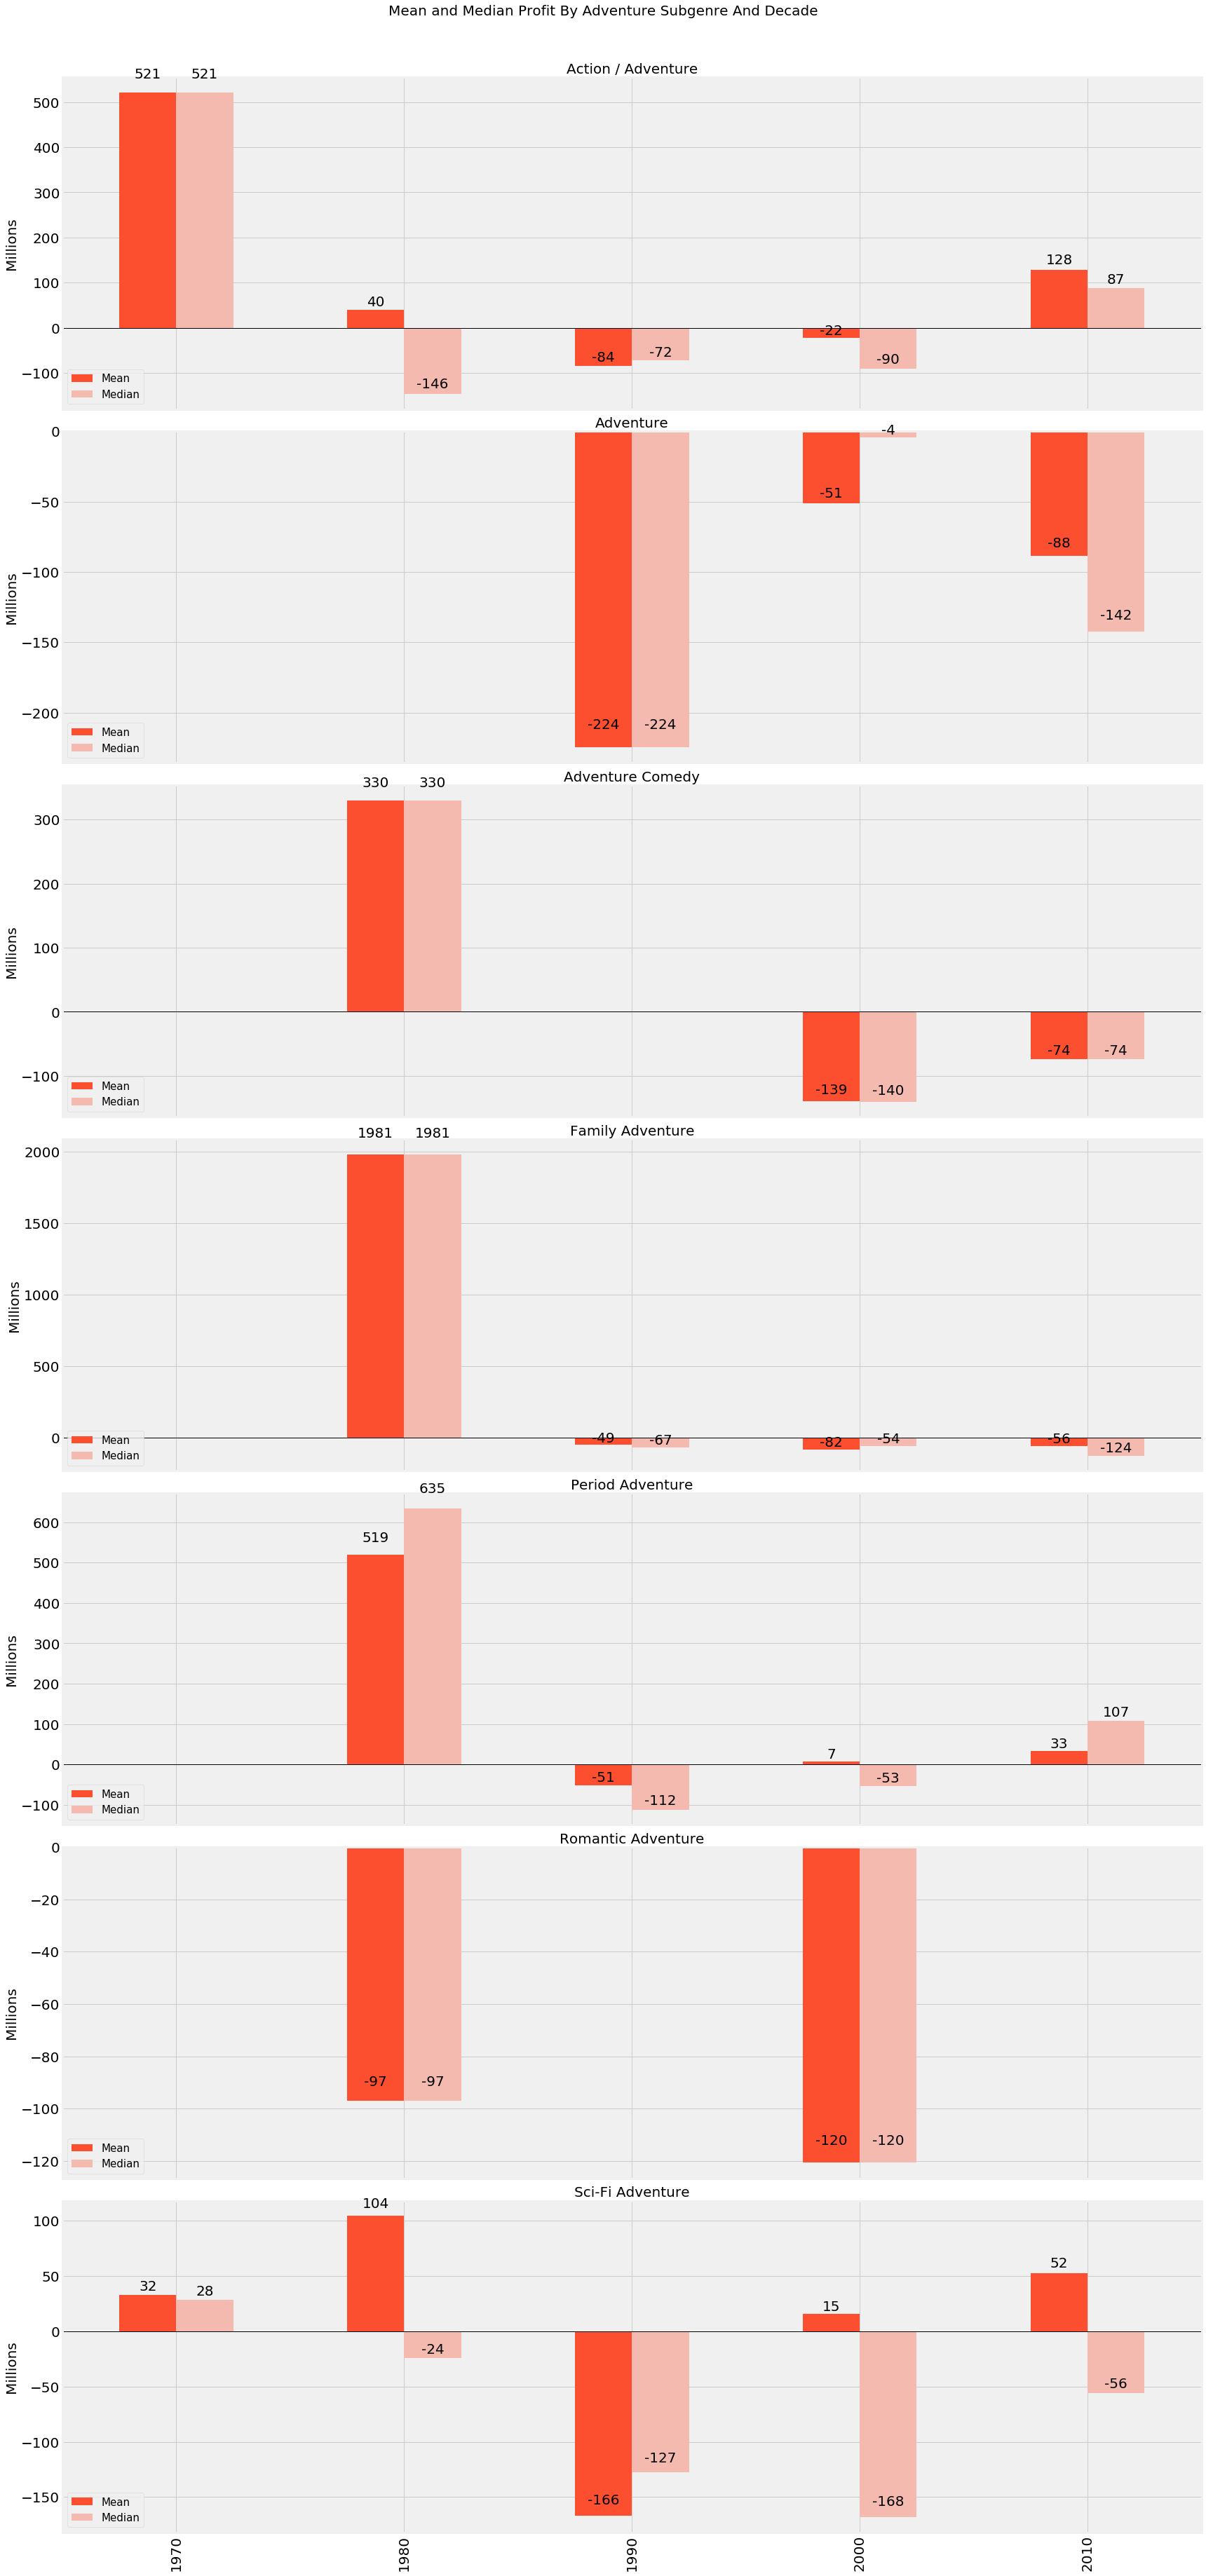

In [67]:
subgenre_profitability_by_decade('adventure', [genres_dict['adventure']['color1'], genres_dict['adventure']['color2']])

### Quick Takeaways

Period Adventure, Action/Adventure, and Adventure are the only profitable subgenres this decade.

### Comedy Subgenres By Decade

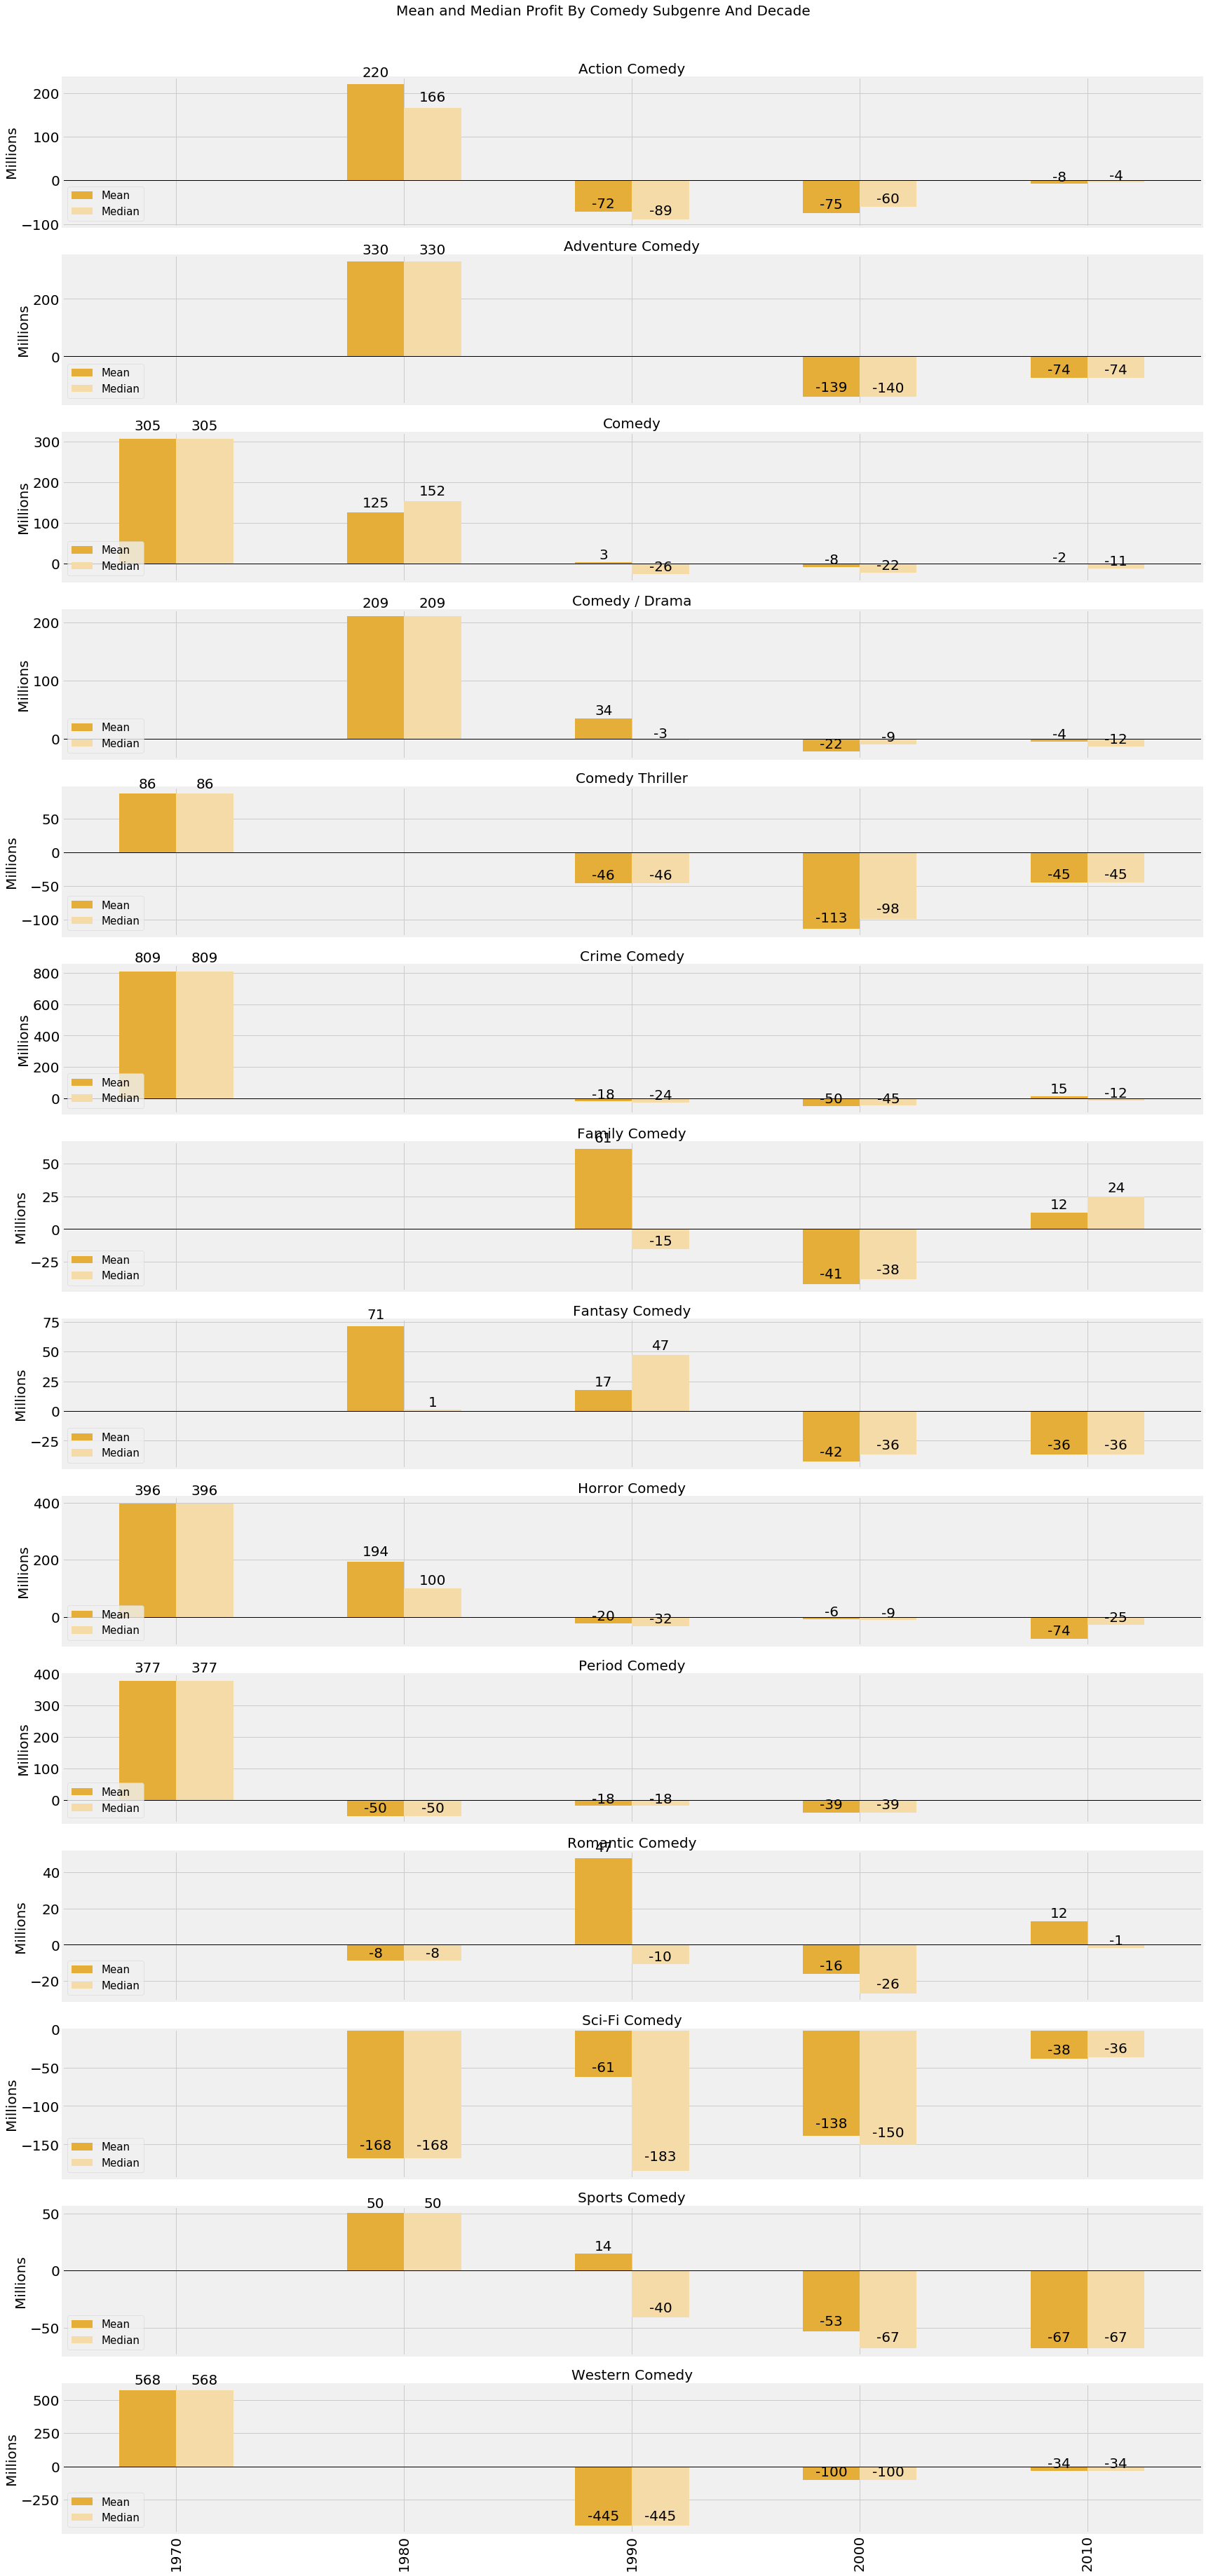

In [68]:
subgenre_profitability_by_decade('comedy', [genres_dict['comedy']['color1'], genres_dict['comedy']['color2']])

### Quick Takeaways

Median profitability of comedies since the 1990s hasn't been great, with most subgenres in the red for most if not all of the last three decades.

The only subgenre with positive median profitability in the 2010s is Family Comedy.

### Drama Subgenres By Decade

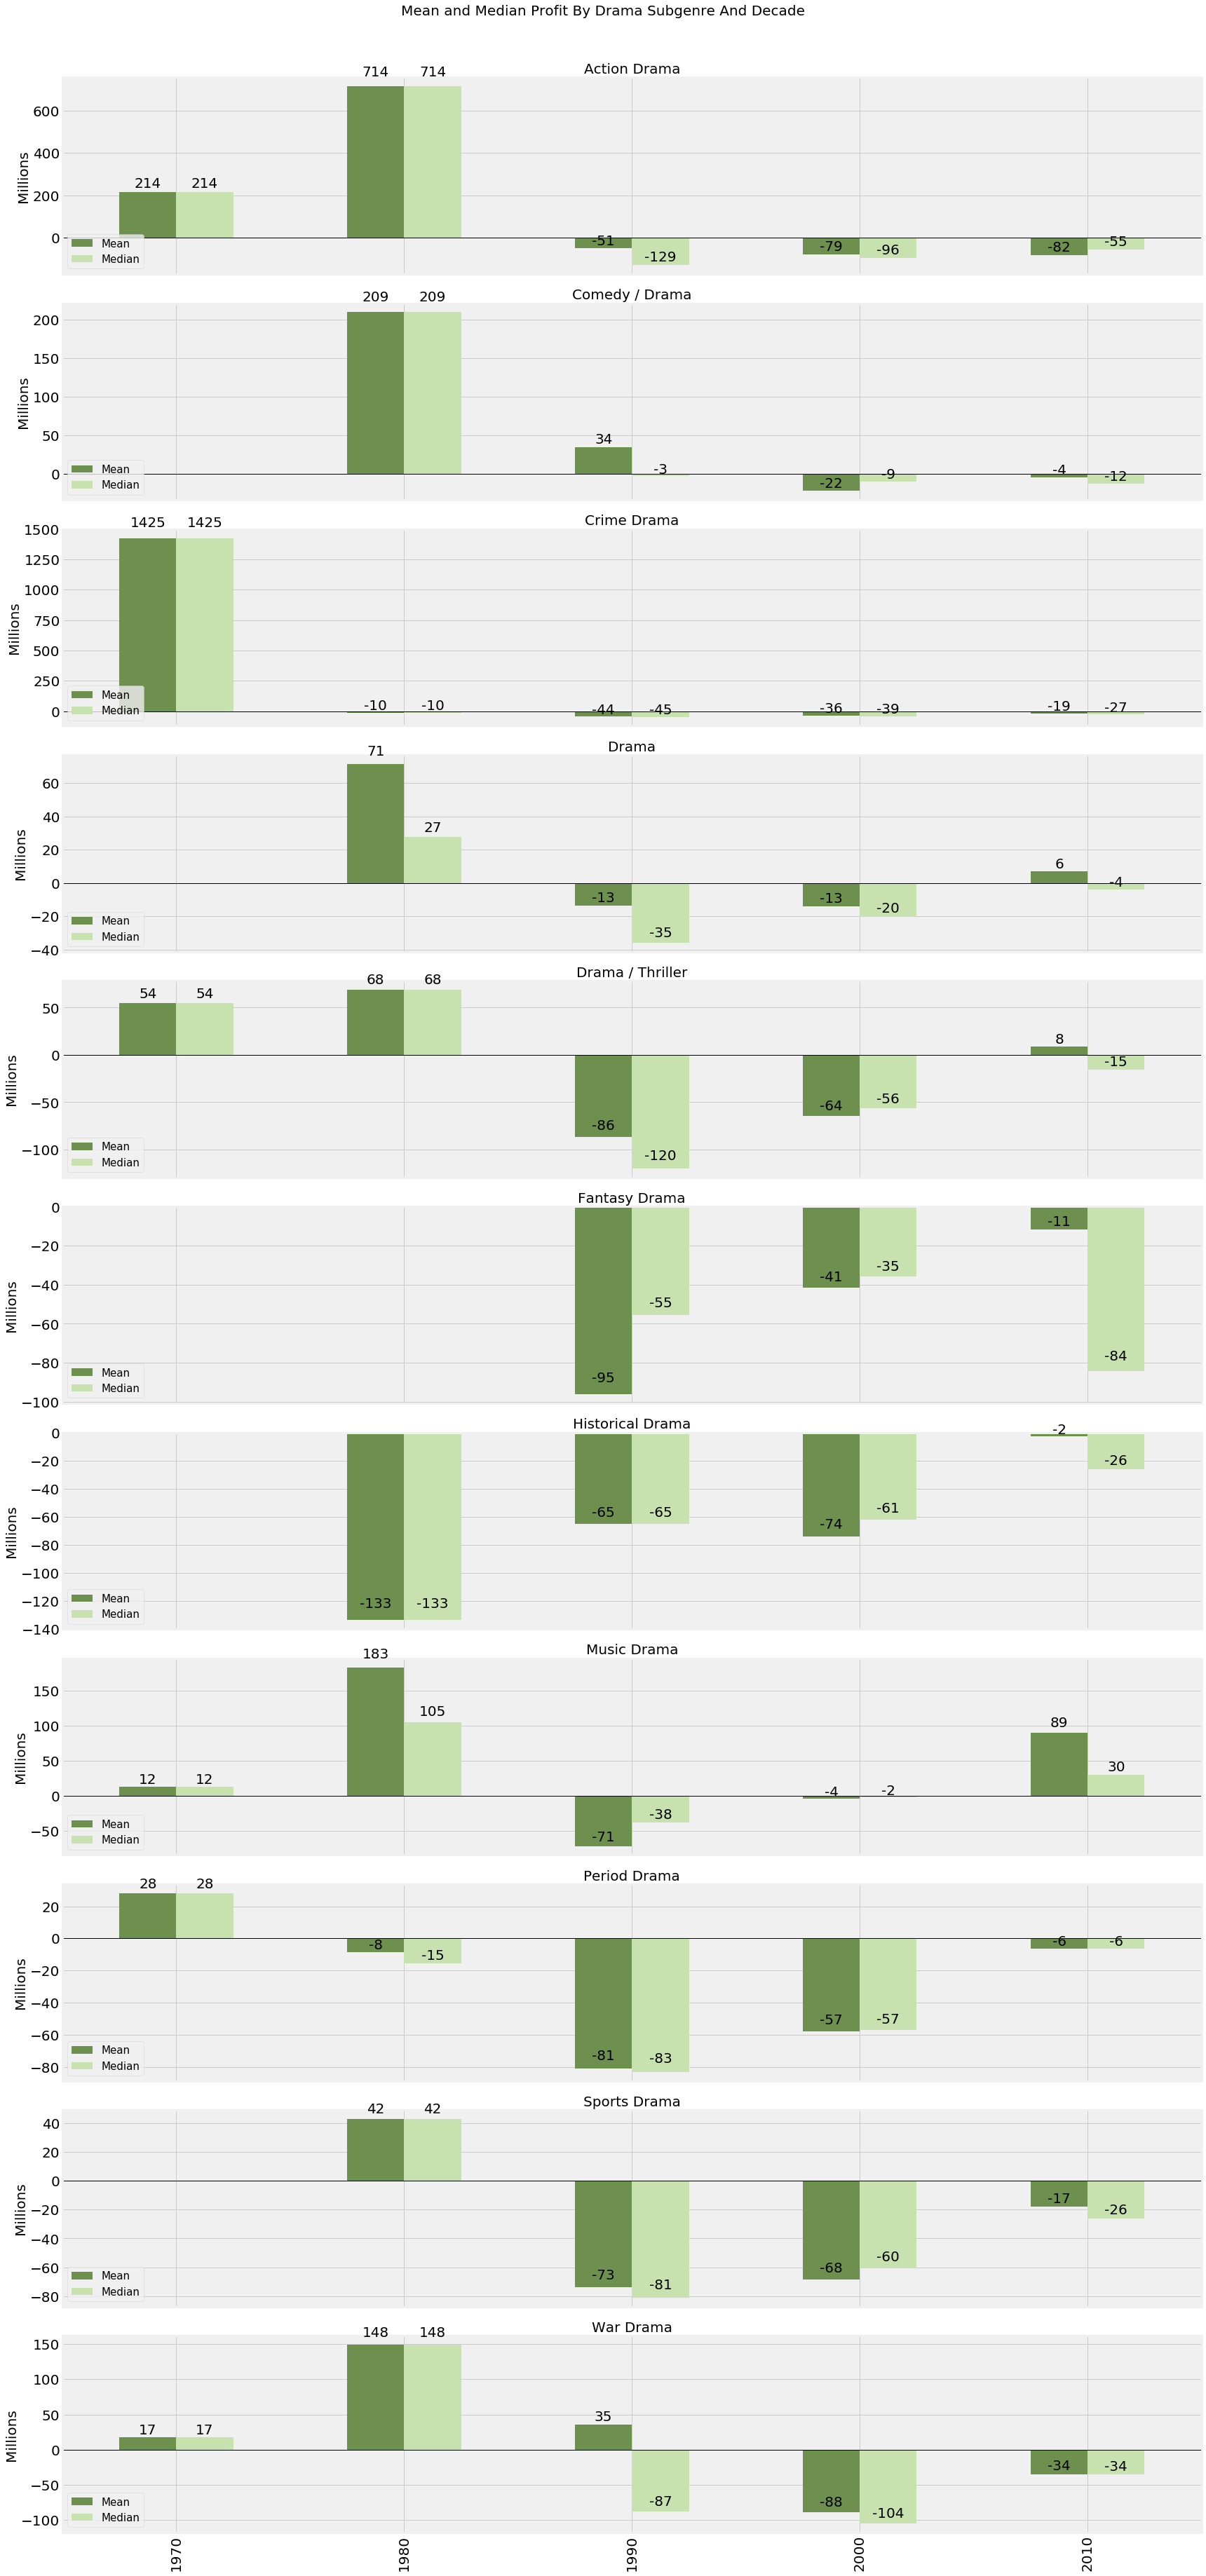

In [69]:
subgenre_profitability_by_decade('drama', [genres_dict['drama']['color1'], genres_dict['drama']['color2']])

### Quick Takeaways

Only Music Drama has a positive median profitability this decade.

### Horror Subgenres By Decade

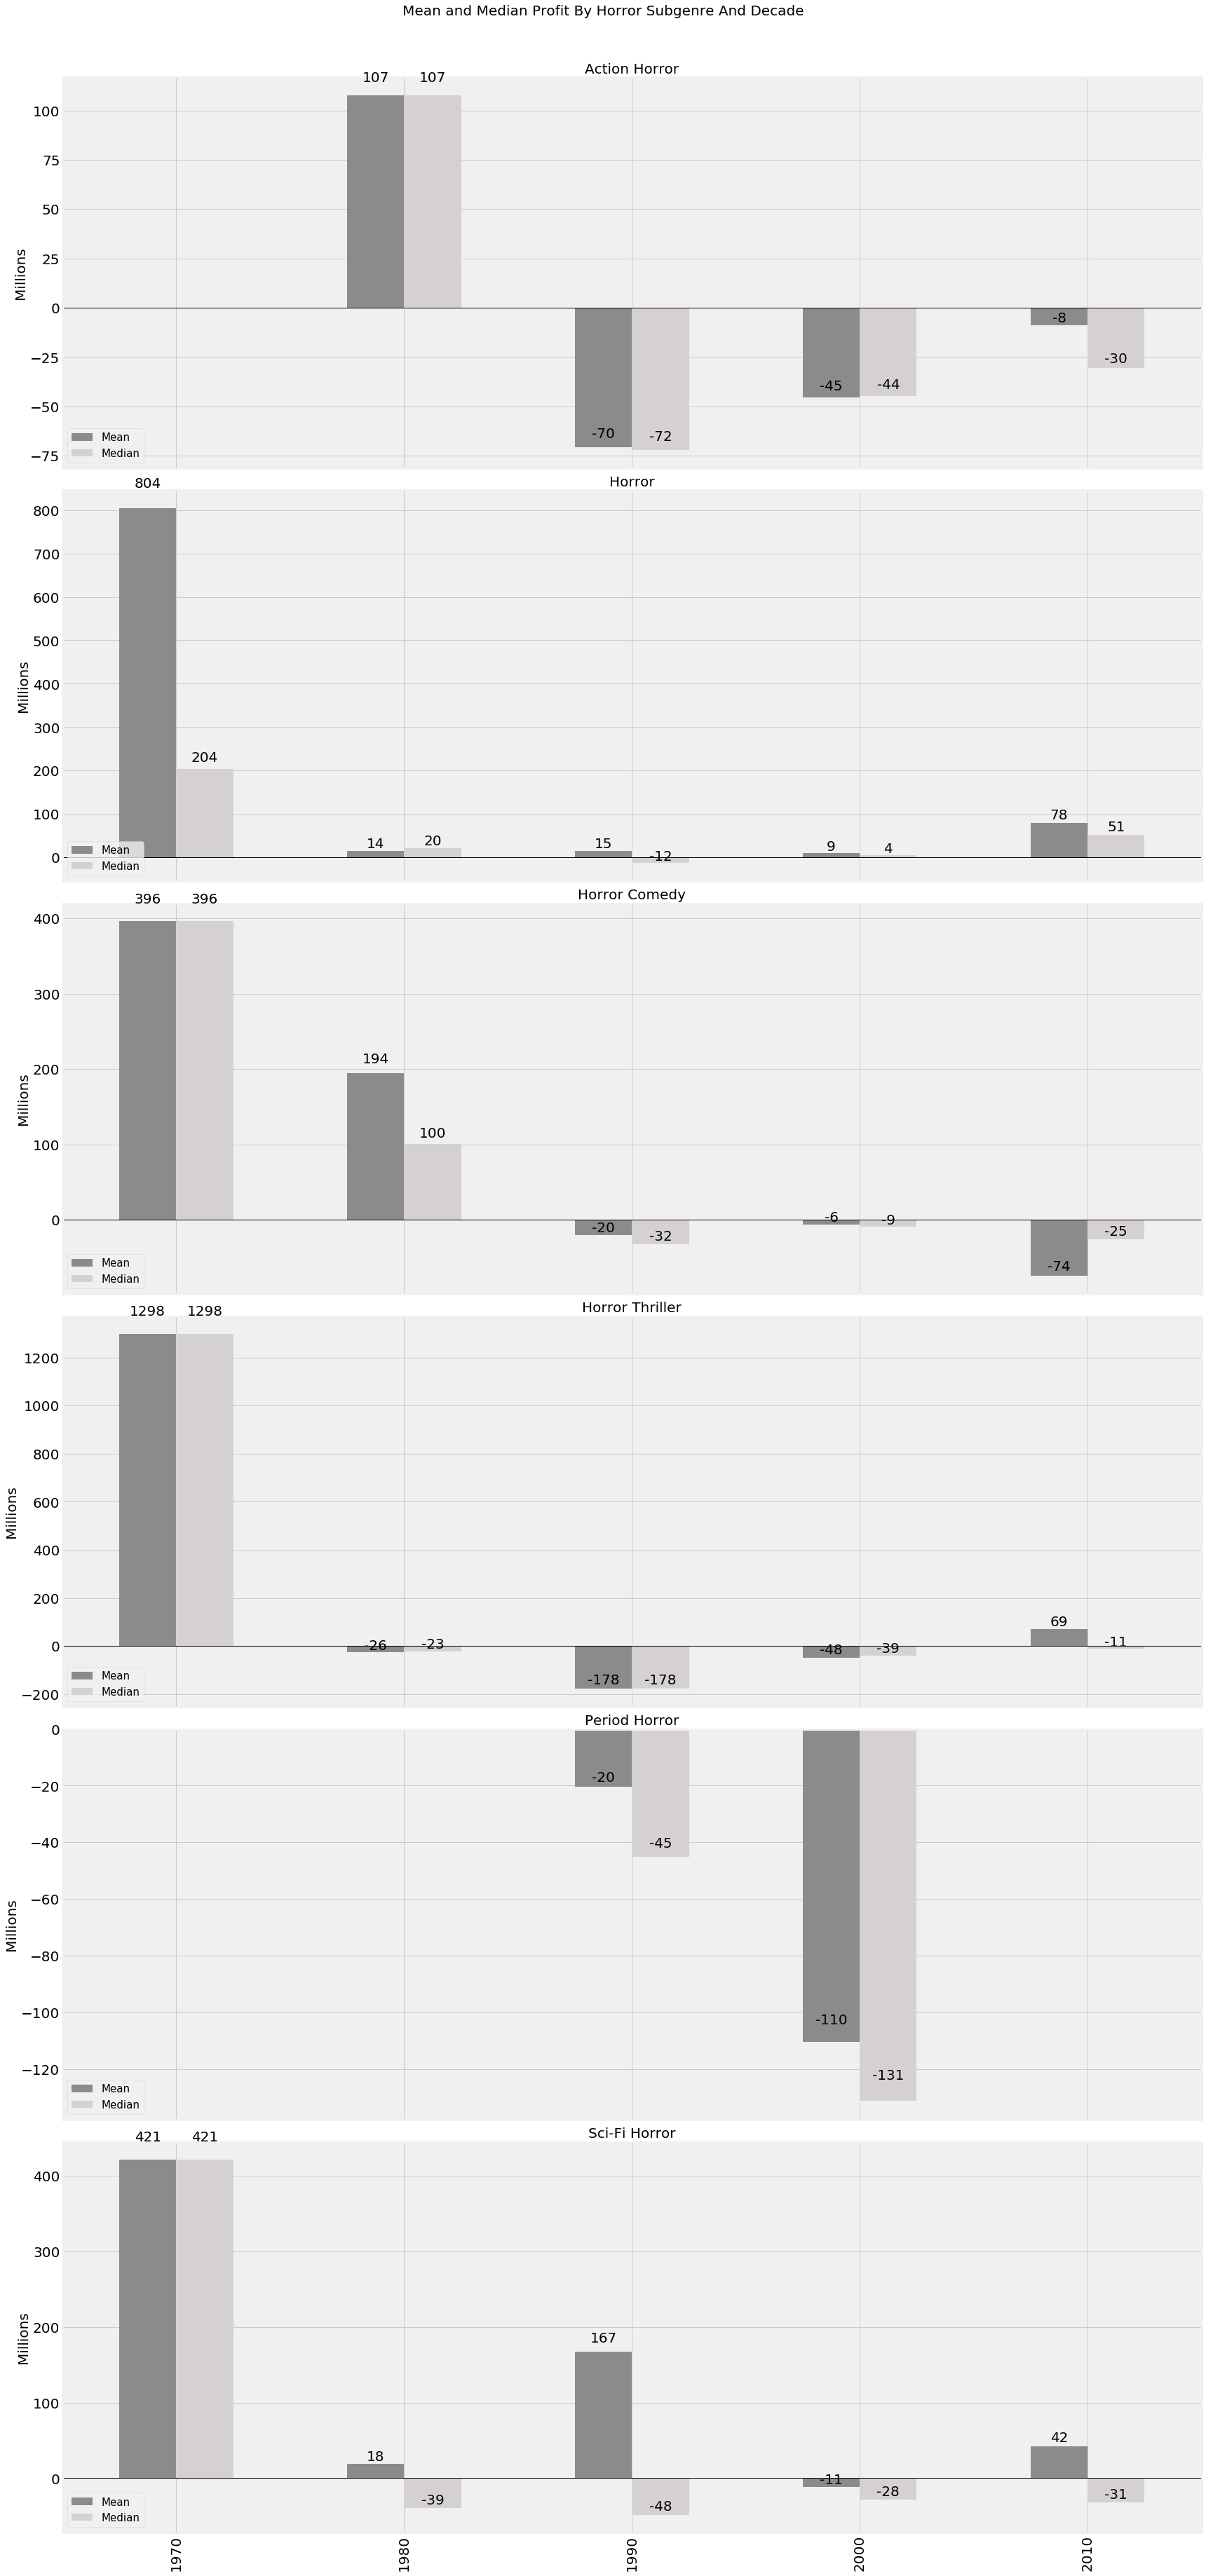

In [70]:
subgenre_profitability_by_decade('horror', [genres_dict['horror']['color1'], genres_dict['horror']['color2']])

### Quick Takeaways

Only movies labeled as just Horror have a positive median profitability this decade. All other subgenres have negative median profitability.

### Thriller/Suspense Subgenres By Decade

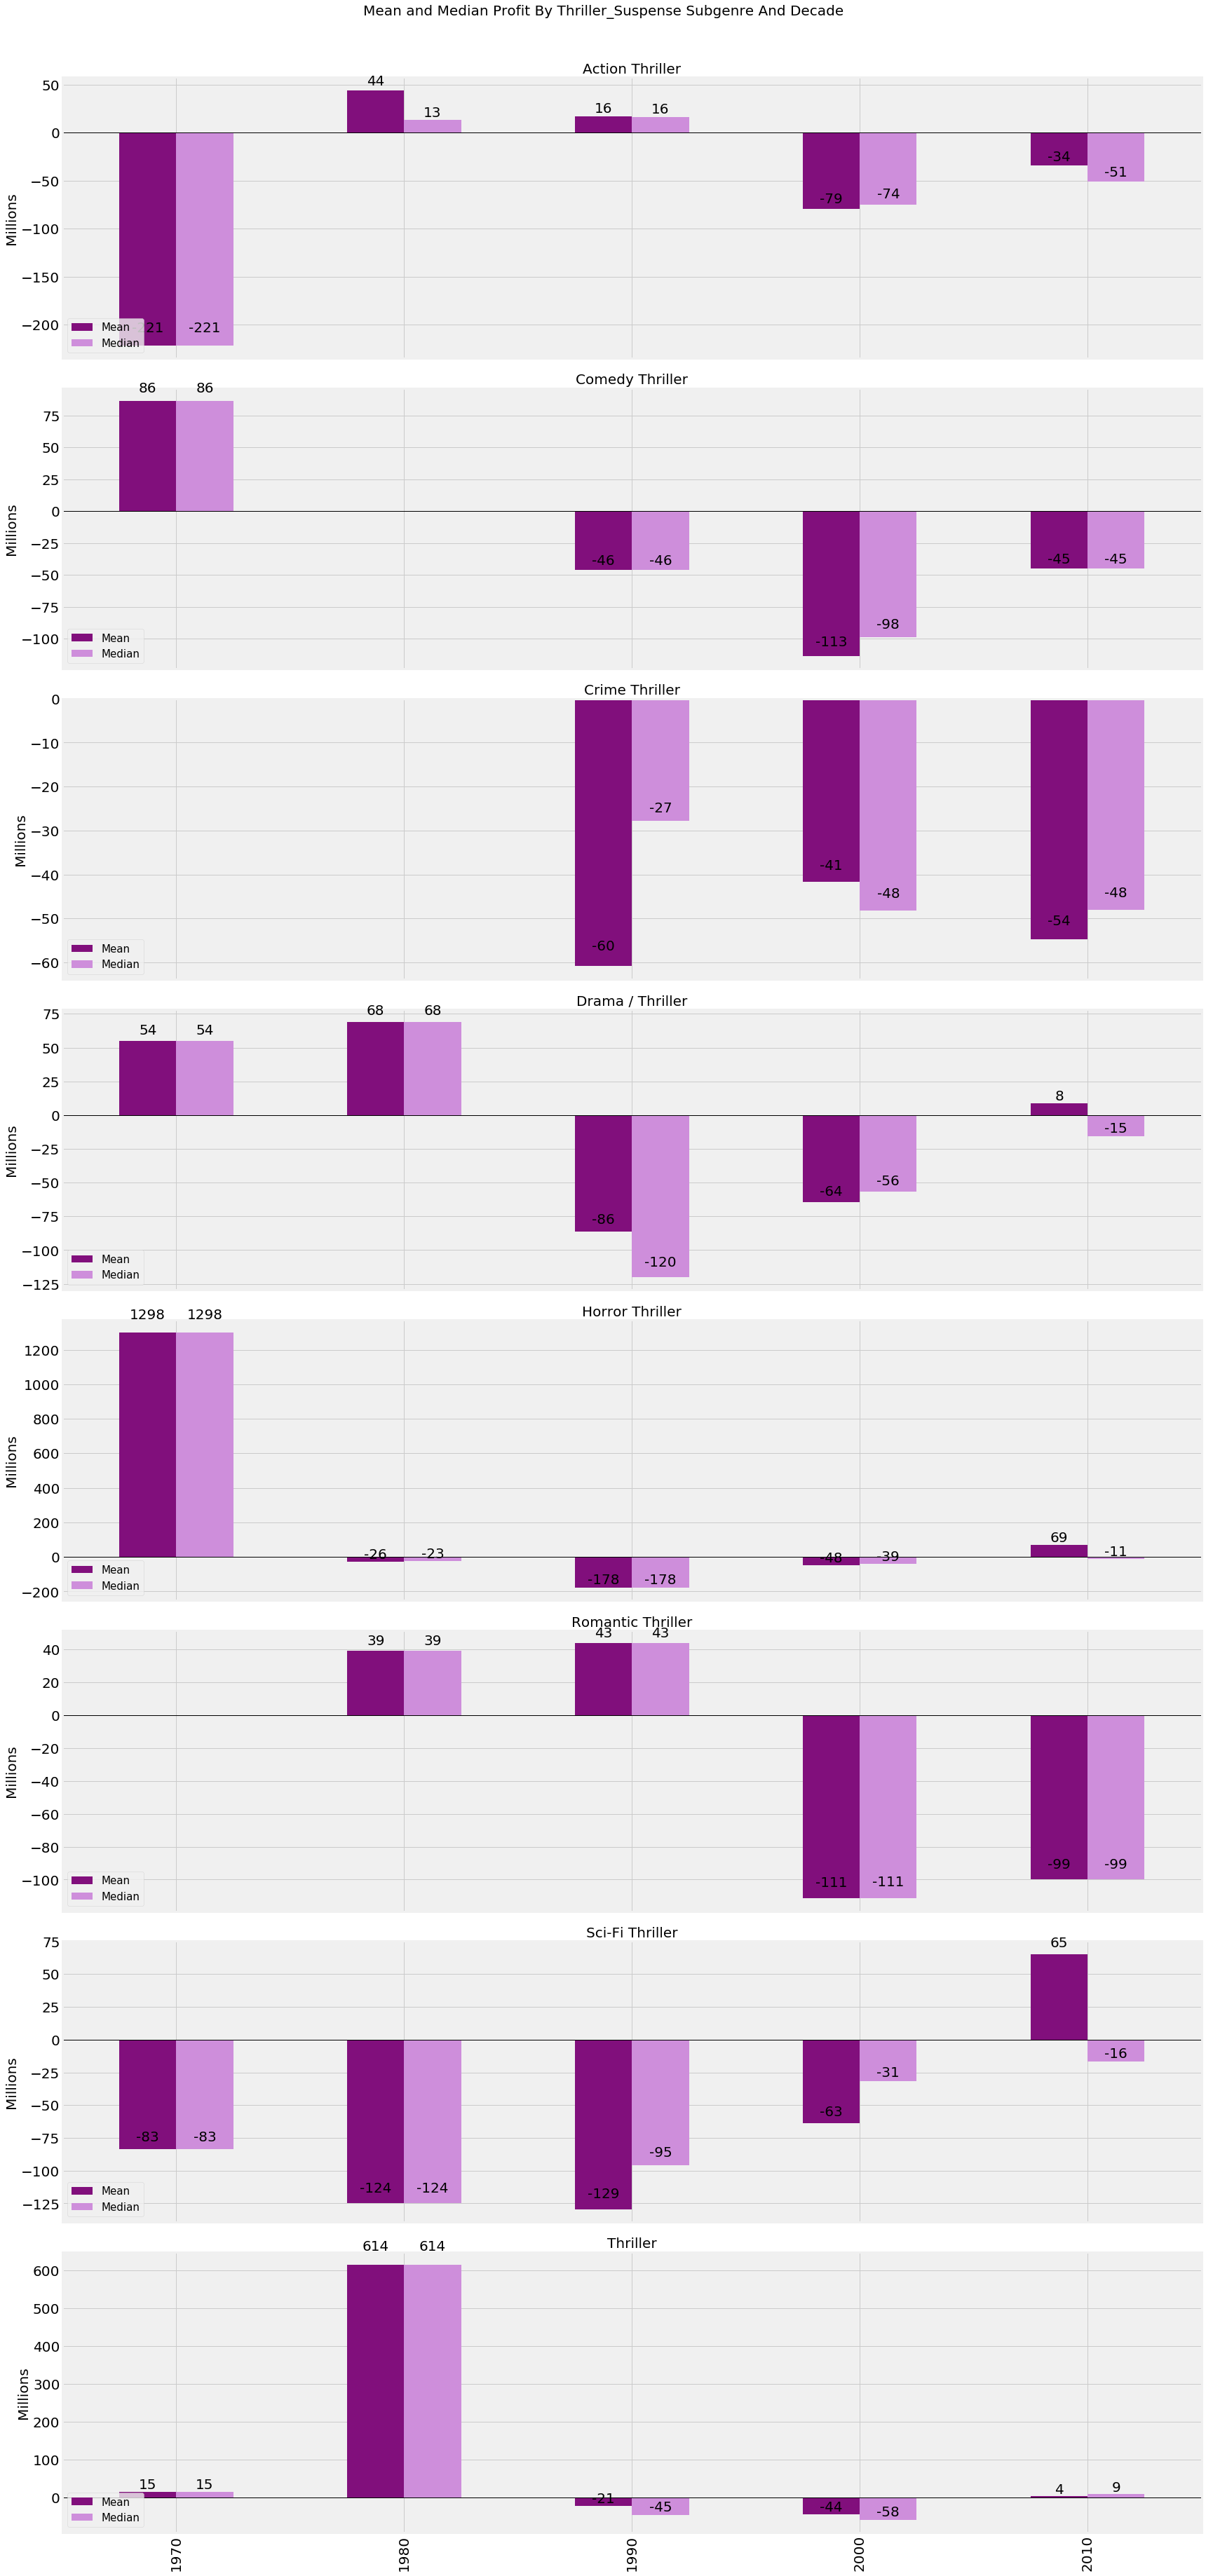

In [71]:
subgenre_profitability_by_decade('thriller_suspense', [genres_dict['thriller_suspense']['color1'], genres_dict['thriller_suspense']['color2']])

### Quick Takeaways

The only subgenre in Thriller/Suspense that has a positive median profitability this decade is Thriller.

### Summary

No subgenre stands out as a better play than any other. There's simply too much variance over time. There's also the problem of some subgenres appearing infrequently. For example, some decades are missing certain subgenres entirely.

As an example, our mean and median profitability in 'Family Adventure' movies is almost two billion dollars in the 1980s. But that is solely due to our only entry in that category being E.T., one of the most successful movies of all time. We should not conclude that our studio should start pumping out Family Adventure movies because of this information.

The movie business goes through phases like any other industry. Certain genres are hot for a minute, but then cool down for awhile. For this reason, scrutinizing subgenres over the past fifty years looking for solid trends might not yield much. 

If we restrict our focus to just the last decade, we might find some insights into the current state of genres and subgenres though.

# Current Decade

## Breakeven

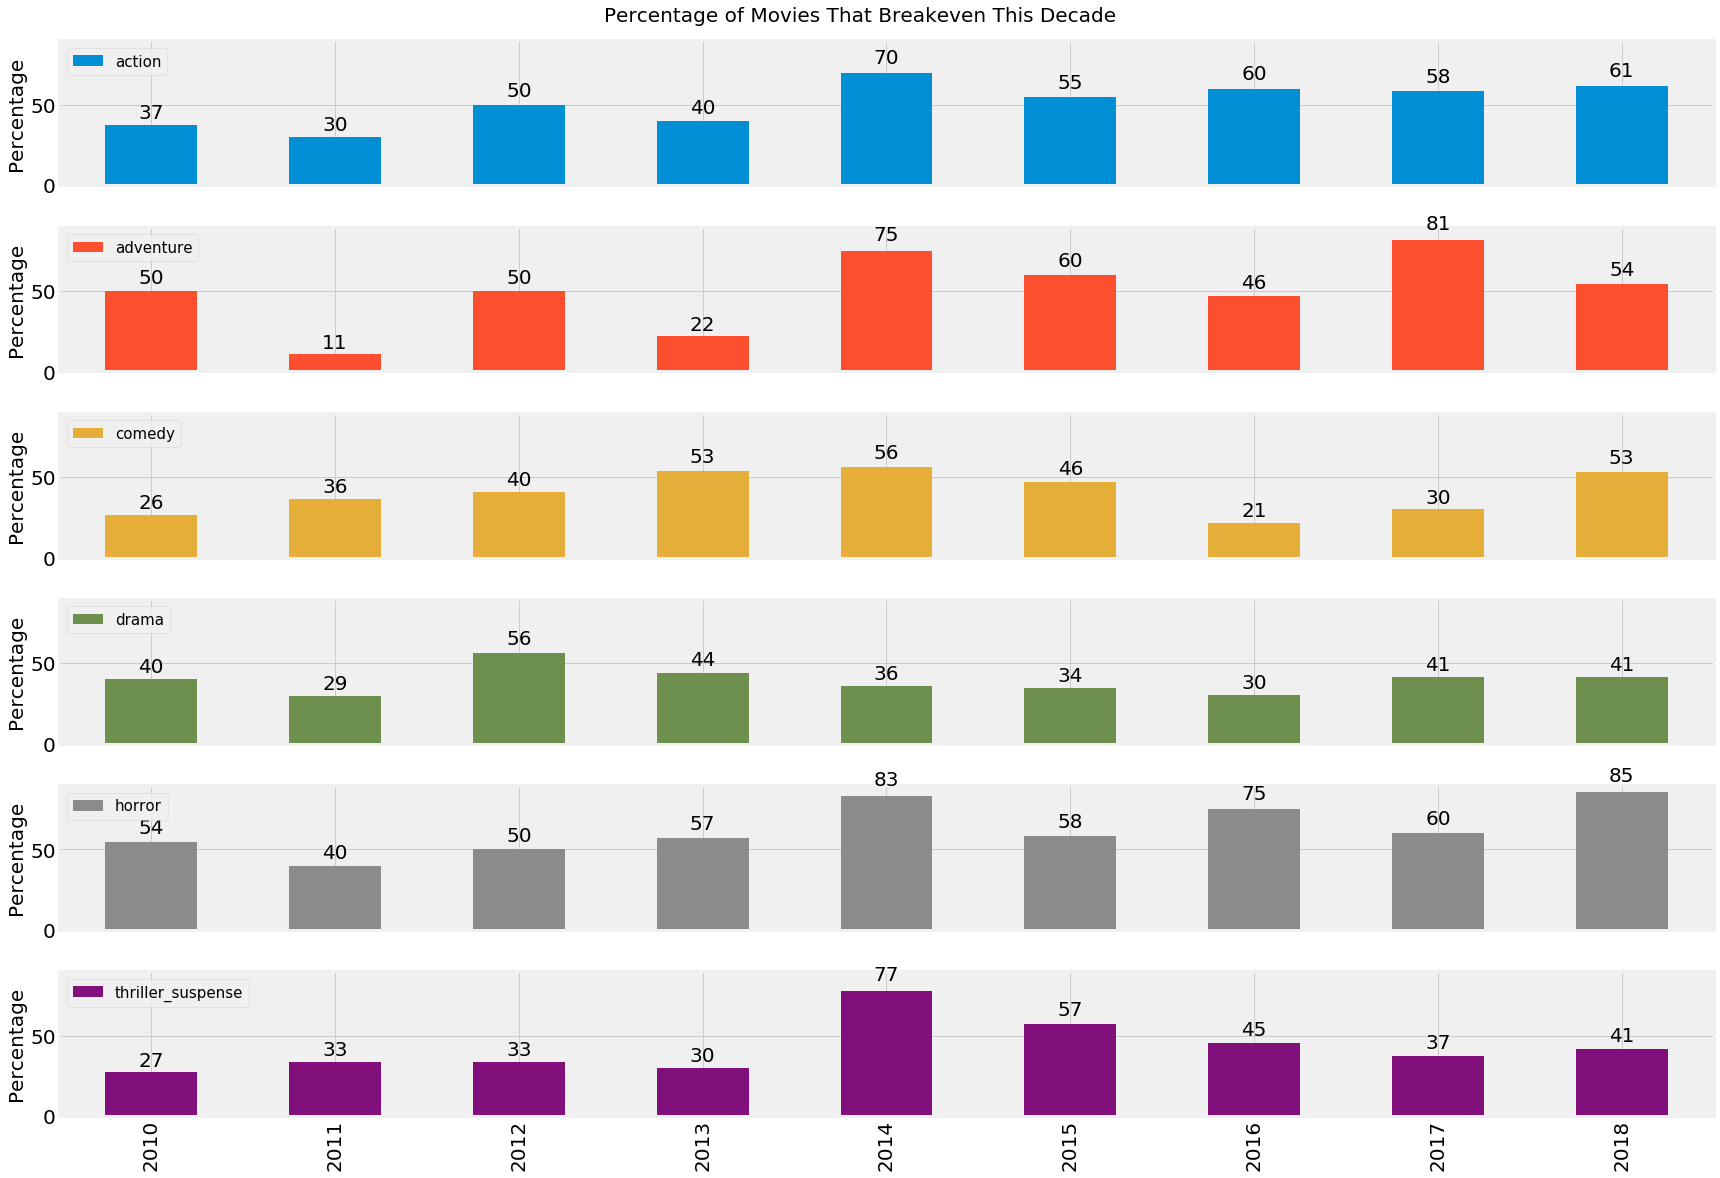

In [371]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Percentage of Movies That Breakeven This Decade', figsize=(24,16), 
                                      colors=colors, groupby_column='release_year', stat_column='worldwide_breakeven', 
                                      aggregation_function='mean', starting_year=2010, apply_needed=True, apply_function=lambda x: x * 100, 
                                      xtick_values=range(2010, 2019, 1), y_label='Percentage', axhline_needed=False, axhline_value='')

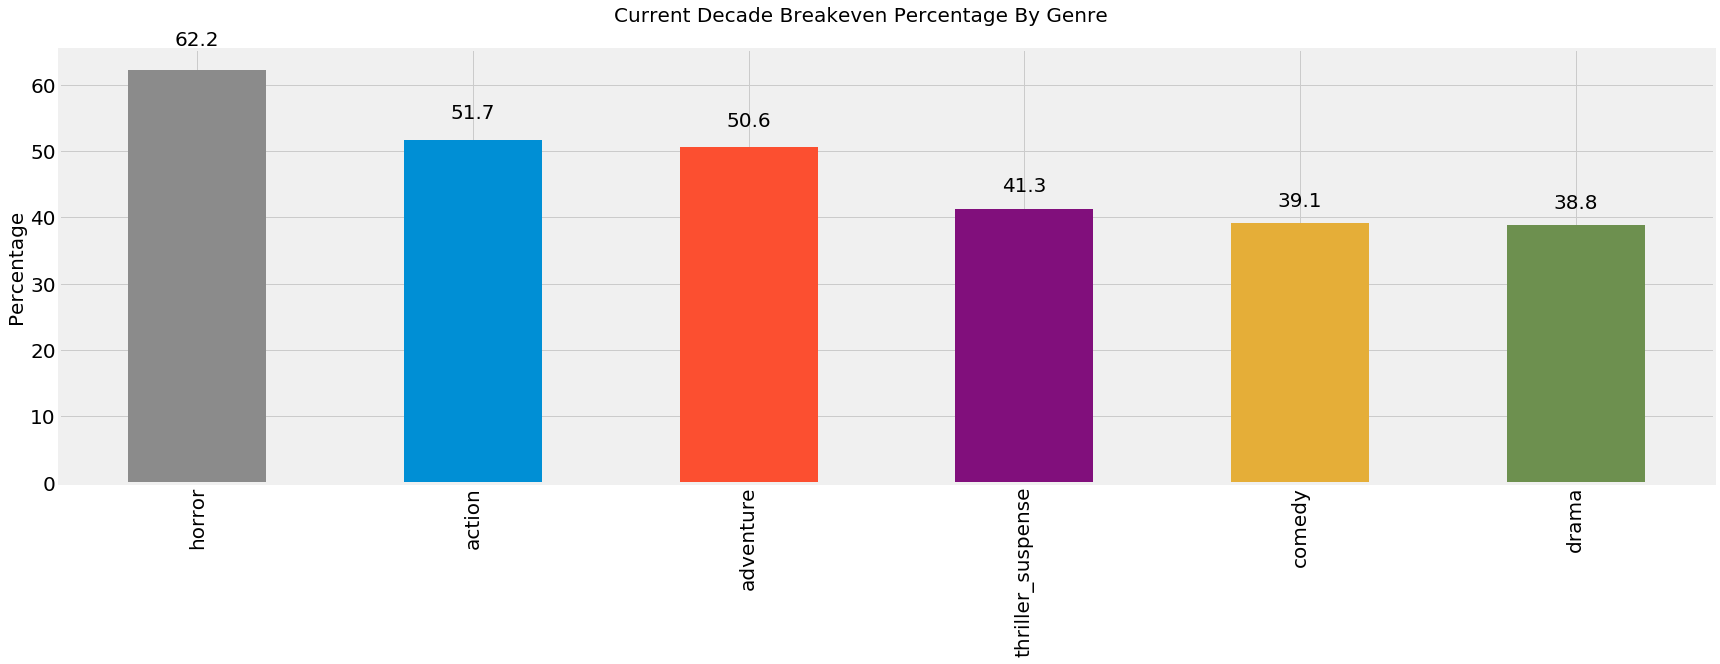

In [290]:
plot_summary_dataframe(summary=summary, sort_column='current_decade_breakeven_percentage', 
                       plot_columns='current_decade_breakeven_percentage', title='Current Decade Breakeven Percentage By Genre', 
                       colors_needed=1, legend_needed=False, legend_text=[], y_label='Percentage', num_decimals=1)

## Quick Thoughts

**Year by year takeaways**
  - There is a great deal of variety in box office results on a year by year basis
  - For the past decade, the strongest performing genre from a breakeven perspective is Horror
  - Action and Adventure are basically a coinflip to breakeven this decade  

## Profitability

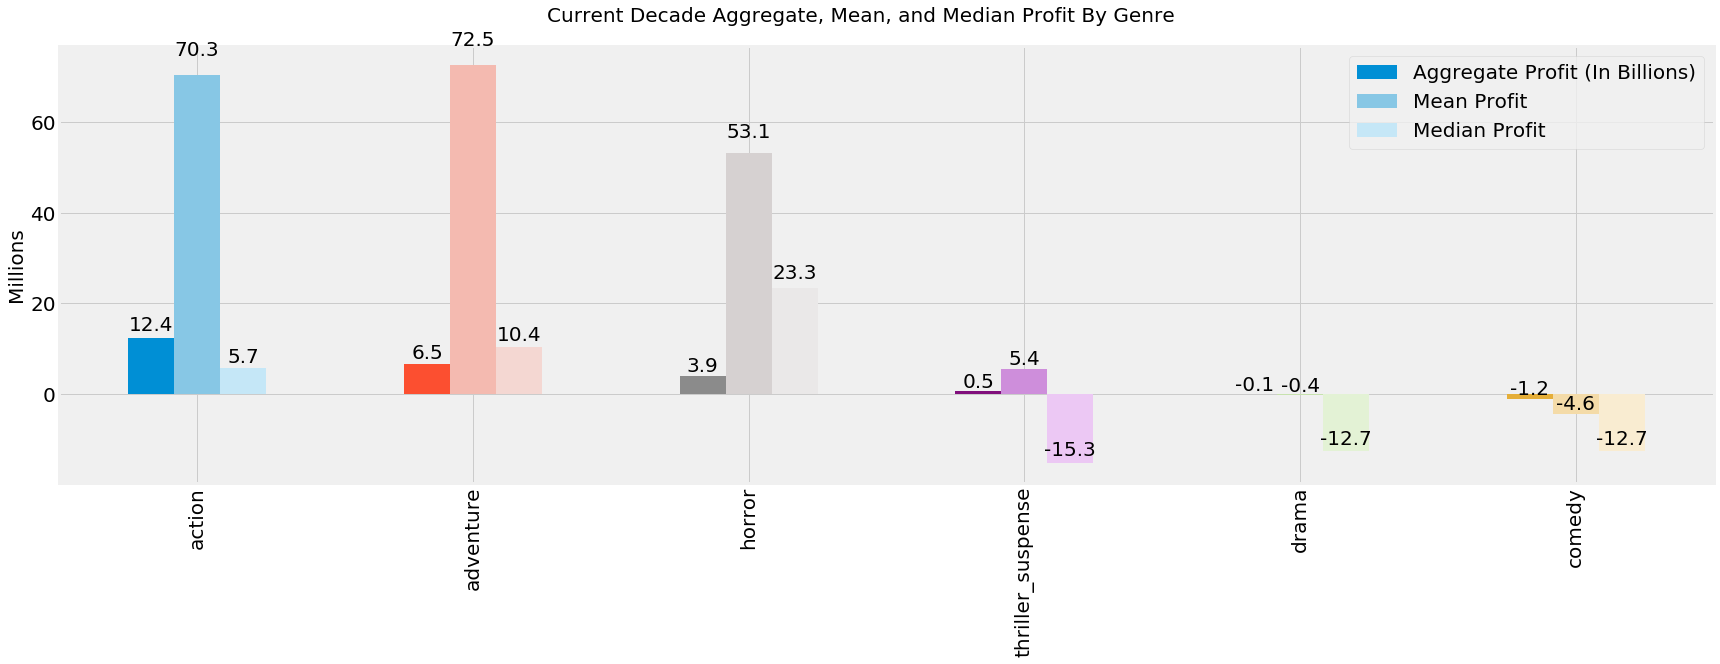

In [291]:
plot_summary_dataframe(summary=summary, sort_column='current_decade_profit', 
                       plot_columns=['current_decade_profit', 'current_decade_mean_profit', 'current_decade_median_profit'], 
                       title='Current Decade Aggregate, Mean, and Median Profit By Genre', colors_needed=3, 
                       legend_needed=True, legend_text=['Aggregate Profit (In Billions)', 'Mean Profit', 'Median Profit'], 
                       y_label='Millions', num_decimals=1)

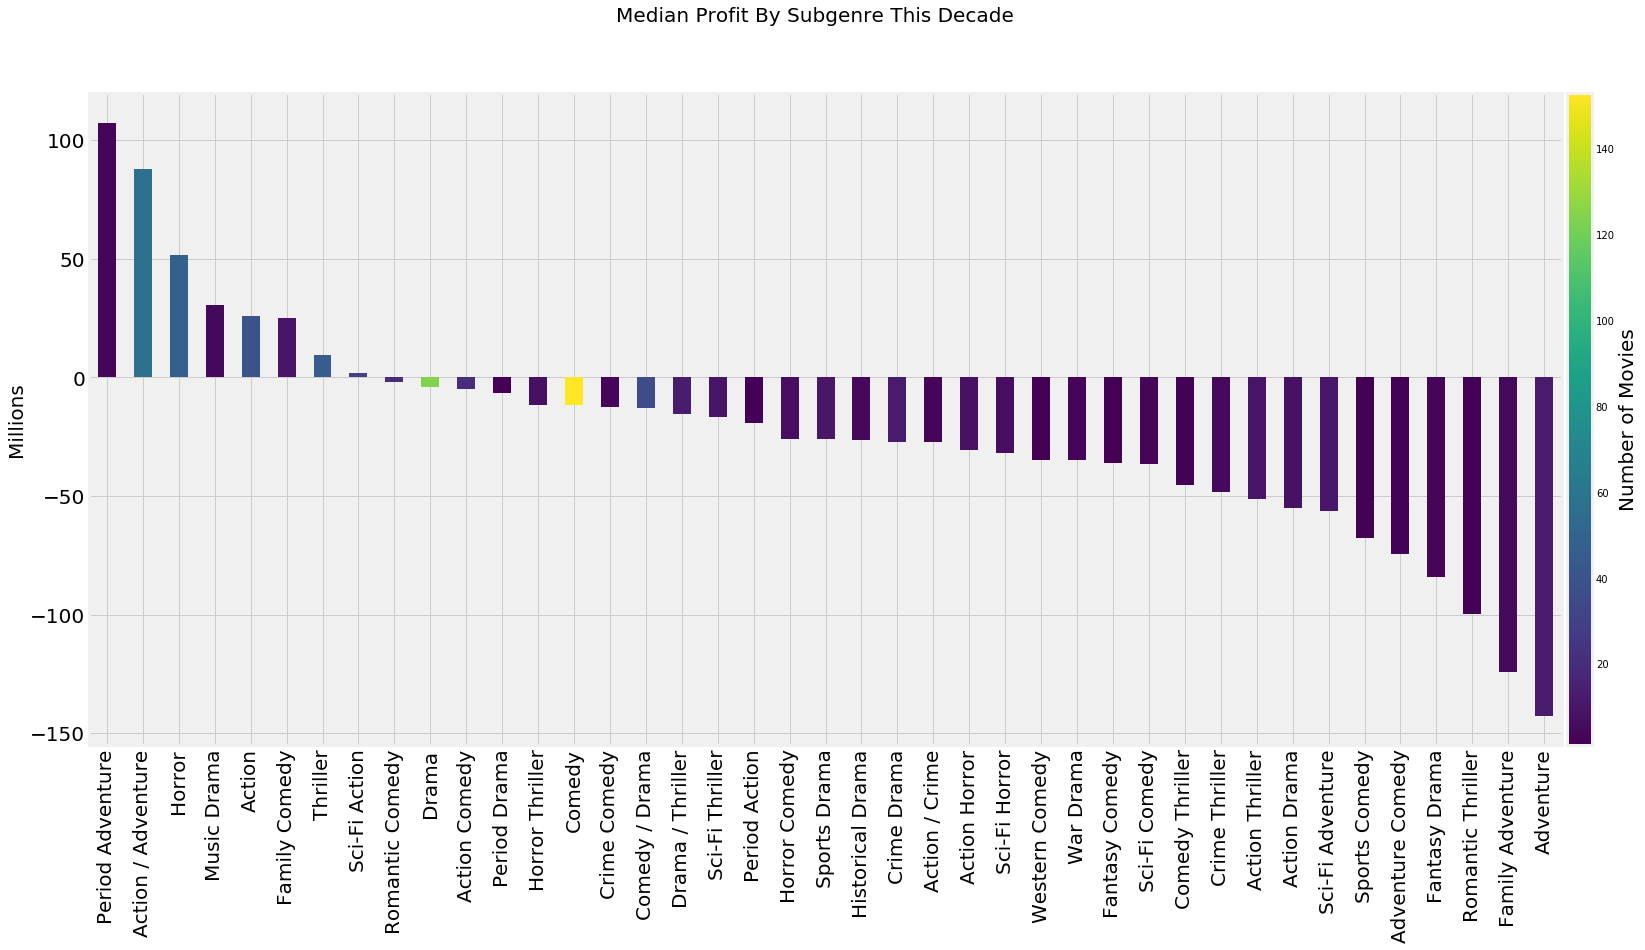

In [75]:
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
# https://matplotlib.org/users/gridspec.html#gridspec-and-subplotspec

# Import colormap functionality from matplotlib
import matplotlib.cm as cm

# To scale our counts array from [0,1] create custom colormap
from sklearn.preprocessing import minmax_scale

figure = plt.figure(figsize=(24,12))
figure.suptitle('Median Profit By Subgenre This Decade', fontsize=20)

gs = matplotlib.gridspec.GridSpec(50, 50)
ax1 = plt.subplot(gs[:, :-1])
ax2 = plt.subplot(gs[:, -1:])

grp = data[data['release_year'] >= 2010].groupby('genres_mojo')['profit'].agg(['median', 'count']).sort_values(by='median', ascending=False)

# Use 'viridis' colormap
viridis = cm.get_cmap('viridis')

# Normalize our counts series
scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

# List of colors using rescaled count values
new_cmap = [viridis(item) for item in scaled_counts]

(grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap)

norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
ax2.set_ylabel('Number of Movies', fontsize=20)
ax1.set_xlabel('')
ax1.set_ylabel('Millions', fontsize=20)
ax1.tick_params(labelsize=20)

## Quick Takeaways

**Aggregate Profit**
  - This is just adding up the profits (or losses) of each movie in each category in this decade
  - The most profitable genre in aggregate is Action with \\$12.4 billion in aggregate profit
  - Comedy and Drama both lost money in aggregate this decade
  
**Mean Profit**
  - We see the power of the right tails here. Action and Adventure are neck and neck with mean profits for this decade in the \\$70 million range
  - Horror is third with \\$53 million
  
**Median Profit**
  - Horror is the slam dunk winner with a median profit of \\$23.3 million, followed by Adventure at \\$10.4 million and Action at \\$5.7 million
  - Comedy, Drama, and Thriller/Suspense are all median net losers this decade
  
**Subgenres**
  - The vast majority of subgenres are not profitable in aggregate this decade. If a main genre is profitable overall, it is due to a few subgenres performing really well, making up for the losses in the other subgenres.
  - Another takeaway is the relatively low number of movies produced in most of these subgenres this decade. That could be indicative of a contraction in output or simply having a time window too brief to allow enough data points. 
  
**Profitable Subgenres This Decade**
  - In descending order of median profitability:
    - Period Adventure: \\$107 million
    - Action/Adventure: \\$88 million
    - Horror: \\$52 million
    - Music Drama: \\$30 million
    - Action: \\$26 million
    - Family Comedy: \\$25 million
    - Thriller: \\$9 million
    - Sci-Fi Action: \\$2 million

## Breakdown By Budget

It might help to further subdivide our genres by their budgets to look for patterns there.

In [76]:
bins = [0, 1000000, 5000000, 10000000, 25000000, 50000000, 100000000, 200000000, 300000000, 400000000]
group_names = ['0 - 1m', '1 - 5m', '5 - 10m', '10 - 25m', '25 - 50m', '50 - 100m', '100 - 200m', '200 - 300m', '300 - 400m']
subgenre_colors = ['#8d6a9f', '#006494', '#fcfc62', '#2d4739', '#bb342f', '#6eeb83', '#e56399', '#ffe8d4', '#57886c', '#ff7700', '#16f4d0', '#bfae48', '#90c290', '#330f0a']

data['budget_bins'] = pd.cut(data['budget_adj'], bins, labels=group_names)

In [77]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to add blue if a majority of the films break even 
def background_color_blue_if_greater_than_fifty_percent(val):    
    if val > 0.5:
        return 'background-color: {}'.format('#87C7E5')
    
    return ''

In [78]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to highlight the max value in a series
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''), index=data.index, columns=data.columns)

## Action

In [176]:
# Create custom function to display profit and count information by genre and budget size for the current decade (2010s)
def current_decade_budget_sizes(data, genre):
    styler_object = (data[
        (data['release_year'] >= 2010) & 
        (data['genres_mojo'].str.contains(genre))
    ][['budget_bins', 'profit', 'worldwide_breakeven']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'profit'], ascending=False)
    .groupby('budget_bins')
    .agg(['mean', 'median', 'count', 'sum'])
    .drop([('profit', 'count'), ('profit', 'mean'), ('profit', 'sum'), ('worldwide_breakeven', 'median')], axis=1)
    .dropna()
    .style
    .applymap(background_color_blue_if_greater_than_fifty_percent, subset=[('worldwide_breakeven', 'mean')])
    .apply(highlight_max, subset=[('worldwide_breakeven', 'count')])
    .background_gradient('winter', subset=[('profit', 'median')]))
    
    return styler_object

In [177]:
action_budget_info = current_decade_budget_size(data=data, genre='Action')
action_budget_info

## Quick Takeaways

**Most produced budget**
  - The 100-200m range has 73 movies produced and is median profitable this decade
  
**Most profitable budget**
  - The 200-300m range has a median profit of 143m, and 17/24 movies profitable
  - The 100-200m range has a median profit of 11m and has 39/73 movies profitable
  
**Least profitable budget**
  - The 300-400m range has a median loss of 249m per movie. However, this category is comprised of a single movie, Justice League.
  
**Conclusions**
  - 200-300m make more money on average with 70% of movies profitable
  - 100-200m make less money on average with only 53% of movies profitable
  - We should go for 200-300m Action movies

## Adventure

In [170]:
adventure_budget_info = current_decade_budget_size(data=data, genre='Adventure')
adventure_budget_info

## Quick Takeaways

**Most produced budget**
  - The 100-200m range with 42 movies
  
**Most profitable budget (descending order)**
  - The 200-300m range with median profit of 99m and 14/24 movies profitable
  - The 50-100m range with a median profit of 87m and 7/13 movies profitable  
  - The 100-200m range with a median profit of 11m and 22/42 movies profitable
  
**Least profitable budget**
  - The 300-400m range again because of Justice League, which is labeled as Action/Adventure
  
**Conclusions**
  - Only about half of Adventure movies in the three most profitable budgets make money. This demonstrates how this genre is defined by its big winners and big losers.
  - The 200-300m range has the highest median profit and the highest breakeven percentage at 58%
  - We should go with the 200-300m range

## Quick Look At Action/Adventure

In [171]:
action_adventure_budget_info = current_decade_budget_size(data=data, genre='Action / Adventure')
action_adventure_budget_info

## Quick Takeaways

Since Action/Adventure is one of the only profitable subgenres this decade, it warrants a closer look at this specific subgenre.

**Most produced budget**
  - The 100-200m range with 29 movies
  - Second place is 200-300m with 13 movies
  
**Most profitable budget (descending order)**
  - The 200-300m range with median profit of 129m and 10/13 movies profitable
  - The 100-200m range with a median profit of 125m and 19/29 movies profitable
  - In third place is 50-100m with a median profit of 87m and 5/9 movies profitable
  
**Least profitable budget**
  - The 300-400m range again because of Justice League
  
**Conclusions**
  - In terms of median profit, both 100-200m and 200-300m movies are about the same. At least for the last decade though, the 200-300m movies have a much higher chance of making money: 77% versus 66%.
  - Both seem like good bets and have higher median profits than any other subgenre within Action or Adventure

## Comedy

In [172]:
comedy_budget_info = current_decade_budget_size(data=data, genre='Comedy')
comedy_budget_info

## Quick Takeaways

**Most produced budget**
  - The 25-50m range with 92 movies, followed by the 10-25m range with 73 movies. Neither are median profitable this decade.
  
**Most profitable budget**
  - The 0-1m range with 2/3 profitable movies and a median profit of 1 million. Every other budget size is a net loser.
  
**Least profitable budget**
  - The 100-200m range with 5/14 profitable movies and a median loss of 109 million
  
**Conclusions**
  - Comedies in general haven't performed well this decade, but definitely stay away from big budgeted ones 

## Drama

In [173]:
drama_budget_info = current_decade_budget_size(data=data, genre='Drama')
drama_budget_info

## Quick Takeaways

**Most produced budget**
  - The 10-25m range with 76 movies, followed by the 25-50m range with 56 movies. Neither are median profitable this decade.
  
**Most profitable budget**
  - The 0-1m range had 3/3 movies profitable with a median profit of 1 million
  - The 1-5m range had 10/19 movies profitable with a median profit of 1 million
  - Other than those two, all budgets were median losers.
  
**Least profitable budget**
  - The 100-200m range had 7/9 movies lose money with a median loss overall of 109 million
  - The 50-100m range had 22/31 movies lose money with a median loss overall of 63 million
  
**Conclusions**
  - There doesn't seem to be much upside in making Drama movies this decade

## Horror

In [174]:
horror_budget_info = current_decade_budget_size(data=data, genre='Horror')
horror_budget_info

## Quick Takeaways

**Most produced budget**
  - The 5-10m, 10-25m, and 25-50m are all produced in roughly equal numbers
  
**Most profitable budgets**
  - 1-5m range had 5/5 movies profitable with a median profit of 108 million
  - 5-10m range had 15/17 movies profitable with a median profit of 93 million
  - 10-25m range had 16/19 movies profitable with a median profit of 51 million
  
**Least profitable budget**
  - Any movie budgeted more than 25 million is a median loser.
  - The worst budget seems to be 100-200m as 3/3 movies were unprofitable with a median loss of 227 million
  
**Conclusions**
  - Horror movies in the 1-25m range have been a solid investment this decade 

## Thriller/Suspense

In [175]:
thriller_suspense_budget_info = current_decade_budget_size(data=data, genre='Thriller|Suspense')
thriller_suspense_budget_info

## Quick Takeaways

**Most produced budget**
  - The 25-50m range with 29 movies, followed by the 50-100m range with 24 movies. Both are median losers.
  
**Most profitable budget**
  - The 200-300m range only has one movie in it, The Dark Knight Rises. That movie was incredibly successful and thus has a tremendously high median profit for the category.
  - The 1-5m range has 3/4 movies profitable with a median profit of 64 million
  - The 5-10m range has 5/8 movies profitable with a median profit of 18 million
  - The 10-25m range has 10/19 movies profitable with a median profit of 9 million
  
**Least profitable budget**
  - The 50-100m range has only 6/24 movies profitable with a median loss of 47 million
  
**Conclusions**
  - Stick to Thriller/Suspense movies budgeted between 1-25m 

## Profit Boxplot For The Current Decade

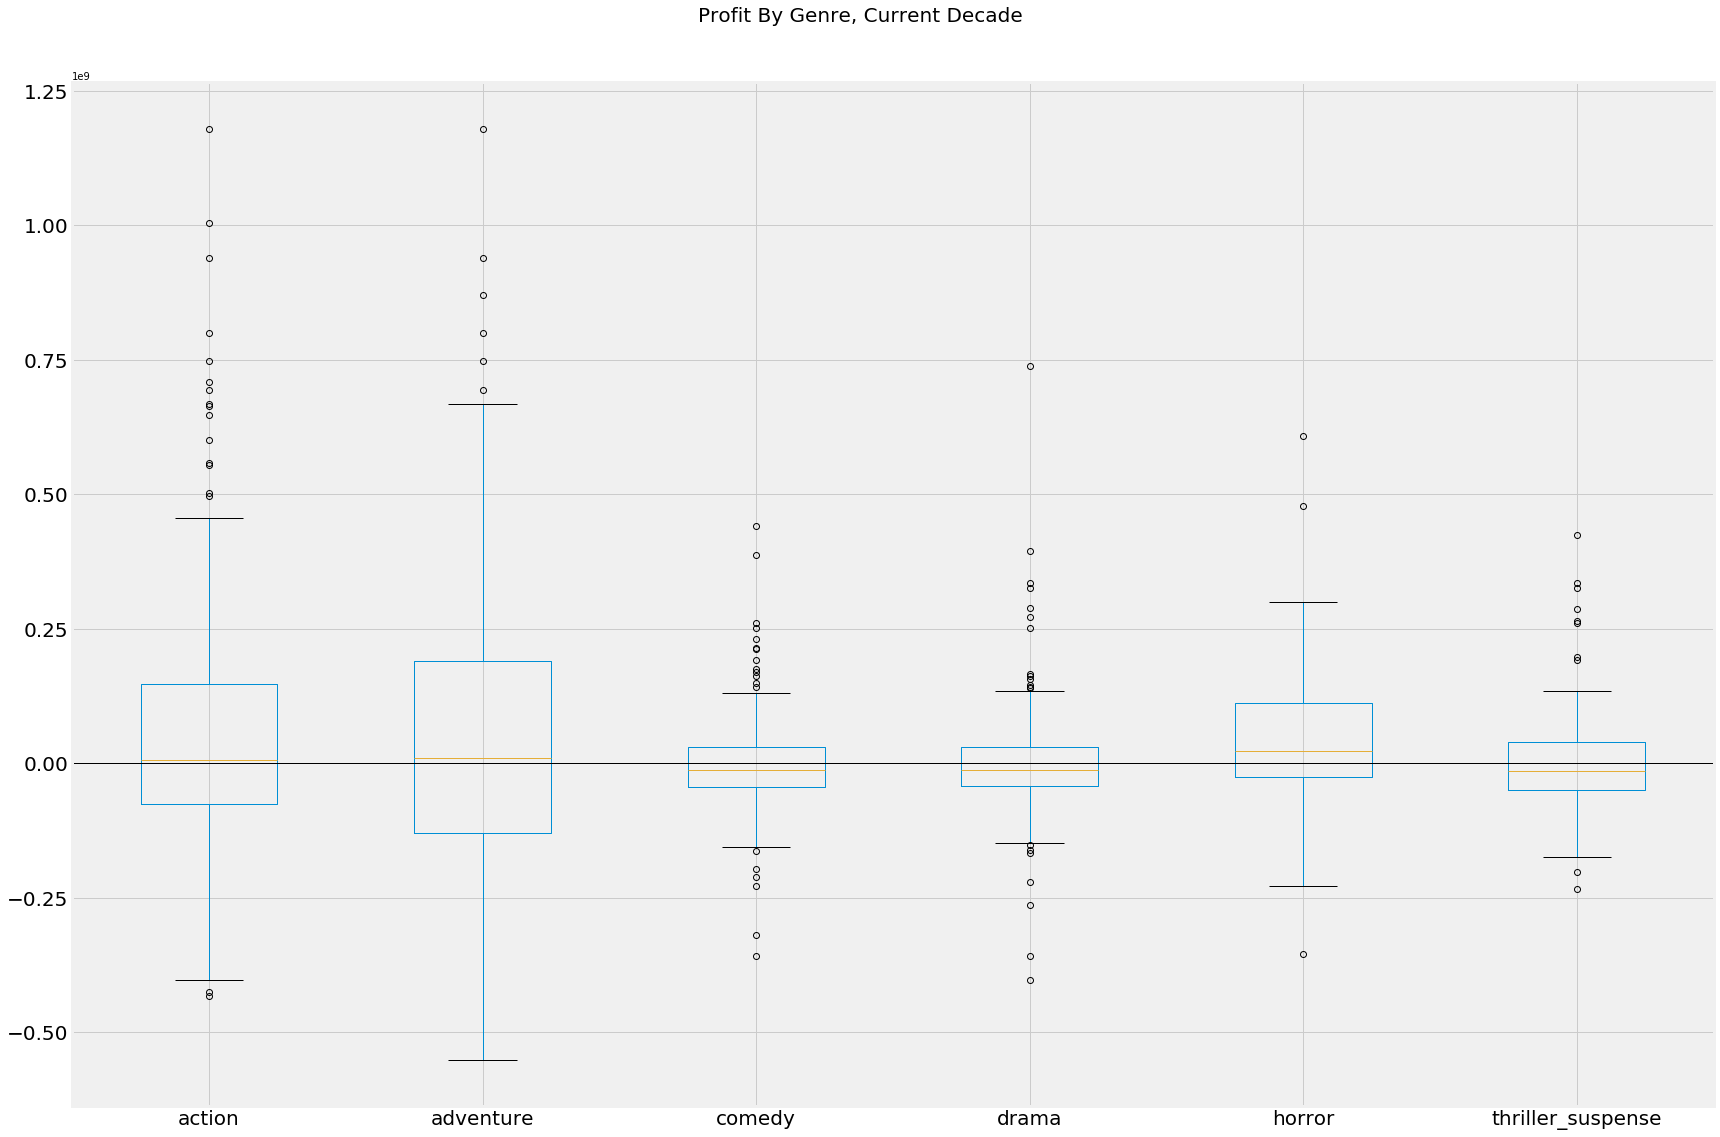

In [221]:
plot_boxplot(data=data, genres=genres, title='Profit By Genre, Current Decade', columns=profit_columns, starting_year=2010)

## Summary

The boxplot helps shed some light on each genre's strengths and weaknesses.

**Movies are an outlier-driven business**
  - In this decade, every genre has outliers on both sides of profit and loss
  - Action and Adventure have the highest profit outliers
  - Comedy and Drama have the most losing outliers
  
**Safe versus Risky**
  - Action and Adventure movies can make the most money but also lose the most
  - The "safest" genres of Comedy, Drama, and Thriller/Suspense (meaning the tightest whiskers) still have plenty of outliers on the loser side. 
  - Horror is in the middle of those two camps: more reward than Comedy/Drama/Thriller/Suspense and less loss than Action/Adventure
  
**Breaking even**
  - Horror has the most chance to break even, followed by Action and Adventure.
  
**Median Profit**
  - In the scale on which movies make money, the median profits for all genres this decade are incredibly small.
  - Horror has the highest at \\$23 million. Adventure is at 10, and Action is at 5
  - Comedy, Drama, and Thriller/Suspense are all double digit median losers this decade
  
**Recommendation**
  - Based on the past decade of movie results, I would suggest pursuing Horror movies.
  
**Final step**
  - Let's examine each genre's performance by its release week and see if we learn anything interesting. 

# Analyze By Release Week

## Number of Movies

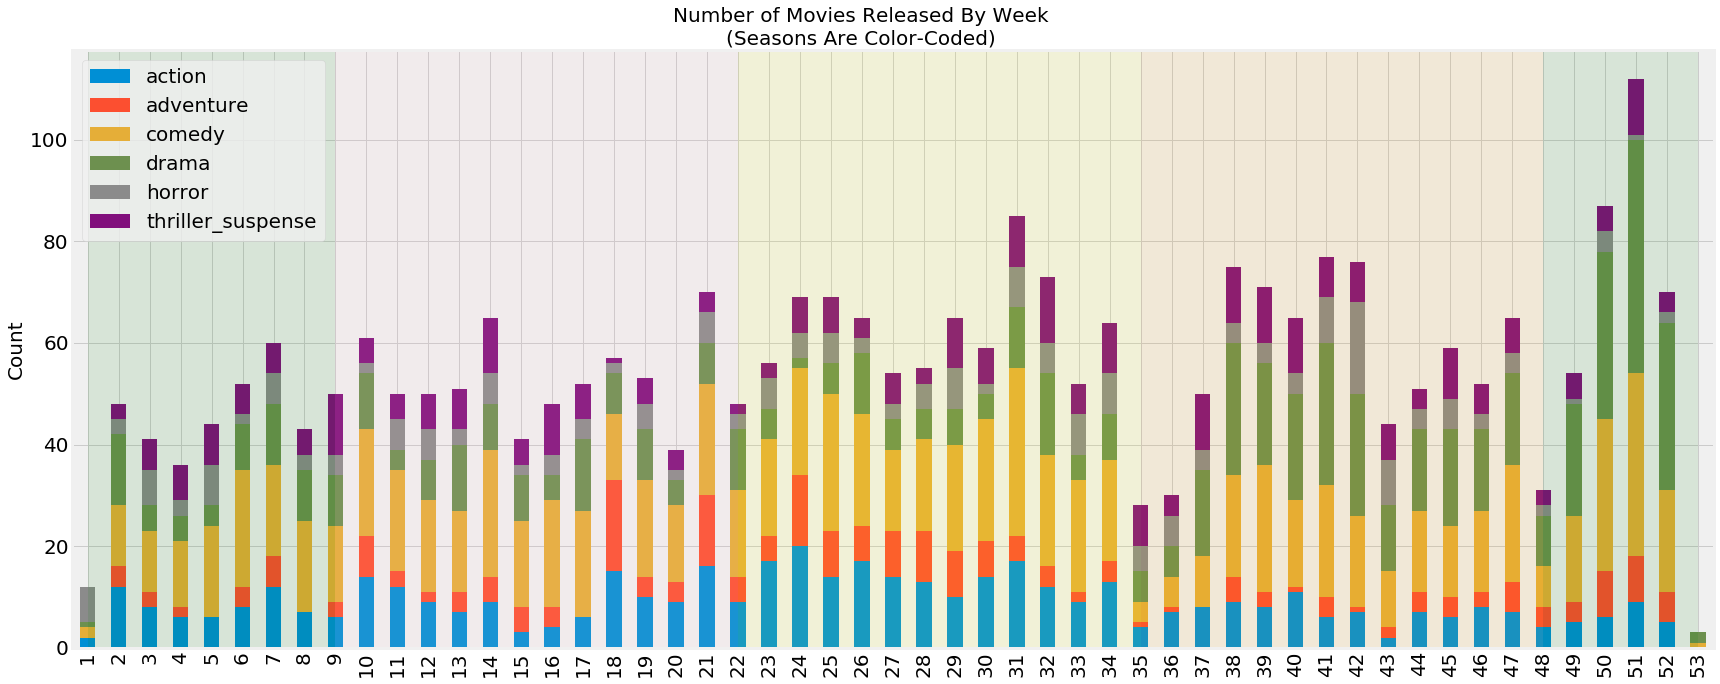

In [87]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Released By Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

grp = data.groupby('release_week')[genres].sum()
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Count', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)

# Subtract one from axvspan ranges to account for it being a bar chart and not a line chart (e.g. Spring is weeks 9-22)
axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
axis.axvspan(47, 52, alpha=0.1, facecolor='green')
axis.axvspan(0, 8, alpha=0.1, facecolor='green')

plt.tight_layout()

## Quick Takeaways

Other than a few weeks, there have been a healthy amount of movies being released on every possible week.

Let's subdivide by genre to get a better look.

## All-Time

In [187]:
def num_movies_released_by_release_week_by_genre(data, title, starting_year=1970, genres=genres, colors=colors):
    figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
    figure.suptitle(title, fontsize=20, y=1.02)

    for genre, axis, color in zip(genres, axes.flat, colors):
        grp = data[(data['release_year'] >= starting_year) & (data[genre])].groupby('release_week')['title'].count()

        # If the series is missing a decade, add it as an index
        # Then set the value to 0
        for week in range(1, 54):
            if week not in grp.index:
                grp.loc[week] = 0

        grp.sort_index(inplace=True, ascending=True)

        grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
        axis.set_ylabel('Count', fontsize=12)
        axis.set_xlabel('')
        axis.legend([genre], loc=2, fontsize=15)

        # Subtract one from axvspan ranges to account for it being a bar chart and not a line chart
        axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
        axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
        axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
        axis.axvspan(47, 52, alpha=0.1, facecolor='green')
        axis.axvspan(0, 8, alpha=0.1, facecolor='green')

    plt.tight_layout() 

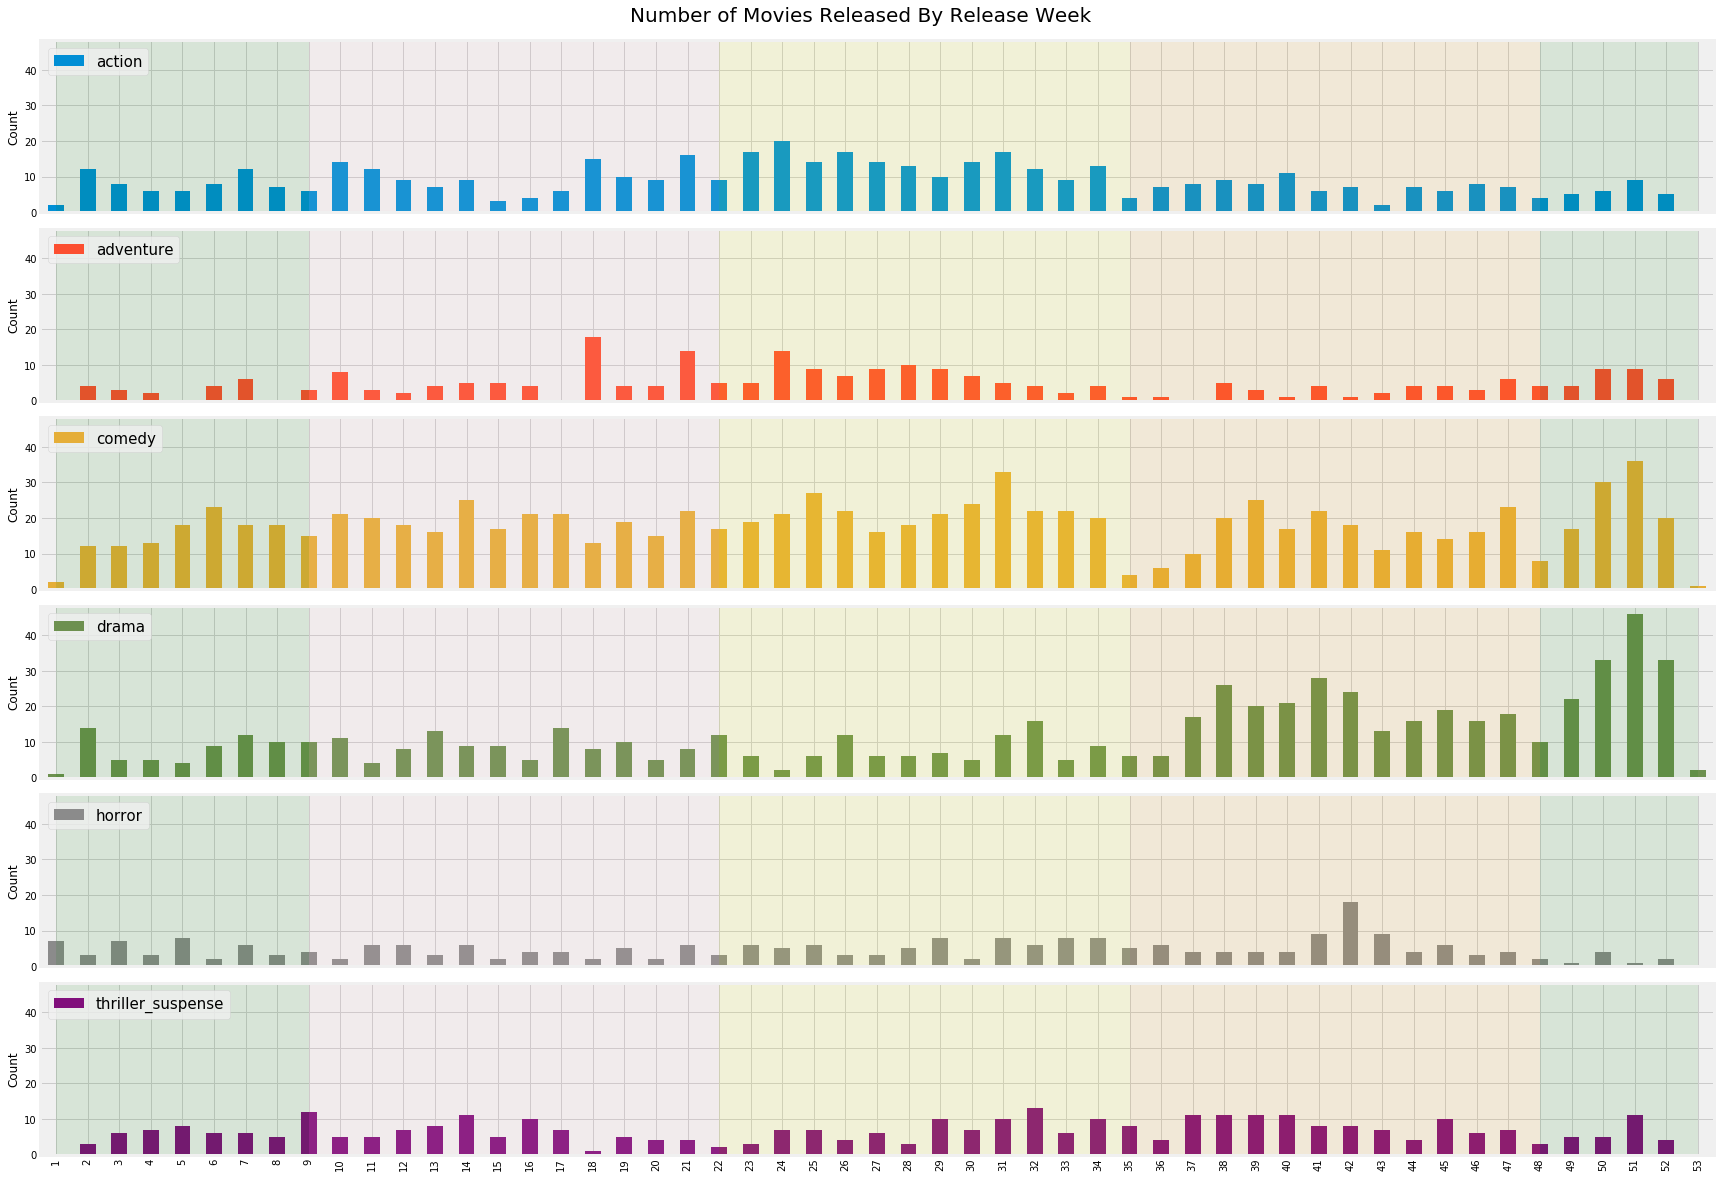

In [292]:
num_movies_released_by_release_week_by_genre(data=data, title='Number of Movies Released By Release Week', 
                                             starting_year=1970, genres=genres, colors=colors)

## Quick Takeaways

Comedy has been released in good numbers in practically every week.

Drama is released the most in Fall and Winter. 

Action and Adventure are released the most in Summer.

Horror and Thriller/Suspense don't really have clear patterns.

## This Decade

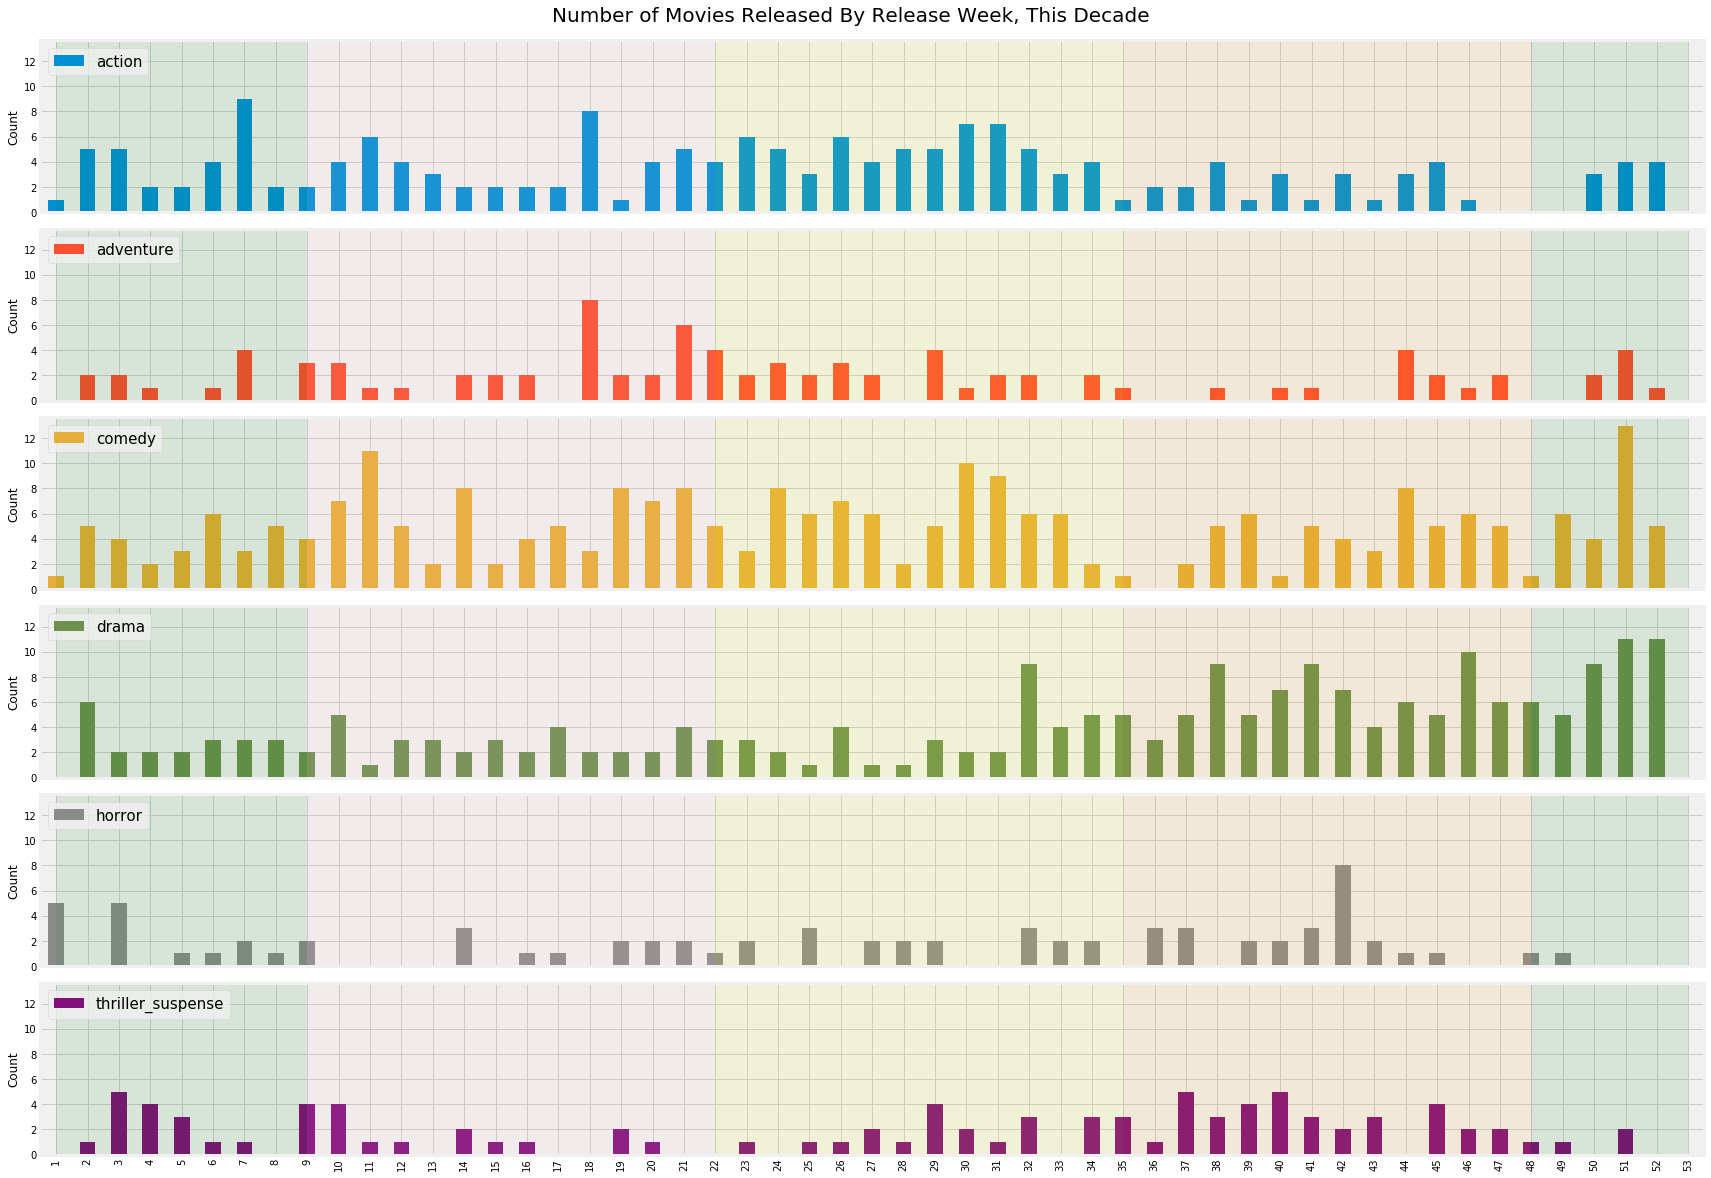

In [293]:
num_movies_released_by_release_week_by_genre(data=data, title='Number of Movies Released By Release Week, This Decade', 
                                             starting_year=2010, genres=genres, colors=colors)

## Quick Takeaways

Comedy is released consistently in more weeks than any other genre.

Drama is still weighted towards Fall and Winter weeks.

Action is concentrated on Summer releases.

Adventure, Horror, and Thriller/Suspense have less clear patterns.

## Median Gross

In [182]:
# Custom function to graph a fill_between line graph of a stat's performance by release week in two ways: all-time and the current decade 
def fill_between_by_release_week(data, title, stat, genres=genres, colors=colors, y_label='Millions'):
    figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
    figure.suptitle(title, fontsize=20, y=1.05)

    for genre, axis, color in zip(genres, axes.flat, colors):
        grp1 = data[data[genre]].groupby('release_week')[stat].median() / 1000000
        grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')[stat].median() / 1000000

        for year in range(1, 54, 1):
            if year not in grp1.index:
                grp1.loc[year] = 0

            if year not in grp2.index:
                grp2.loc[year] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp1.sort_index(ascending=True, inplace=True)
        grp2.sort_index(ascending=True, inplace=True)

        axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
        axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 

        axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
        axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')

        axis.set_title(genre, fontsize=20)

        axis.set_ylabel(y_label, fontsize=12)
        axis.set_xlabel('')
        axis.legend(loc=2, fontsize=15)
        axis.axvspan(9, 22, alpha=0.2, color='pink')
        axis.axvspan(22, 35, alpha=0.2, color='yellow')
        axis.axvspan(35, 48, alpha=0.2, color='orange')
        axis.axvspan(48, 53, alpha=0.2, color='green')
        axis.axvspan(1, 9, alpha=0.2, color='green')

    plt.tight_layout() 

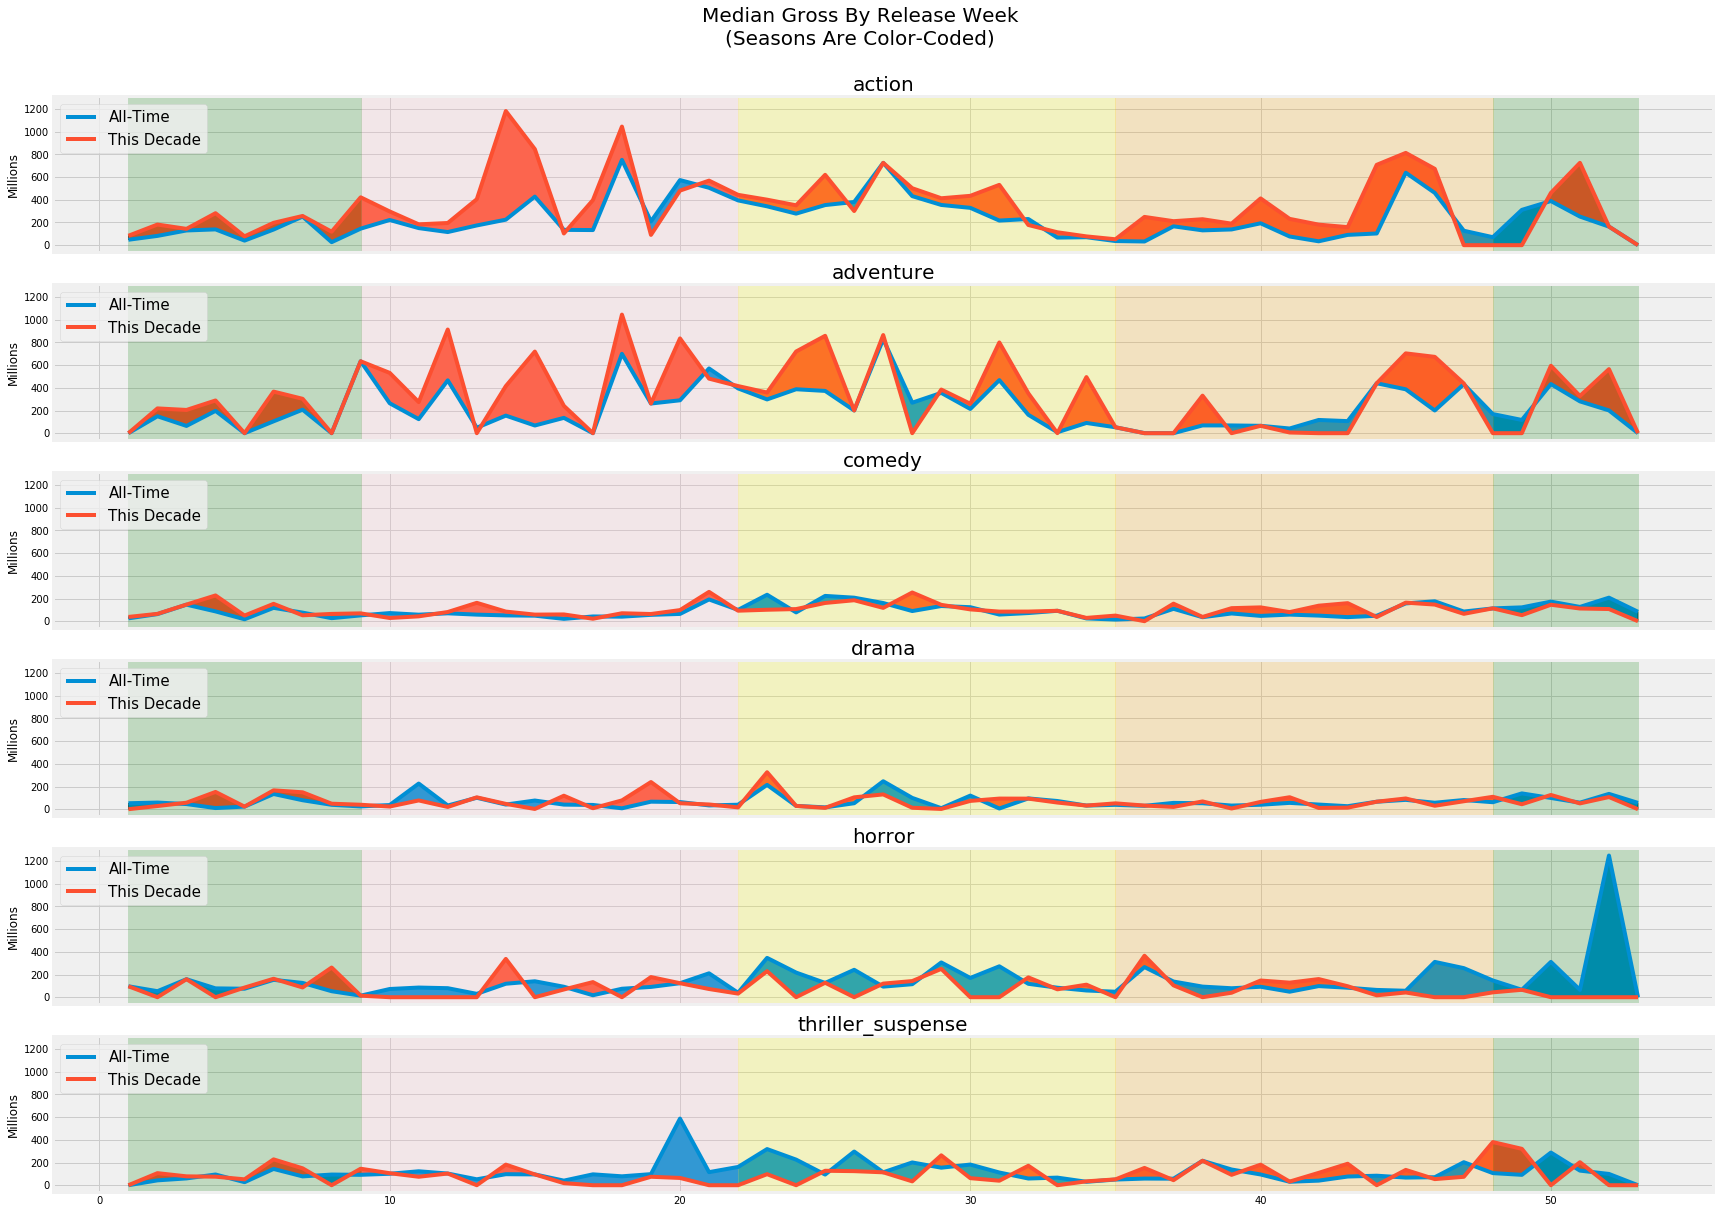

In [294]:
fill_between_by_release_week(data=data, title='Median Gross By Release Week\n(Seasons Are Color-Coded)', 
                             stat='worldwide_adj', genres=genres, colors=colors, y_label='Millions')

## Quick Takeaways

**Action**
  - Has higher median grosses on almost every release week this decade compared to its historical numbers
  - The biggest increases occur in Spring and Fall
  - Summer in general is higher this decade than it has been as well
  
**Adventure**
  - Has higher median grosses on almost every release week this decade compared to its historical numbers
  - The biggest increases occur in Spring and Summer
  
**Comedy and Drama**
  - Seem to perform about the same this decade compared to historically
  
**Horror**
  - Has worse grosses during Summer and Winter releases this decade
  
**Thriller/Suspense**
  - Seems to have lower median grosses in general this decade, most notably from the end of Spring through Summer

## Budgets

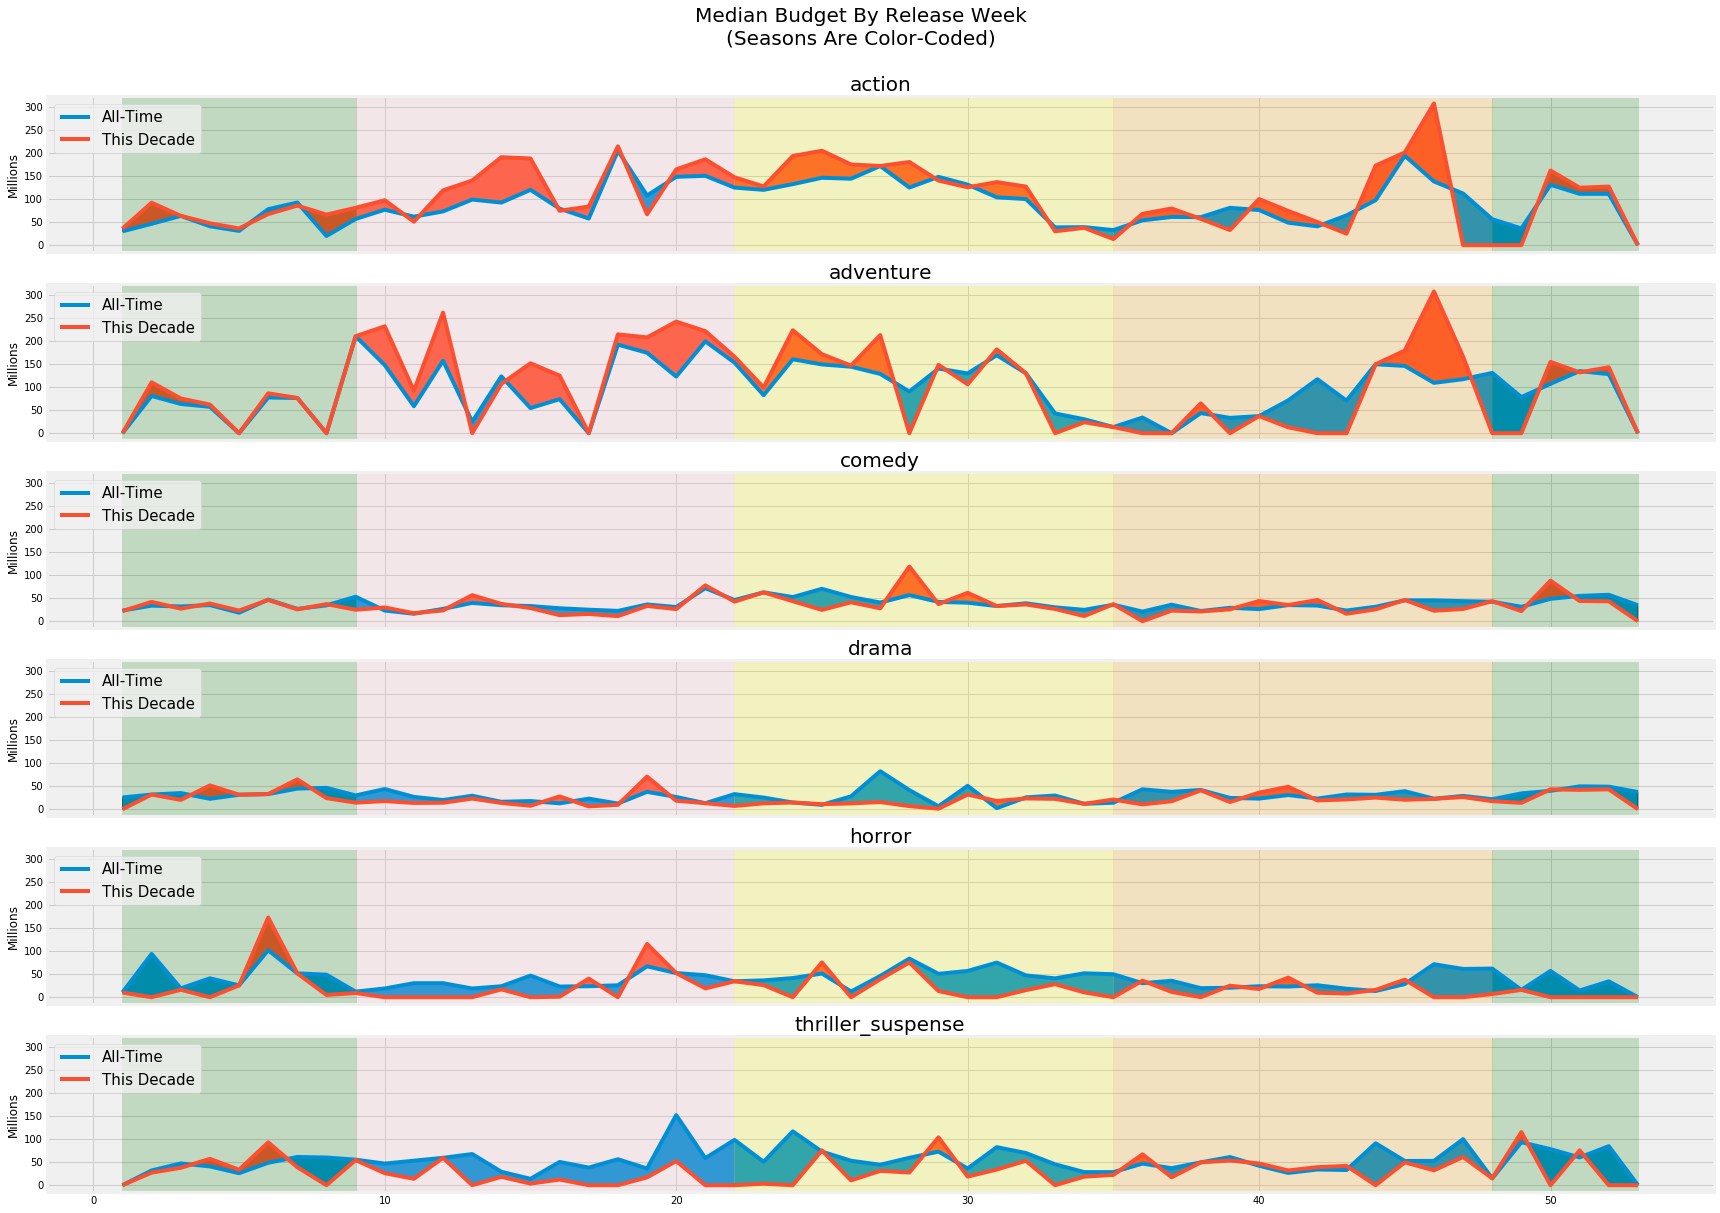

In [295]:
fill_between_by_release_week(data=data, title='Median Budget By Release Week\n(Seasons Are Color-Coded)', 
                             stat='budget_adj', genres=genres, colors=colors, y_label='Millions')

## Quick Takeaways

  - Action and Adventure have higher median budgets for pretty much every release week
  - Comedy and Drama seem to have moderately lower budgets overall this decade in almost every release week
  - Horror and Thriller/Suspense have steep drops in budget this decade for almost every release week

## Median Profit

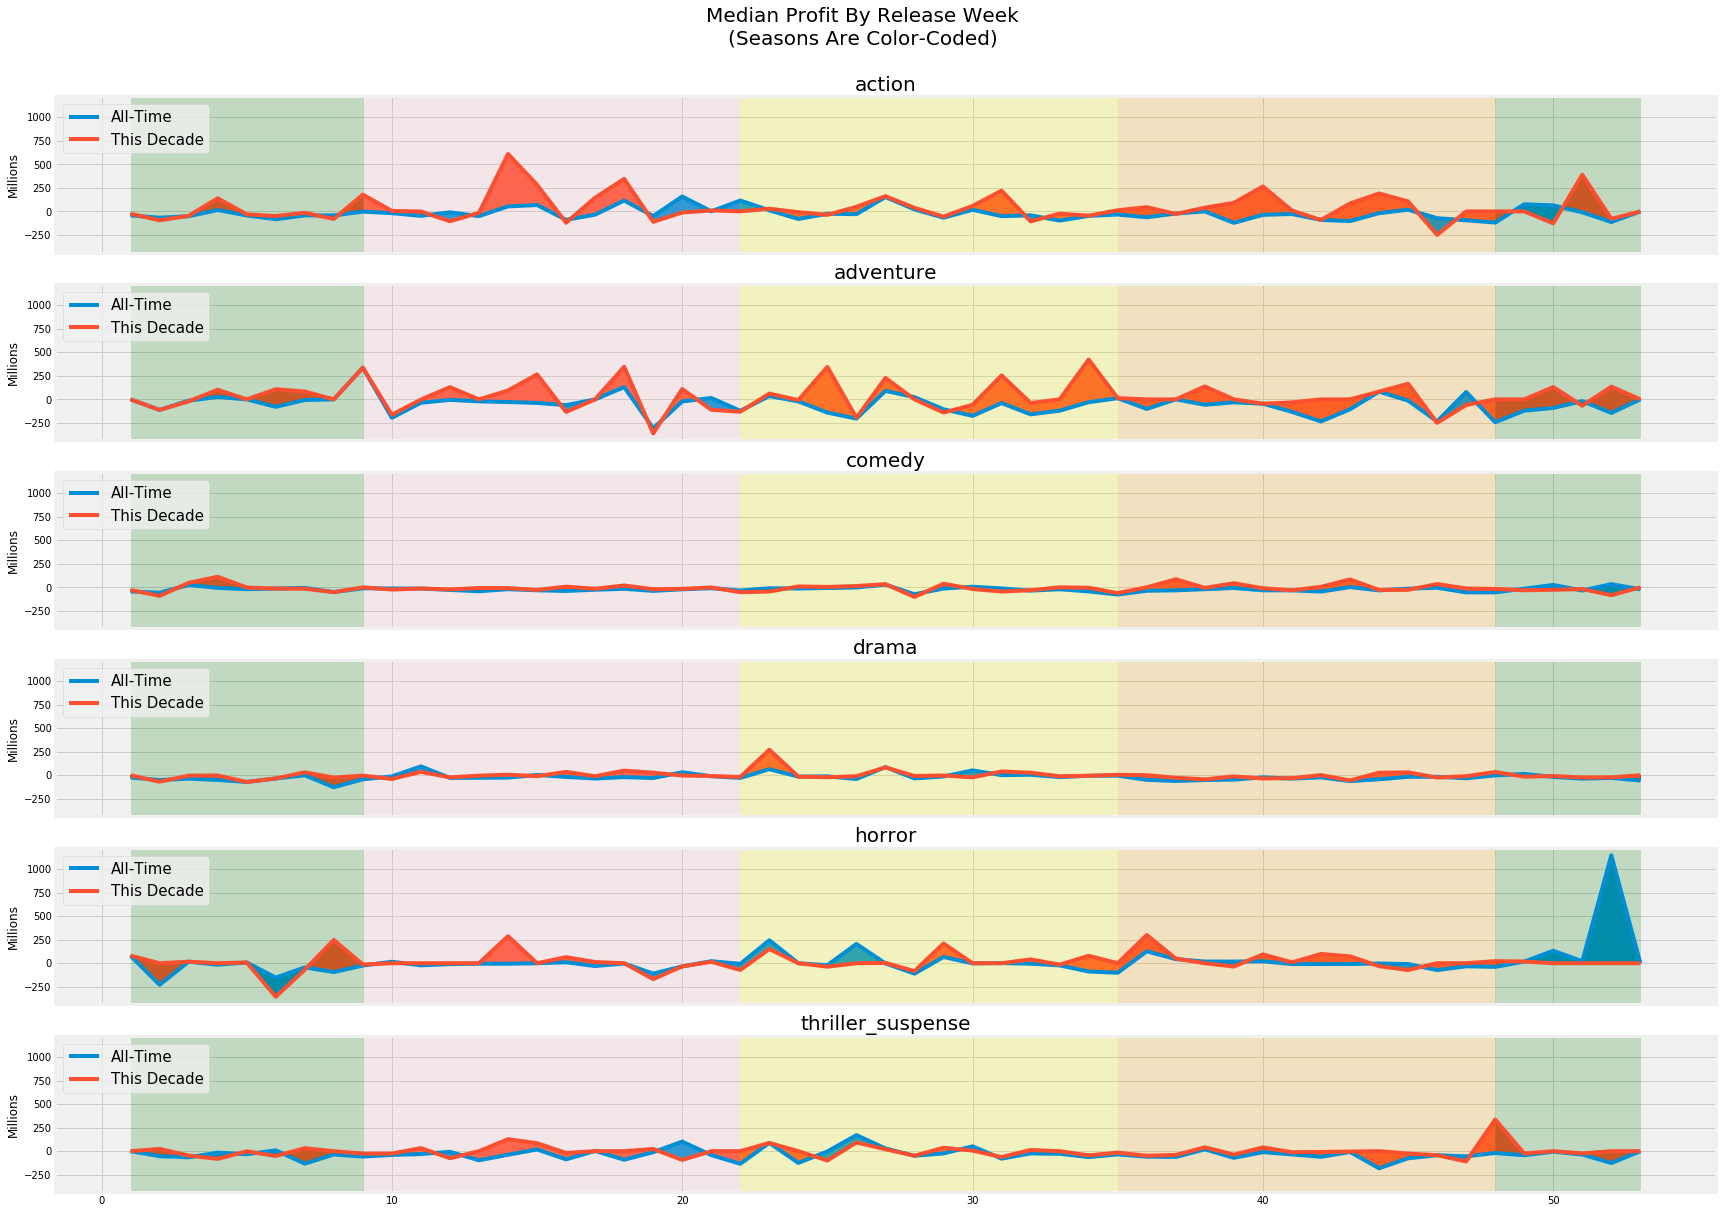

In [296]:
fill_between_by_release_week(data=data, title='Median Profit By Release Week\n(Seasons Are Color-Coded)', 
                             stat='profit', genres=genres, colors=colors, y_label='Millions')

## Quick Takeaways

**Similar results to Median Grosses analysis**
  - Action and Adventure are more profitable this decade than historically in almost every release week.
  - Comedy and Drama perform about the same as they did historically.
  - Horror has a few weeks where it has higher median profits than it does historically.
  - Thriller/Suspense in general performs a bit better this decade, most notably in Spring

## Breakeven Percentage

### All-Time

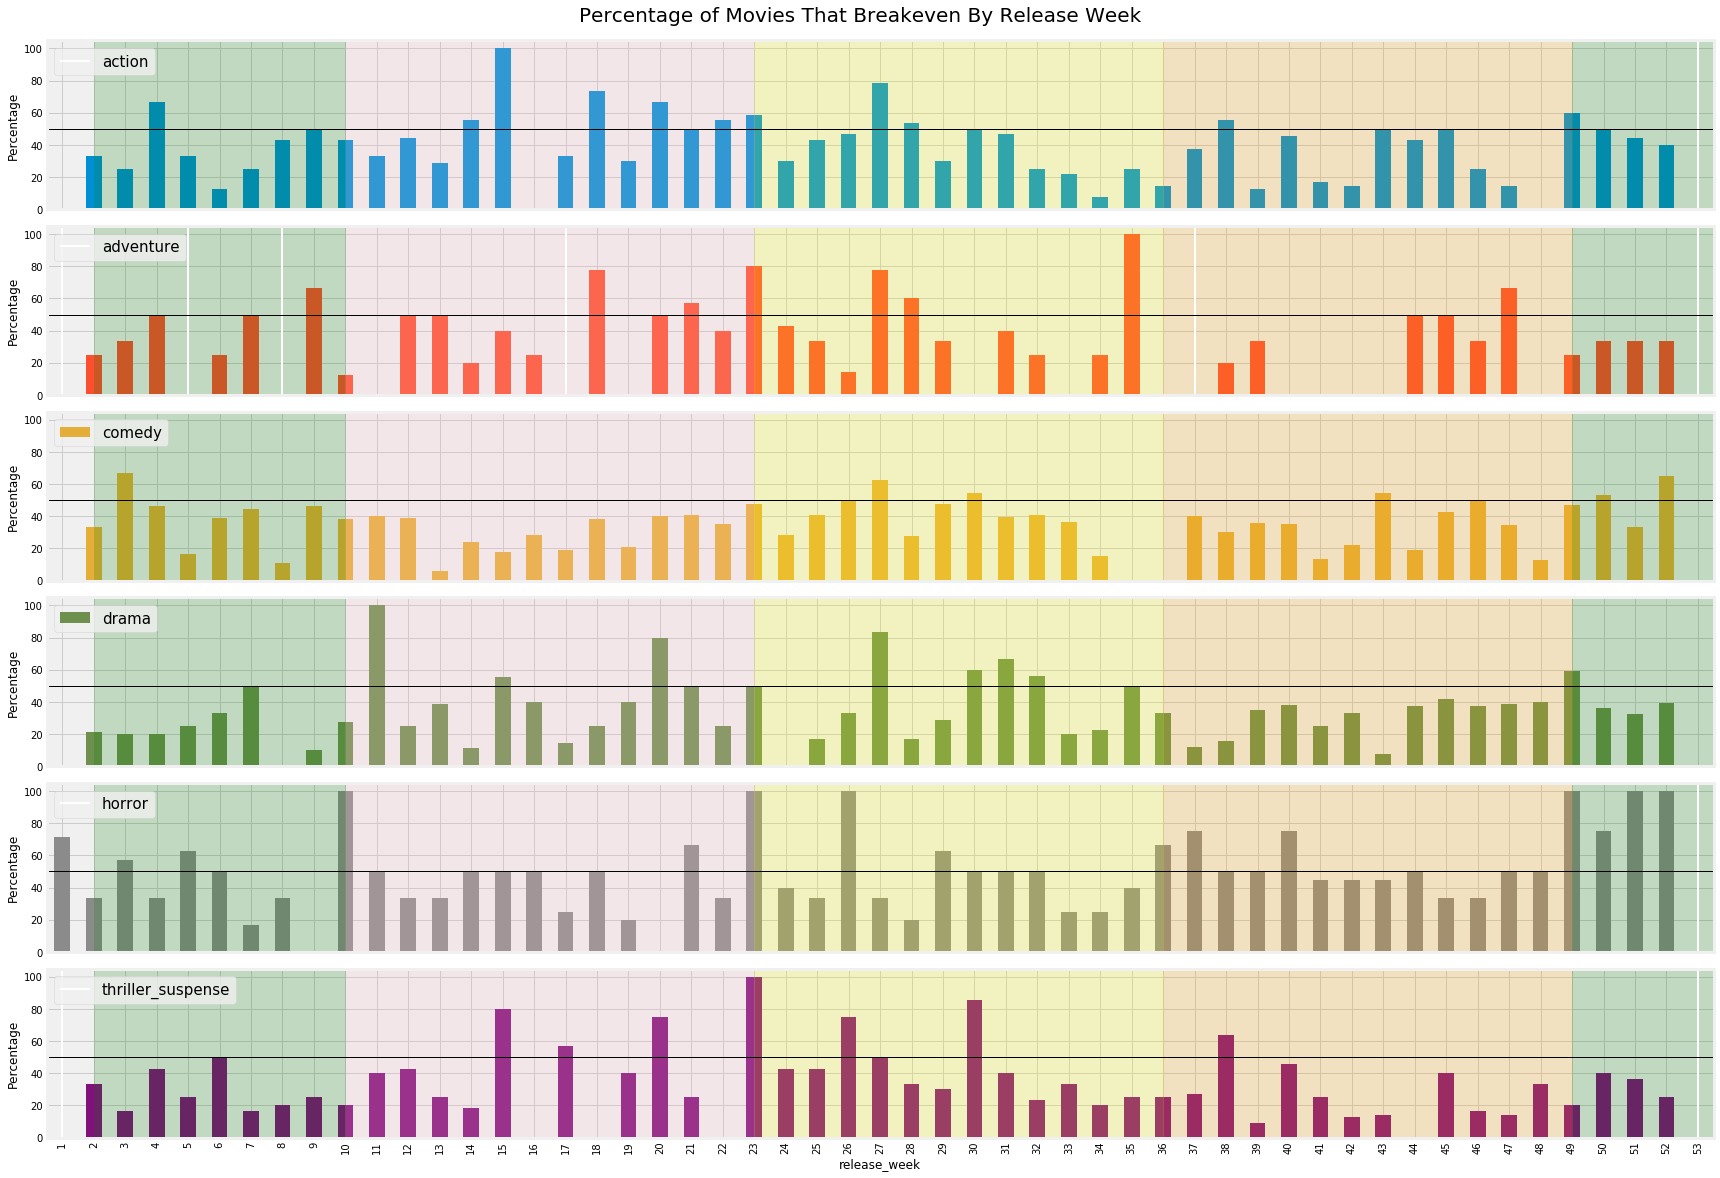

In [93]:
release_weeks_with_no_movies_all_time = [0] * 6
counter = [0, 1, 2, 3, 4, 5]

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week', fontsize=20, y=1.02)

for genre, axis, color, count in zip(genres, axes.flat, colors, counter):
    # Create two series with decades as indexes and count and sum as values
    #grp_count = data[data[genre]].groupby('release_week')['worldwide_breakeven'].count().copy()
    #grp_sum = data[data[genre]].groupby('release_week')['worldwide_breakeven'].sum().copy()
    grp = data[data[genre]].groupby('release_week')['worldwide_breakeven'].mean() * 100
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
            axis.axvline(week - 1, color='white', linewidth=2)
            release_weeks_with_no_movies_all_time[count] += 1

    # Sort the series by their index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Show 50% breakeven line
    axis.axhline(50, color='k', linewidth=1)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')
    
plt.tight_layout() 

<div class="alert alert-block alert-info">
    <b>The white vertical lines mean that no movies of that genre have ever been released on that week.</b>
    <br>
    <br>
    <b>The black horizontal line marks the 50% breakeven percentage.</b>
</div>

### Quick Takeaways

It looks like historically the best chance to breakeven is with a Horror movie in December.

### This Decade

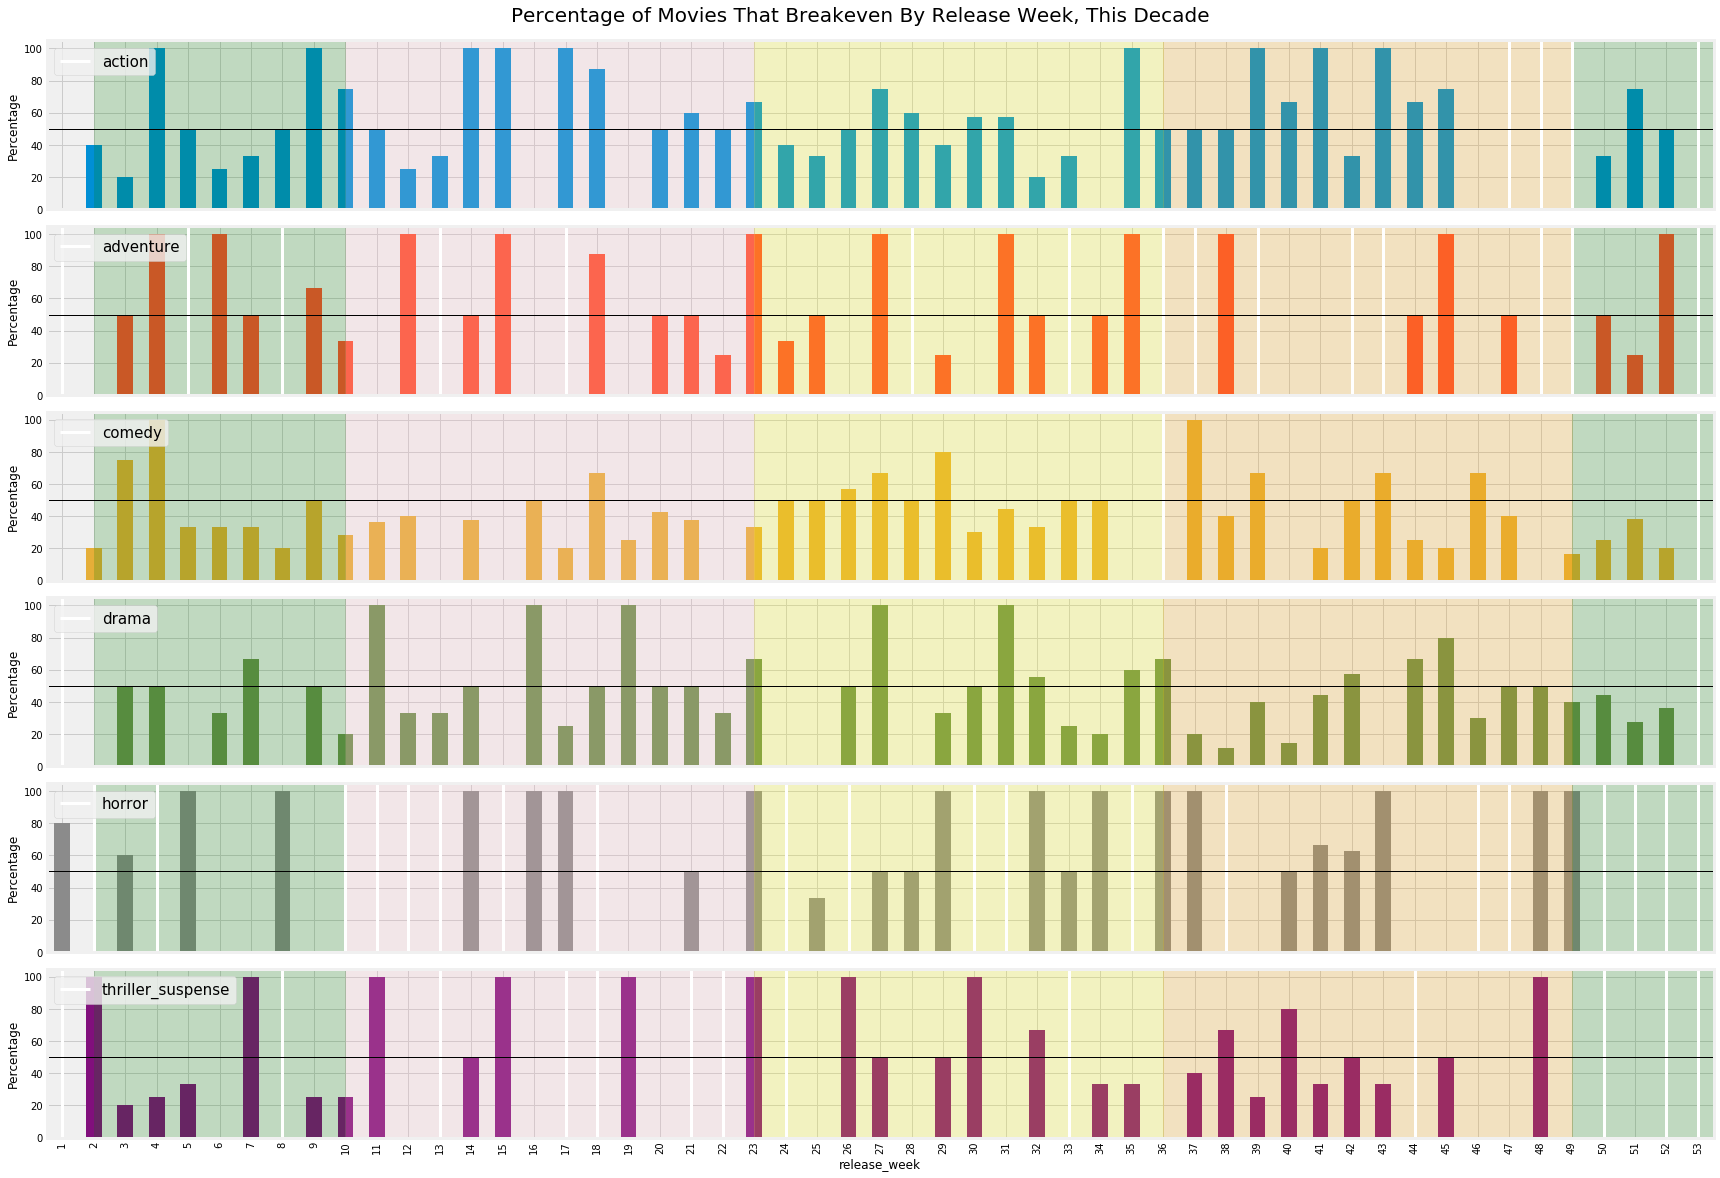

In [94]:
release_weeks_with_no_movies_this_decade = [0] * 6
counter = [0, 1, 2, 3, 4, 5]

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color, count in zip(genres, axes.flat, colors, counter):
    # Create two series with decades as indexes and count and sum as values
    #grp_count = data[data[genre]].groupby('release_week')['worldwide_breakeven'].count().copy()
    #grp_sum = data[data[genre]].groupby('release_week')['worldwide_breakeven'].sum().copy()
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['worldwide_breakeven'].mean() * 100
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
            axis.axvline(week - 1, color='white', linewidth=3)
            release_weeks_with_no_movies_this_decade[count] += 1

    # Sort the series by their index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Show 50% breakeven line
    axis.axhline(50, color='k', linewidth=1)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')
    
plt.tight_layout() 

### Quick Takeaways

It seems fewer release weeks are being utilized for some genres.

This might be coincidence, or it might be that studios don't think certain weeks work for some genres. 

In this decade, there are 20 weeks out of the year where a Horror movie hasn't been released!

In second place is Adventure with 15 missing weeks, then Thriller/Suspense with 13.

It seems like movies have a higher chance of breaking even this decade compared to the historical levels. This may be due to fewer movies being released overall, the growing assistance of the worlwide box office on a movie's financial picture, or studios being smarter about movie selection.

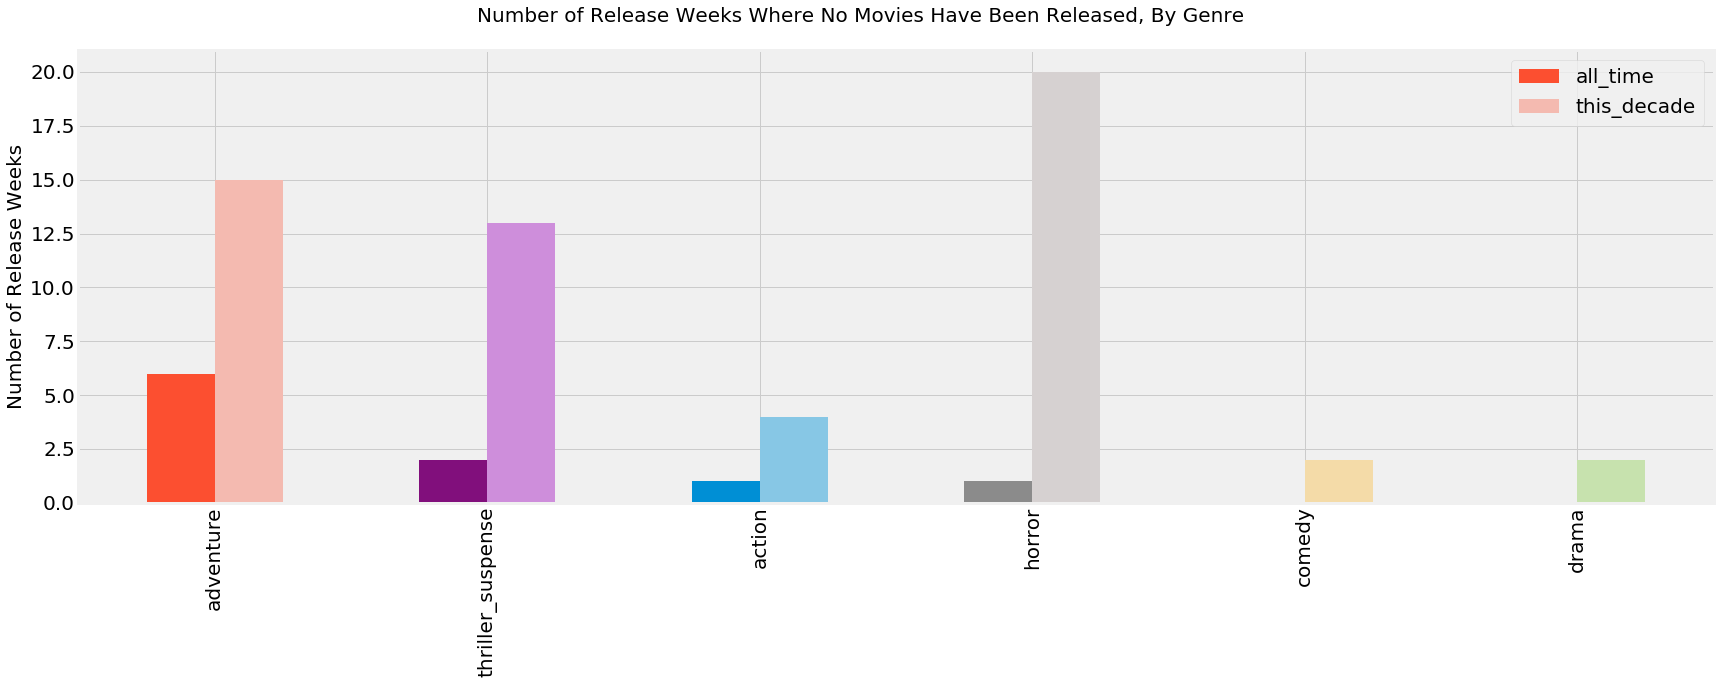

In [95]:
release_week = pd.DataFrame({'all_time': release_weeks_with_no_movies_all_time, 'this_decade': release_weeks_with_no_movies_this_decade}, index=genres)
release_week.sort_values(by='all_time', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=2, order_list=release_week.index)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Release Weeks Where No Movies Have Been Released, By Genre', fontsize=20, y=1.05)
release_week.plot(kind='bar', ax=axis, color=color_list)
axis.set_ylabel('Number of Release Weeks', fontsize=20)
axis.tick_params(labelsize=20)
axis.legend(fontsize=20)

plt.tight_layout()

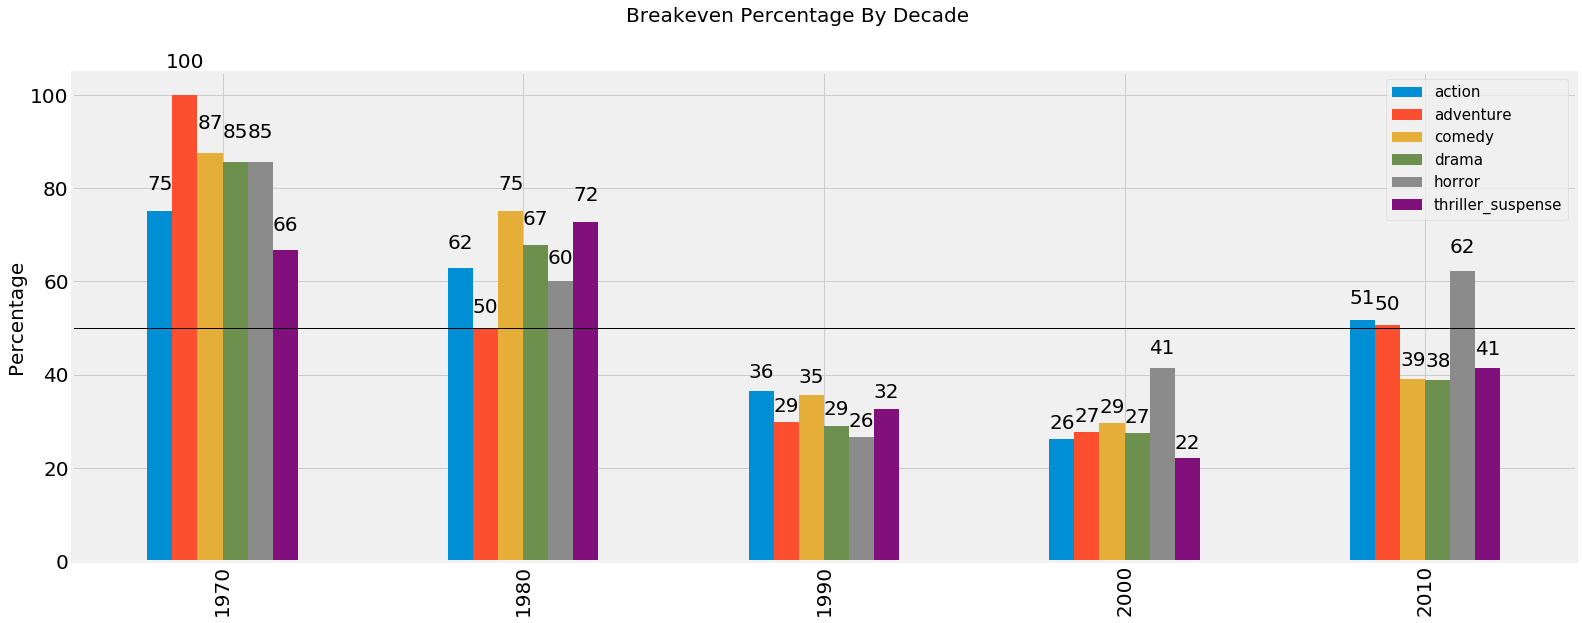

In [390]:
plot_by_time_and_stat(data=data, genres=genres, title='Breakeven Percentage By Decade', 
                      groupby_column='release_decade', stat_columns=breakeven_columns, 
                      aggregate_function='mean', apply_needed=True, apply_function=lambda x: x * 100, 
                      y_label='Percentage', y_ticks_needed=False, y_ticks='', legend_needed=True, 
                      legend_text=genres, color=colors, axhline_needed=True, axhline_value=50, autolabel_needed=True)

### Quick Takeaways

**Current Decade**
  - We are on an uptick in the probability that a movie will breakeven, regardless of genre
  - One explanation could be that since fewer movies are released overall, there's less competition at the theaters. If the same number of consumer dollars chase fewer movies, then more movies will be profitable. 
  - Another explanation is the rise in foreign box office dollars making otherwise unprofitable movies winners.

## Summary

  - Action and Adventure are currently performing better than they have historically regardless of release week.
  - Horror, Adventure, and Thriller/Suspense have been released on the fewest weeks this decade
  - Budgets have risen this decade for Action and Adventure, whereas they have dropped for Horror and Thriller/Suspense
  - All genres have their highest breakeven percentage this decade since the 1990s
  - From a median profitability standpoint, Action and Adventure have improved the most since the 2000s

# Conclusions, Conclusions, Conclusions

Our bosses want us to wrap this up at some point, so here we go...

Dear, sweet bosses, 

Can you give us data on ancillary revenue streams of these movies like DVD/Blu-ray, TV Airings, and Streaming?

You can't?

You can't, or you won't?

Aha, I knew it! 

So please take these conclusions with a large grain of salt. So large it might be called a heap of salt. Or a salt mountain, if you please.

## Summing Up

**Safest**
  - I would classify no genre as safe. All genres historically have negative median profit. 
  - Just looking at this decade, three genres have positive median profit: Horror (\\$23.3 million), Adventure (\\$10.4 million), and Action (\\$5.7 million)
  - With a very low median production budget (\\$17 million) and the highest chance of breaking even this decade (62%), Horror seems like the safest genre to invest in.
  - Note that historically Horror is one of the least produced genres, and yet has had the third highest median worldwide gross since the 2000s. In this decade, the top three highest median grossers are Adventure (\\$419 million), Action (\\$324 million), then Horror (\\$110 million)
  - It doesn't seem like the Horror market is oversaturated. It has followed the same trajectory in terms of number of movies produced as any other genre. Perhaps studios intentionally limit their Horror exposure. For example, if people associate a studio with Horror movies, they might be less inclined to see its other movies due to Horror's reputation as a low quality product (bad writing, bad acting, low budget, bad visuals).

**Highest potential return per movie**
  - If our boses want to maximize their return per movie, then either Action or Adventure are the best. They carry with them much higher production budgets, but also gross higher amounts than all other genres.

**Most calendar-friendly**
  - Comedy and Drama are the least affected by release week. If we want maximum flexibility there (for example, to avoid opening the same weekend as another big movie and thus incurring higher marketing costs), we can plug and play one of these genres into almost any week.
  
**Recent box office trends**
  - In the past decade, the most consistent genre in terms of median profit per movie is Horror, followed by Adventure, then Action. If we want to follow trends, these genres have been outperforming the others.


## Final Recommendations

### If we don't mind being associated with Horror movies

Then Horror, Horror, Horror.

There's a pretty good reason [Blumhouse](https://en.wikipedia.org/wiki/Blumhouse_Productions) is doing so well. It makes high quality movies that are inexpensive to produce. It's basically impossible to do that with Action or Adventure movies, but it can be done with Horror. Other studios could mimic Blumhouse's business model with the least expensive genres.

**Median Budgets This Decade**
  - Horror: \\$17 million
  - Drama: \\$22 million
  - Comedy: \\$32 million
  - Thriller/Suspense: \\$35 million
  - Action: \\$115 million
  - Adventure: \\$172 million
  
How many movies could we make for the same price as a typical Action or Adventure movie (not including marketing costs)?

**Number of movies per one Action movie**
  - Horror: 6.8 movies
  - Drama: 5.2 movies
  - Comedy: 3.6 movies
  - Thriller/Suspense: 3.3 movies

**Number of movies per one Adventure movie**  
  - Horror:            10.1
  - Drama:             7.8 movies
  - Comedy:            5.4 movies
  - Thriller/Suspense: 4.9 movies
  
Then what's the problem? Why can't we make these low to mid budget movies at a fraction of the cost and make money on them?

**The Streaming Problem**
  - It's entirely possible that Horror is the only inexpensive genre that audiences will still go to theaters for.
  - Many Drama, Comedy, and Thriller/Suspense movies that historically would have had a theatrical release are instead headed directly to streaming platforms like Netflix.
  - It might be that the concept and execution have to be much higher in these other genres than they do for Horror. After all, audiences seem willing to support a level of shlockiness in Horror movies that they won't in other genres. 
  - The financial upside may not be high enough to produce the other genres theatrically.
  
**Median Grosses This Decade**
  - Drama: \\$54 million
  - Comedy: \\$87 million
  - Thriller/Suspense: \\$99 million
  - Horror: \\$110 million
  - Action: \\$324 million
  - Adventure: \\$419 million
 
Currently, Drama, Comedy, and Thriller/Suspense might be too expensive theatrically but cheap enough for streaming. Even though they have much smaller budgets, the amount of marketing dollars to wide release a movie is substantial if you aren't great at viral marketing campaigns. Blumhose is particularly good at getting the most for their marketing dollar.

Studios may be shifting a lot of low budget fare to streaming platforms, where they get predetermined fees for their content and save big on marketing dollars. 

### If we don't want anything to do with Horror movies

The writing seems to be on the wall. Action and Adventure are the only other genres that are doing well this decade. They tend to travel well, which means the explosion in the foreign box office market bodes well for them. 

They are the most expensive genres to produce and market, but they are the big winners in terms of box office dollars.

## Parting Thoughts and Next Steps

Our dataset only includes revenue that movies generate from ticket sales, but that is only a slice of the movie revenue pie.

Stephen Follows has a [great article](https://stephenfollows.com/how-movies-make-money-hollywood-blockbusters/) detailing the revenue stream of movies nowadays. The following image comes from his article.

![Movie Revenue Stream](movie_money_chart.png)

To summarize, the release windows are:
  - Theatrical - movie theaters
  - Airlines and Hospitality - airplanes and hotels
  - Home Entertainment - purchase and rental of DVDs and Blu-ray
  - Video on Demand - these include several types
    - Transactional (TVOD) - purchase and rental of electronic copies from iTunes, Amazon, Google Play, etc.
    - Subscription (SVOD) - Netflix, HBO Now, YouTube TV, Amazon Video, Hulu Plus, etc.
    - Ad-funded (AVOD) - Hulu, Vudu, YouTube, etc.
  - Television - various forms
    - Pay TV (premium channels like HBO, Starz, Epix)
    - Free-to-air/Broadcast channels like BBC One, ABC, NBC, CBS, Fox, etc.
    - Syndication on digital channels like AMC, FX, TMC, TNT, etc.
  - Merchandising - products consumers buy like toys, games, clothes, etc.
  - Product Placement - charging brands to feature products in movies
  
Many of these later release windows gain higher license fees if a movie is successful at the box office, making the theatrical window very important. On the other hand, theatrical isn't the only moneymaker, and movies can make up for lackluster box office with future revenue streams.

Here are some next steps to spruce up our analyis: 
  - Getting access to data from other release windows to get the full financial scope of each movie
  - Dive deeper into analyzing movies by budget size (for example, analyzing subgenres by budget size)
  - Analyzing movies based on distributor
  - Analyzing movies based on key talent (such as actors, directors, etc.)
  - Instead of looking at profit, using a metric like the ratio of worldwide gross to budget to eliminate dealing with sums involving negative numbers
  
We have only scratched the surface in our analysis here, but our results provide very actionable insight. Genres that travel well (Action and Adventure) are earning the most these days, and Horror, due to its low cost and consistently good box office results, is a great genre to invest in.